# Notebook for SGAS1723 Stacked Flux Measurements

Paper draft: https://www.overleaf.com/5851713799ptkcrfvbggys

In [7]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

#from specutils.spectra import Spectrum1D
#from specutils.fitting.continuum import fit_continuum
#from specutils.fitting import fit_generic_continuum
#from specutils.fitting import fit_lines
#from specutils import SpectralRegion
#from specutils.analysis import snr
#from specutils.analysis import line_flux

from astropy.io import fits
import astropy.units as u
from astropy.modeling import models
from astropy.nddata import StdDevUncertainty
from astropy.visualization import LogStretch, ImageNormalize, SquaredStretch, ManualInterval, PowerStretch

import os

from importlib import reload

import entomology.bw_specstuff as bws
#import templates.spec as bws
import jwst_templates as tem


In [18]:
%matplotlib notebook

In [2]:
print(np.sqrt((5.66/976.5)**2 + (3.42/155.52)**2) * 6.28)
print(np.sqrt((11/776)**2 + (4/142)**2) * 5.46)
print(np.sqrt(0.14**2 + 0.17**2))
print((6.28 - 5.46) / 0.22)

0.14281840355972003
0.1721789410278937
0.22022715545545243
3.7272727272727284


In [3]:
print(np.sqrt((5/64)**2 + (4/142)**2) * 2.22)
print(np.sqrt((1/70)**2 + (3.42/155.52)**2) * 2.23)


0.18436707692680404
0.05847850529100529


In [4]:
print(421/142)
print(np.sqrt((8/421)**2+(4/142)**2)*(421/142))
print(504/156)
print(np.sqrt((3.8/504)**2+(3.42/155.52)**2))
print((3.23-2.96)/np.sqrt(.1**2+.02**2))

2.964788732394366
0.1007410441024801
3.230769230769231
0.023247354497354492
2.6475678243654843


In [8]:
reload(bws), reload(tem.spec)

(<module 'entomology.bw_specstuff' from '/Users/bdwelch1/code/entomology/bw_specstuff.py'>,
 <module 'jwst_templates.spec' from '/Users/bdwelch1/code/jwst_templates/spec.py'>)

In [25]:
bws.rest2obs(4076,1.3293)

9494.2268

In [24]:
bws.obs2rest(1.0418, 1.3293)

0.4472588331258318

In [2]:
print("[OII] 7320,7330:",bws.rest2obs(7320, 1.3293), bws.rest2obs(7330, 1.3293))
print(bws.rest2obs(6300,1.3293))
print(17050.476/3000)

[OII] 7320,7330: 17050.476 17073.769
14674.59
5.683491999999999


In [10]:
# step one - extract a spectrum 
# First define some locations/filenames:

# main data cubes:
datadir = '/Users/bdwelch1/Documents/data/templates/sdss1723/nirspec/pmap1105/L3_destripe'
#datadir = '/Users/bdwelch1/Documents/data/templates/sdss1723/nirspec/pmap1089/L3_destripe'
#cubefile_g140h = 'Level3_SGAS1723_BGSUB_OUTLIER_XY0p1_g140h-f100lp_s3d.fits'
cubefile_g140h = 'SGAS1723-sigmaclipped-g140h-s3d-alt-outlier.fits'
cubefile_g395h = 'SGAS1723-sigmaclipped-g395h-s3d.fits'

# mask for extracting a fill 1D spectrum
maskdir = '/Users/bdwelch1/Documents/science/templates/ifu_masks'
maskfile = 'SGAS1723-mask-layers.fits'


#### Make smaller mask for [SIII]6313, so we don't get all the extra noise

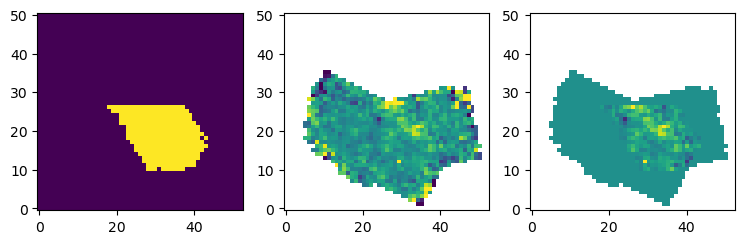

In [7]:
# first, lets look at the current mask, plus the data, and see what's what
mask_oneclump = fits.open(os.path.join(maskdir, maskfile))[0].data

# tweak the mask:
mask_oneclump[27:,:] = 0

cubedat = fits.open(os.path.join(datadir,cubefile_g140h))[1].data
slice = cubedat[2110,:,:]

cutout = slice*mask_oneclump

fig, ax = plt.subplots(1,3, figsize=(9,3))

ax[0].imshow(mask_oneclump, origin='lower')

ax[1].imshow(slice, origin='lower', vmin=-2, vmax=2)

ax[2].imshow(cutout, origin='lower', vmin=-2, vmax=2)

plt.show()

In [142]:
# save this new mask as a new file, so we can run our line fits with it
# as a bonus, this gives us a clear comparison to Halpha and CECILIA - woohoo!
if 0:
    newhdu = fits.PrimaryHDU(mask_oneclump)
    newhdu.writeto(os.path.join(maskdir, 'SGAS1723_oneclump_mask.fits'))

#### Now let's get to fitting!

In [11]:
# load in the spectrum!
df140 = tem.spec.integrate1D_mask(os.path.join(datadir, cubefile_g140h), 
                                   os.path.join(maskdir,maskfile),
                                   zsource=1.3293)


<IPython.core.display.Javascript object>


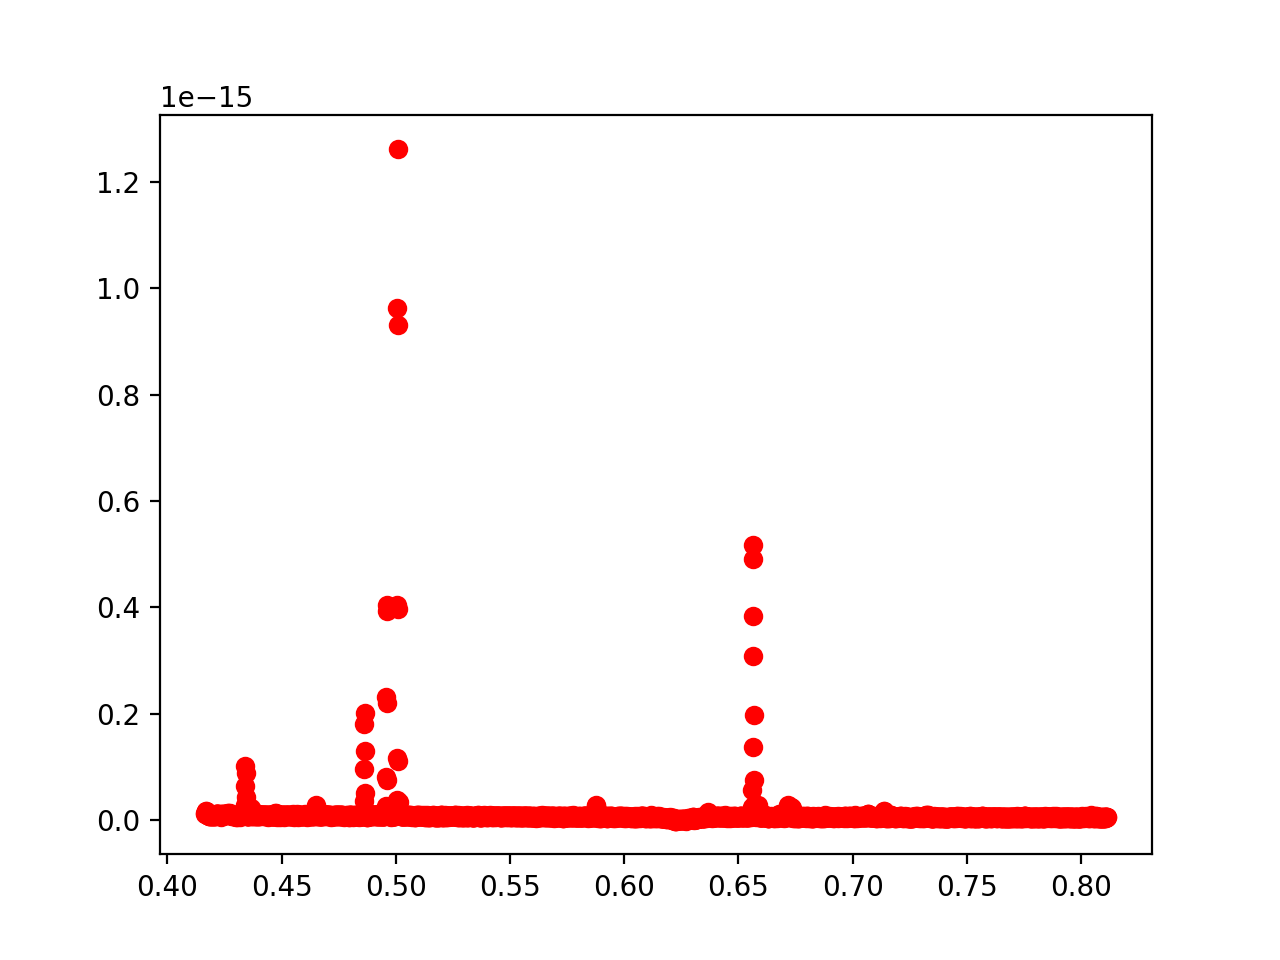

In [19]:
fig = plt.figure()

plt.plot(df140["rest_wave"], df140["flam"], 'ro')


plt.show()

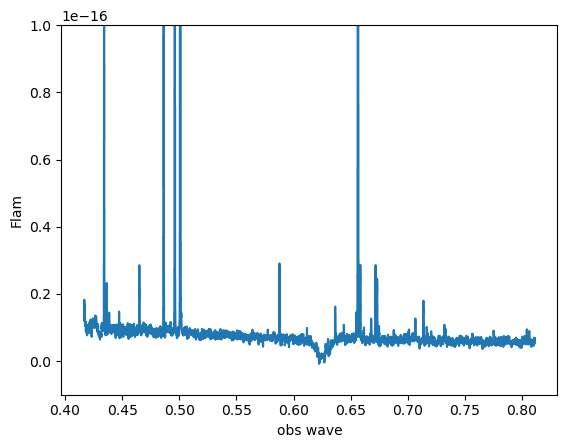

In [12]:
fig = plt.figure()
plt.step(df140["rest_wave"], df140["flam"], where='mid')
plt.xlabel('obs wave')
plt.ylabel('Flam')
#plt.xlim(.56, .6)
plt.ylim(-1e-17,1e-16)
plt.show()

In [6]:
# load in the other spectrum for 1723 (don't really use it?)
#df395 = tem.spec.integrate1D_mask(os.path.join(datadir, cubefile_g395h), 
#                                   os.path.join(maskdir,maskfile),
#                                   zsource=1.3293)

In [7]:
#fig = plt.figure()
#plt.step(df395["rest_wave"], df395["flam"], where='mid')
#plt.xlabel('rest wave')
#plt.ylabel('Flam')
#plt.show()

In [9]:
# save dataframe to csv for Jane's continuum fitting 
#df140_cgs.to_csv('SGAS1723_g140h_clipped_1D_from_mask.csv')

# Line fitting
First we continuum subtract everything, then we fit the lines we need. We'll add everything to a dictionary for easy access later on. 

In [13]:
# let's run the continuum fit!
box140 = tem.continuum.get_boxcar4autocont_nirspec('g140h','f100lp',zz=1.3293)
print(box140)
cont140 = tem.continuum.fit_autocont(df140, zz=1.3293, boxcar=box140, v2mask=300,
                                    colwave='wave', colf='flam', colcont='flam_autocont')

99


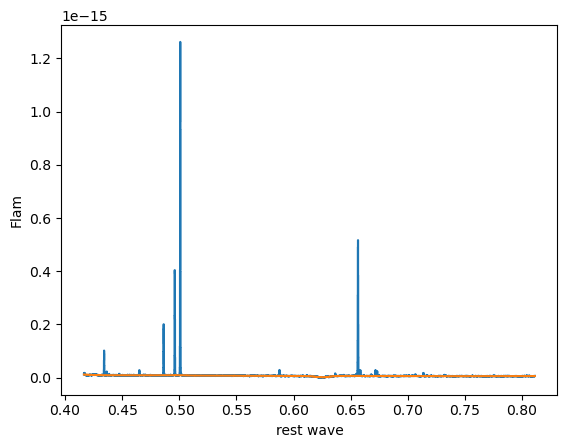

In [14]:
fig = plt.figure()
plt.step(df140["rest_wave"], df140["flam"], where='mid')
plt.step(df140["rest_wave"], df140["flam_autocont"], where='mid')
plt.xlabel('rest wave')
plt.ylabel('Flam')
plt.show()

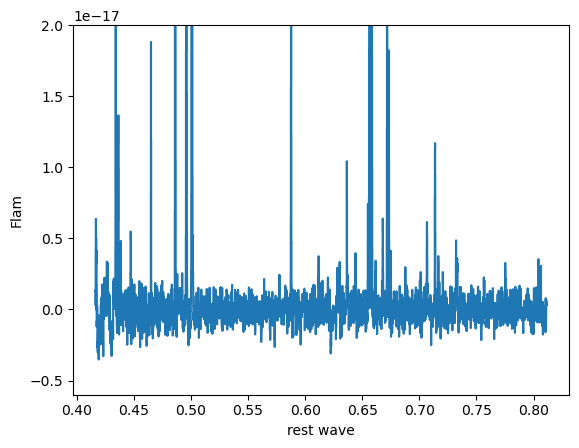

In [15]:
fig = plt.figure()
plt.step(df140["rest_wave"], df140["flam"] - df140["flam_autocont"], where='mid')
#plt.step(df140["rest_wave"], df140["flam_autocont"], where='mid')
plt.xlabel('rest wave')
plt.ylabel('Flam')
#plt.xlim(0.7,0.75)
#plt.xlim(0.45,0.5)
plt.ylim(-0.6e-17,2e-17)
plt.show()

In [16]:
# make an empty dict for our line fluxes
#lines = {
#    'ion':[],
#    'wave':[],
#    'flux':[],
#    'fluxerr':[]
#}
# read in line list as a dataframe (this is much nicer to work with)
lines = pd.read_csv('/Users/bdwelch1/code/jwst_templates/Reference_files/emission_lines_BWlocal.txt',
                       sep='\s+', skiprows=5)
zeros = np.zeros(len(lines))
lines['flux'] = zeros
lines['fluxerr'] = zeros
lines['dered_flux'] = zeros
lines['dered_fluxerr'] = zeros
lines['final_flux'] = zeros
lines['final_fluxerr'] = zeros
#lines

In [17]:
reload(tem.spec)

<module 'jwst_templates.spec' from '/Users/bdwelch1/code/jwst_templates/spec.py'>

In [9]:
%matplotlib inline

7.598506718430951e-18 0.2400705305544275


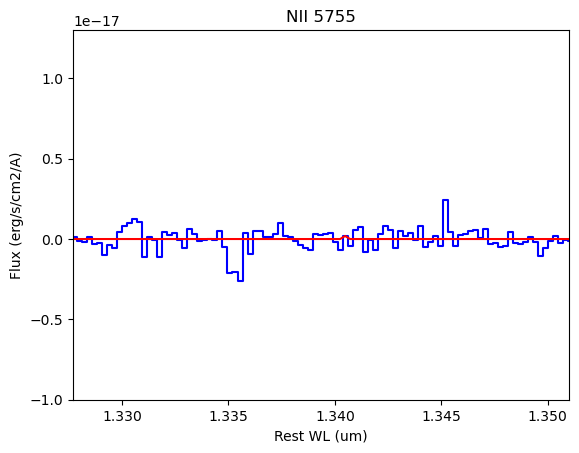

5755 flux,err: 4.572534997994034e-18 1.8119986799928148e-09


In [20]:
# TEST - fit NII5755 with a Gaussian - what is uncertainty? 
scale=1e16
zsource = 1.3293

line5755 = [0.57*(1+zsource), 0.58*(1+zsource)]#SpectralRegion(0.495*u.um, 0.502*u.um) 
param_dictNII = {
    "amplitude": [1],
    "wavelength": [5755*(1+zsource)],
    "width": [2]
}

f,ferr,poptNII,pcovNII = tem.spec.cont_sub_curvefit(df140,
                                                            line5755,
                                                            line_param_dict=param_dictNII,
                                                            scale=scale,
                                                            obs_wl=True,
                                                            verbose=True)

f5755 = f[0]
ferr5755 = ferr[0]

fitresNII = bws.multigauss2(df140.wave, poptNII[0]/scale, poptNII[1]/1e4,poptNII[2]/1e4)

fig = plt.figure()

plt.step(df140.wave, df140.flam-df140.flam_autocont, 'b-', where='mid')
#plt.plot(contsub7330.spectral_axis, fit7330(wlarray), 'r-')
#plt.plot(contsub7320.spectral_axis, fit7320(wlarray), 'r-')
plt.plot(df140.wave, fitresNII, 'r-')
plt.xlabel('Rest WL (um)')
plt.ylabel('Flux (erg/s/cm2/A)')
plt.title('NII 5755')
plt.xlim(0.57*(1+zsource), 0.58*(1+zsource))
plt.ylim(-1e-17, 1.3e-17)
plt.show()

print("5755 flux,err:",f5755, ferr5755)
# add it all to the df:


4.1541234910528146e-16 3.125762659801665
1.2342328570793816e-15 3.1563618489318537
1.958223435546766e-16 3.1683131383908973


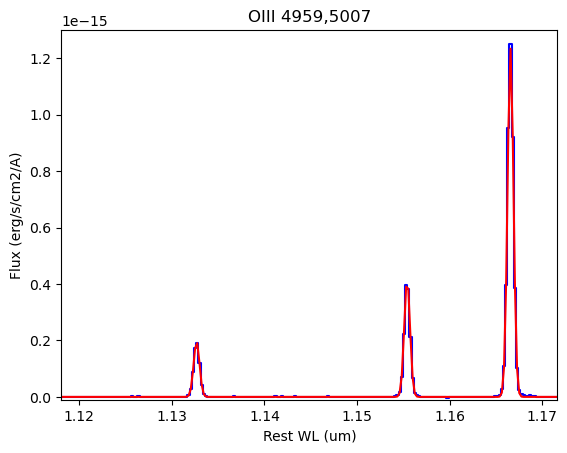

4959 flux,err: 3.2548077078899633e-15 3.8348134959022984e-17
5007 flux,err: 9.765035430347258e-15 5.658601293580716e-17
OIII ratio: 3.000188123764081
Hbeta flux,err: 1.5551786169429782e-15 3.416129691296748e-17


In [18]:
# great success! Now let's fit OIII!
scale=1e16
zsource = 1.3293

line5008 = [0.48*(1+zsource), 0.502*(1+zsource)]#SpectralRegion(0.495*u.um, 0.502*u.um) 
param_dictOIII = {
    "amplitude": [1,1,1],
    "wavelength": [4960*(1+zsource), 5008*(1+zsource), 4861*(1+zsource)],
    "width": [2, 2, 2]
}

f,ferr,poptOIII,pcovOIII = tem.spec.cont_sub_curvefit(df140,
                                                            line5008,
                                                            line_param_dict=param_dictOIII,
                                                            scale=scale,
                                                            obs_wl=True,
                                                            verbose=True)

f4960 = f[0]
f5008 = f[1]
fHb = f[2]
ferr4960 = ferr[0]
ferr5008 = ferr[1]
ferrHb = ferr[2]

fitresOIII = bws.multigauss2(df140.wave, poptOIII[0]/scale, poptOIII[1]/1e4,
                     poptOIII[2]/1e4, poptOIII[3]/scale, poptOIII[4]/1e4, poptOIII[5]/1e4,
                            poptOIII[6]/scale, poptOIII[7]/1e4, poptOIII[8]/1e4)

fig = plt.figure()

plt.step(df140.wave, df140.flam-df140.flam_autocont, 'b-', where='mid')
#plt.plot(contsub7330.spectral_axis, fit7330(wlarray), 'r-')
#plt.plot(contsub7320.spectral_axis, fit7320(wlarray), 'r-')
plt.plot(df140.wave, fitresOIII, 'r-')
plt.xlabel('Rest WL (um)')
plt.ylabel('Flux (erg/s/cm2/A)')
plt.title('OIII 4959,5007')
plt.xlim(0.48*(1+zsource), 0.503*(1+zsource))
plt.ylim(-1e-17, 1.3e-15)
plt.show()

print("4959 flux,err:",f4960, ferr4960)
print("5007 flux,err:",f5008, ferr5008)
print("OIII ratio:", f5008/f4960)
print("Hbeta flux,err:",fHb, ferrHb)
# add it all to the df:
idx = lines.index[lines['restwave']==5008.240][0] # OIIIb
lines.at[idx,'flux'] = f5008
lines.at[idx, 'fluxerr'] = ferr5008
idx = lines.index[lines['restwave']==4960.295][0] #OIIIa
lines.at[idx,'flux'] = f4960
lines.at[idx, 'fluxerr'] = ferr4960
idx = lines.index[lines['restwave']==4862.683][0] #Hbeta
lines.at[idx,'flux'] = fHb
lines.at[idx, 'fluxerr'] = ferrHb


In [15]:
poptOIII

array([4.15412365e+00, 1.15540700e+04, 3.12576250e+00, 1.23423360e+01,
       1.16657339e+04, 3.15635968e+00, 1.95822462e+00, 1.13266421e+04,
       3.16831027e+00])

In [12]:
reload(tem.spec)

<module 'jwst_templates.spec' from '/Users/bdwelch1/code/jwst_templates/spec.py'>

1.4033482111802422e-17 3.223045384369888
9.403220260489538e-17 2.955853121058038


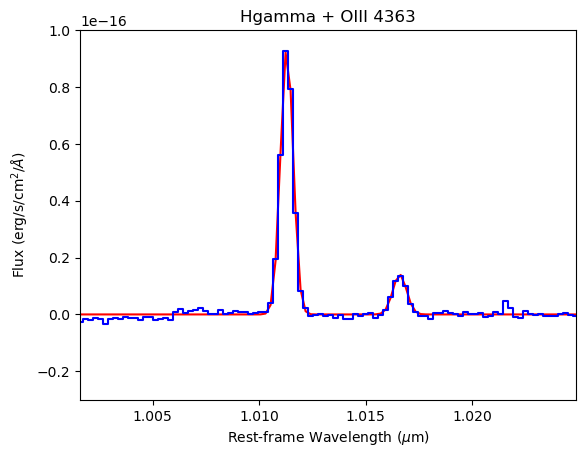

OIII 4363:  1.1337617487314025e-16 1.0708681077248427e-17
Hgamma:  6.967057471821771e-16 9.69138844452154e-18


In [48]:
scale = 1e16
pars4363_Hg = {
    "amplitude": [1,1],
    "wavelength": [4363*(1+zsource),4341*(1+zsource)],
    "width": [1,1]
}
flux4363, fluxerr4363, popt, pcov = tem.spec.cont_sub_curvefit(df140, 
                               line_region = [0.432*(1+zsource), 0.4369*(1+zsource)], 
                               line_param_dict = pars4363_Hg,
                               verbose=True,
                                obs_wl=True,
                                scale=scale)

f4363 = flux4363[0]
ferr4363 = fluxerr4363[0]
fHg = flux4363[1]
ferrHg = fluxerr4363[1]

fit4363 = tem.spec.multigauss(df140.wave, popt[0]/scale,popt[1]/1e4,popt[2]/1e4,
                      popt[3]/scale,popt[4]/1e4,popt[5]/1e4)
fig = plt.figure()

#plt.errorbar(contsub4363.spectral_axis, contsub4363.flux.value, yerr=contsub4363.uncertainty.array, fmt='b-')
plt.plot(df140.wave, fit4363, 'r-')
plt.step(df140.wave, df140.flam - df140.flam_autocont, 'b-', where='mid')
#plt.step(spectrum_g140h.spectral_axis, spectrum_g140h.flux, 'g-', where='mid')
plt.xlabel('Rest-frame Wavelength ($\mu$m)')
plt.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
plt.title('Hgamma + OIII 4363')
plt.xlim(0.43*(1+zsource), 0.44*(1+zsource))
plt.ylim(-3e-17, 1e-16)
plt.show()

print("OIII 4363: ", f4363, ferr4363)
print("Hgamma: ", fHg, ferrHg)
#print(popt)
idx = lines.index[lines['restwave']==4364.436][0] # OIII
lines.at[idx,'flux'] = f4363
lines.at[idx, 'fluxerr'] = ferr4363
idx = lines.index[lines['restwave']==4341.684][0] #Hgamma
lines.at[idx,'flux'] = fHg
lines.at[idx, 'fluxerr'] = ferrHg


In [17]:
perr = np.sqrt(np.diag(pcov))
popt, perr

(array([1.40334821e-01, 1.01660206e+04, 3.22304538e+00, 9.40322026e-01,
        1.01130238e+04, 2.95585312e+00]),
 array([0.00925122, 0.2201949 , 0.21801541, 0.00933743, 0.02873562,
        0.02879354]))

In [328]:
# calculate width in km/s
def sigma_to_velocity(sigma, mu):
    # assume sigma in Angstroms
    c = 2.998*10**5 # double check this
    vel = c * (sigma/mu)
    return vel

perrOIII = np.sqrt(np.diag(pcovOIII))
print(sigma_to_velocity(poptOIII[2],poptOIII[1]), 81*np.sqrt((perrOIII[2]/poptOIII[2])**2 + (perrOIII[1]/poptOIII[1])**2)) 
print(sigma_to_velocity(poptOIII[5],poptOIII[4]), 81*np.sqrt((perrOIII[5]/poptOIII[5])**2 + (perrOIII[4]/poptOIII[4])**2))
print(sigma_to_velocity(popt[2], popt[1]),95*np.sqrt((perr[2]/popt[2])**2 + (perr[1]/popt[1])**2))
print(sigma_to_velocity(popt[5], popt[4]),87*np.sqrt((perr[5]/popt[5])**2 + (perr[4]/popt[4])**2))

81.1059301670675 0.6004567190306107
81.11591128776162 0.2680125647430686
95.04889343712082 6.42605436986757
87.62609310280037 0.8474840798763252


3.054539283045381e-17 0.4199806828063614
9.40322026065106e-17 2.9558531209730265
1.3888892626672226e-17 -3.1552692826550834


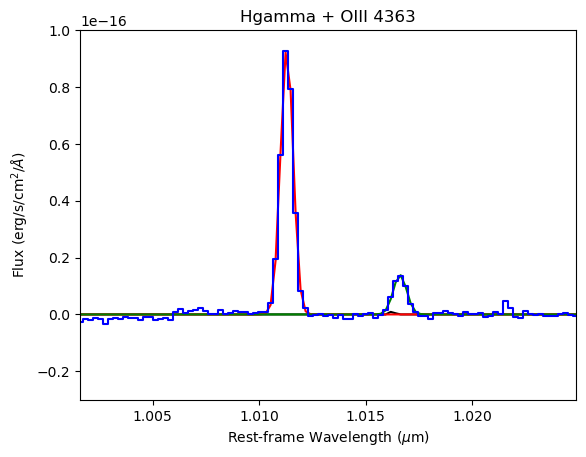

OIII 4363:  3.215621799878912e-17 0.005108854052992298
Hgamma:  6.967057471741072e-16 1.0026691663389687e-17
FeII 4360:  1.0984846286770303e-16 2.8132342462380996e-17
[ 3.05453928e-01  1.01628910e+04  4.19980683e-01  9.40322026e-01
  1.01130238e+04  2.95585312e+00  1.38888926e-01  1.01661462e+04
 -3.15526928e+00]


In [17]:
# 4363 with added FeII 4360 component (should fit to zero)
scale = 1e16
pars4363_Hg = {
    "amplitude": [1,1,0.1],
    "wavelength": [4363*(1+zsource),4341*(1+zsource),4360*(1+zsource)],
    "width": [1,1,1]
}
flux4363, fluxerr4363, popt, pcov = tem.spec.cont_sub_curvefit(df140, 
                               line_region = [0.432*(1+zsource), 0.4369*(1+zsource)], 
                               line_param_dict = pars4363_Hg,
                               verbose=True,
                                obs_wl=True,
                                scale=scale)

f4363 = flux4363[0]
ferr4363 = fluxerr4363[0]
fHg = flux4363[1]
ferrHg = fluxerr4363[1]
f4360 = flux4363[2]
ferr4360 = fluxerr4363[2]

fit4363 = tem.spec.multigauss(df140.wave, popt[0]/scale,popt[1]/1e4,popt[2]/1e4,
                      popt[3]/scale,popt[4]/1e4,popt[5]/1e4,
                             popt[6]/scale,popt[7]/1e4,popt[8]/1e4)
fitsplit_a = tem.spec.multigauss(df140.wave, popt[0]/scale,popt[1]/1e4,popt[2]/1e4)
fitsplit_b = tem.spec.multigauss(df140.wave, popt[3]/scale,popt[4]/1e4,popt[5]/1e4)
fitsplit_c = tem.spec.multigauss(df140.wave, popt[6]/scale,popt[7]/1e4,popt[8]/1e4)

fig = plt.figure()

#plt.errorbar(contsub4363.spectral_axis, contsub4363.flux.value, yerr=contsub4363.uncertainty.array, fmt='b-')
#plt.plot(df140.wave, fit4363, 'r-')
plt.plot(df140.wave, fitsplit_a, 'k-')
plt.plot(df140.wave, fitsplit_b, 'r-')
plt.plot(df140.wave, fitsplit_c, 'g-')
plt.step(df140.wave, df140.flam - df140.flam_autocont, 'b-', where='mid')
#plt.step(spectrum_g140h.spectral_axis, spectrum_g140h.flux, 'g-', where='mid')
plt.xlabel('Rest-frame Wavelength ($\mu$m)')
plt.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
plt.title('Hgamma + OIII 4363')
plt.xlim(0.43*(1+zsource), 0.44*(1+zsource))
plt.ylim(-3e-17, 1e-16)
plt.show()

print("OIII 4363: ", f4363, ferr4363)
print("Hgamma: ", fHg, ferrHg)
print("FeII 4360: ", f4360, ferr4360)
print(popt)

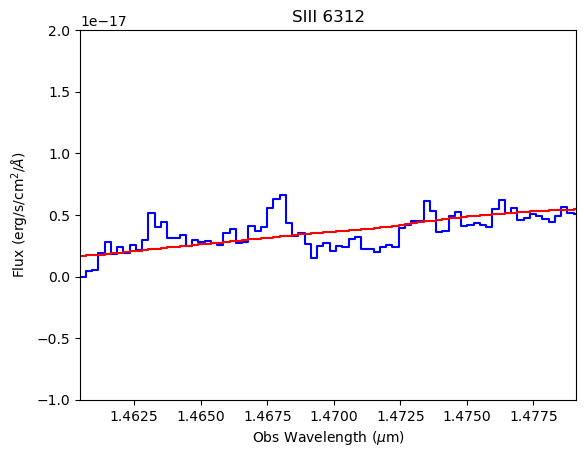

In [18]:
scale = 1e16
pars6312 = {
    "amplitude": [1,1],
    "wavelength": [6314*(1+zsource),6300*(1+zsource)],
    "width": [1,1]
}
#flux6312, fluxerr6312, popt, pcov = tem.spec.cont_sub_curvefit(df140, 
#                               line_region = [0.63*(1+zsource), 0.635*(1+zsource)], 
#                               line_param_dict = pars6312,
#                               verbose=True,
#                                obs_wl=True,
#                                scale=scale)

#fit6312 = tem.spec.multigauss(df140.wave, popt[0]/scale,popt[1]/1e4,popt[2]/1e4,
#                           popt[3]/scale,popt[4]/1e4,popt[5]/1e4)

#f6312 = flux6312[0]
#ferr6312 = fluxerr6312[0]
#f6300 = flux6312[1]
#ferr6300 = fluxerr6312[1]

fig = plt.figure()

#plt.errorbar(contsub4363.spectral_axis, contsub4363.flux.value, yerr=contsub4363.uncertainty.array, fmt='b-')
#plt.plot(df140.wave, fit6312, 'r-')
#plt.step(df140.wave, df140.flam - df140.flam_autocont, 'b-', where='mid')
plt.step(df140.wave, df140.flam, 'b-', where='mid')
plt.step(df140.wave, df140.flam_autocont, 'r-', where='mid')
#plt.step(spectrum_g140h.spectral_axis, spectrum_g140h.flux, 'g-', where='mid')
plt.xlabel('Obs Wavelength ($\mu$m)')
plt.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
plt.title('SIII 6312')
plt.xlim(0.627*(1+zsource), 0.635*(1+zsource))
plt.ylim(-1e-17, 0.2e-16)
plt.show()

#print("SIII 6312: ", f6312, ferr6312)
#print("OI 6300: ", f6300, ferr6300)
#idx = lines.index[lines['restwave']==6302.046][0] # OI
#lines.at[idx,'flux'] = f6300
#lines.at[idx, 'fluxerr'] = ferr6300
#idx = lines.index[lines['restwave']==6313.8][0] # SIII
#lines.at[idx,'flux'] = f6312
#lines.at[idx, 'fluxerr'] = ferr6312


In [19]:
from specutils.spectra import Spectrum1D
from specutils import SpectralRegion
from astropy.nddata import StdDevUncertainty

In [32]:
reload(bws)

<module 'entomology.bw_specstuff' from '/Users/bdwelch1/code/entomology/bw_specstuff.py'>

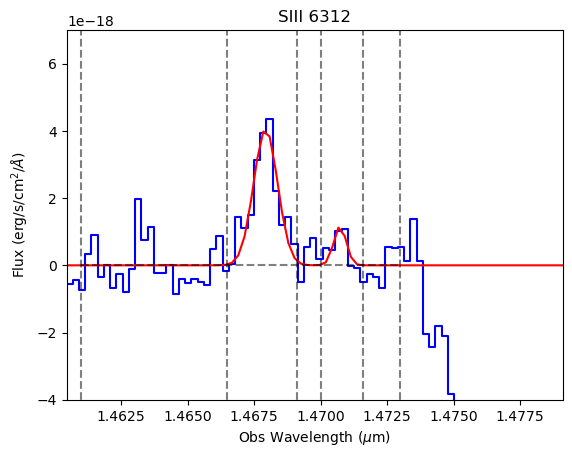

SIII 6312:  6.822299499287578e-18 3.5552400668955295e-18
OI 6300:  4.5650912394622446e-17 5.822465586315883e-18


In [20]:
# okay, the continuum subtraction for 6312 is not doing a great job. 
# So we're going to try a local subtraction and see how that goes

cont_bounds = [1.461,1.4665,1.4691,1.47,1.4716,1.473]

# make a Spectrum1D object for use with existing local cont sub fitting code
cgs = u.erg * u.cm**-2 * u.s**-1 * u.AA**-1
wlarray = df140.wave.to_numpy()*u.um
fluxarray = df140.flam.to_numpy()*cgs
fluxerrarray = StdDevUncertainty(df140.flamerr.to_numpy())
spectrum6312 = Spectrum1D(spectral_axis=wlarray, flux=fluxarray, uncertainty=fluxerrarray)

# make cont region, line region, and line param dict
cont_region = SpectralRegion(cont_bounds[0]*u.um,cont_bounds[1]*u.um)+SpectralRegion(cont_bounds[2]*u.um,cont_bounds[3]*u.um)
cont_region += SpectralRegion(cont_bounds[4]*u.um,cont_bounds[5]*u.um)

line_region = SpectralRegion(cont_bounds[1]*u.um,cont_bounds[4]*u.um)

line_params_6312 = {
    "amplitude": [1,1],
    "wavelength": [6314*(1+zsource),6300*(1+zsource)],
    "width": [1,1]

}

fluxlist, fluxerrlist, popt6312loc, pcov6312loc, contsub_spec6312loc = bws.cont_sub_curvefit(
                spectrum6312, cont_region, line_region, line_params_6312, verbose = True, scale=1e18)

f6312 = fluxlist[0]
ferr6312 = fluxerrlist[0]
f6300 = fluxlist[1]
ferr6300 = fluxerrlist[1]

fit6312 = bws.multigauss2(contsub_spec6312loc.spectral_axis.value, popt6312loc[0]/1e18,popt6312loc[1]/1e4,popt6312loc[2]/1e4,
                         popt6312loc[3]/1e18,popt6312loc[4]/1e4,popt6312loc[5]/1e4)

fig = plt.figure()

#plt.step(df140.wave, df140.flam, 'b-', where='mid')
#plt.step(df140.wave, df140.flam_autocont, 'r-', where='mid')
plt.step(contsub_spec6312loc.spectral_axis, contsub_spec6312loc.flux, 'b-', where='mid')
plt.plot(contsub_spec6312loc.spectral_axis, fit6312, 'r-')
plt.vlines(cont_bounds,-5e-18,1e-17,colors='k',linestyles='--', alpha=0.5)
plt.hlines(0,cont_bounds[0],cont_bounds[-1],colors='k',linestyles='--', alpha=0.5)
plt.xlabel('Obs Wavelength ($\mu$m)')
plt.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
plt.title('SIII 6312')
plt.xlim(0.627*(1+zsource), 0.635*(1+zsource))
plt.ylim(-4e-18,.7e-17)
plt.show()


print("SIII 6312: ", f6312, ferr6312)
print("OI 6300: ", f6300, ferr6300)
#idx = lines.index[lines['restwave']==6302.046][0] # OI
#lines.at[idx,'flux'] = f6300
#lines.at[idx, 'fluxerr'] = ferr6300
#idx = lines.index[lines['restwave']==6313.8][0] # SIII
#lines.at[idx,'flux'] = f6312
#lines.at[idx, 'fluxerr'] = ferr6312


In [34]:
popt6312loc, pcov6312loc

(array([1.17658181e+00, 1.47072410e+04, 2.52563529e+00, 4.03869780e+00,
        1.46793270e+04, 4.45184218e+00]),
 array([[ 1.44724492e-01, -5.42834507e-03, -2.07323888e-01,
         -2.99525622e-06,  1.46452842e-06,  7.66983714e-06],
        [-5.42834507e-03,  8.64389917e-01, -2.53713775e-02,
         -6.62555960e-06,  3.06293137e-06,  1.68933989e-05],
        [-2.07323888e-01, -2.53713775e-02,  8.74225619e-01,
          1.55106273e-05, -7.45624992e-06, -3.96657281e-05],
        [-2.99525622e-06, -6.62555960e-06,  1.55106273e-05,
          1.01130051e-01,  1.48759377e-03, -8.16102728e-02],
        [ 1.46452842e-06,  3.06293137e-06, -7.45624992e-06,
          1.48759377e-03,  1.82107271e-01, -3.76273401e-03],
        [ 7.66983714e-06,  1.68933989e-05, -3.96657281e-05,
         -8.16102728e-02, -3.76273401e-03,  1.99127487e-01]]))

In [35]:
print(fluxlist, fluxerrlist)

[7.448738049795314e-18, 4.5068287093736e-17] [3.661224806164356e-18, 5.744648761563174e-18]


In [21]:
# retry 6300,6312 fit with smaller aperture:
smallmask = os.path.join(maskdir, 'SGAS1723_oneclump_mask.fits')

# load in the spectrum!
dfsmol = tem.spec.integrate1D_mask(os.path.join(datadir, cubefile_g140h), 
                                   smallmask,
                                   zsource=1.3293)


In [22]:
boxsmol = tem.continuum.get_boxcar4autocont_nirspec('g140h','f100lp',zz=1.3293)
print(boxsmol)
contsmol = tem.continuum.fit_autocont(dfsmol, zz=1.3293, boxcar=box140, v2mask=300,
                                    colwave='wave', colf='flam', colcont='flam_autocont')

99


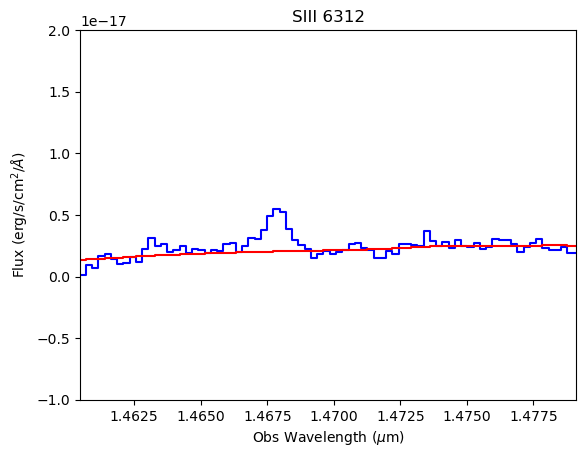

In [23]:
scale = 1e16
pars6312 = {
    "amplitude": [1,1],
    "wavelength": [6314*(1+zsource),6300*(1+zsource)],
    "width": [1,1]
}
#flux6312, fluxerr6312, popt, pcov = tem.spec.cont_sub_curvefit(df140, 
#                               line_region = [0.63*(1+zsource), 0.635*(1+zsource)], 
#                               line_param_dict = pars6312,
#                               verbose=True,
#                                obs_wl=True,
#                                scale=scale)

#fit6312 = tem.spec.multigauss(df140.wave, popt[0]/scale,popt[1]/1e4,popt[2]/1e4,
#                           popt[3]/scale,popt[4]/1e4,popt[5]/1e4)

#f6312 = flux6312[0]
#ferr6312 = fluxerr6312[0]
#f6300 = flux6312[1]
#ferr6300 = fluxerr6312[1]

fig = plt.figure()

#plt.errorbar(contsub4363.spectral_axis, contsub4363.flux.value, yerr=contsub4363.uncertainty.array, fmt='b-')
#plt.plot(df140.wave, fit6312, 'r-')
#plt.step(df140.wave, df140.flam - df140.flam_autocont, 'b-', where='mid')
plt.step(dfsmol.wave, dfsmol.flam, 'b-', where='mid')
plt.step(dfsmol.wave, dfsmol.flam_autocont, 'r-', where='mid')
#plt.step(spectrum_g140h.spectral_axis, spectrum_g140h.flux, 'g-', where='mid')
plt.xlabel('Obs Wavelength ($\mu$m)')
plt.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
plt.title('SIII 6312')
plt.xlim(0.627*(1+zsource), 0.635*(1+zsource))
plt.ylim(-1e-17, 0.2e-16)
plt.show()

#print("SIII 6312: ", f6312, ferr6312)
#print("OI 6300: ", f6300, ferr6300)
#idx = lines.index[lines['restwave']==6302.046][0] # OI
#lines.at[idx,'flux'] = f6300
#lines.at[idx, 'fluxerr'] = ferr6300
#idx = lines.index[lines['restwave']==6313.8][0] # SIII
#lines.at[idx,'flux'] = f6312
#lines.at[idx, 'fluxerr'] = ferr6312


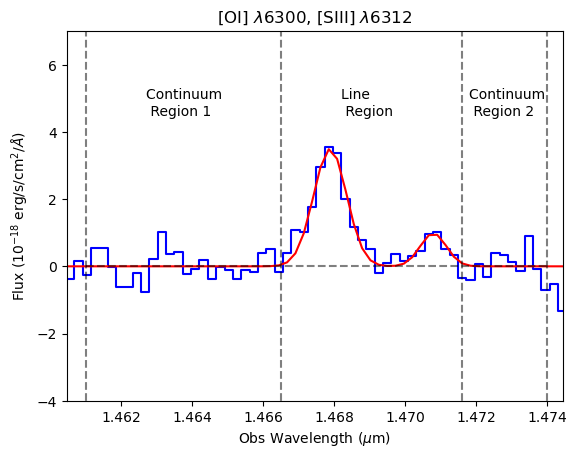

SIII 6312:  9.094074294298676e-18 2.1695501048997766e-18
OI 6300:  4.086350254209084e-17 2.511630514244452e-18


In [24]:
# okay, the continuum subtraction for 6312 is not doing a great job. 
# So we're going to try a local subtraction and see how that goes

cont_bounds = [1.461,1.4665,1.4716,1.474]#1.4691,1.47,

# make a Spectrum1D object for use with existing local cont sub fitting code
cgs = u.erg * u.cm**-2 * u.s**-1 * u.AA**-1
wlarray = dfsmol.wave.to_numpy()*u.um
fluxarray = dfsmol.flam.to_numpy()*cgs
fluxerrarray = StdDevUncertainty(dfsmol.flamerr.to_numpy())
spectrum6312 = Spectrum1D(spectral_axis=wlarray, flux=fluxarray, uncertainty=fluxerrarray)

# make cont region, line region, and line param dict
cont_region = SpectralRegion(cont_bounds[0]*u.um,cont_bounds[1]*u.um)+SpectralRegion(cont_bounds[2]*u.um,cont_bounds[3]*u.um)
#cont_region += SpectralRegion(cont_bounds[4]*u.um,cont_bounds[5]*u.um)

line_region = SpectralRegion(cont_bounds[1]*u.um,cont_bounds[2]*u.um) # 4

line_params_6312 = {
    "amplitude": [1,1],
    "wavelength": [6314*(1+zsource),6300*(1+zsource)],
    "width": [1,1]

}

fluxlist, fluxerrlist, popt6312loc, pcov6312loc, contsub_spec6312loc = bws.cont_sub_curvefit(
                spectrum6312, cont_region, line_region, line_params_6312, verbose = True, scale=1e18)

f6312 = fluxlist[0]
ferr6312 = fluxerrlist[0]
f6300 = fluxlist[1]
ferr6300 = fluxerrlist[1]

fit6312 = bws.multigauss2(contsub_spec6312loc.spectral_axis.value, popt6312loc[0]/1e18,popt6312loc[1]/1e4,popt6312loc[2]/1e4,
                         popt6312loc[3]/1e18,popt6312loc[4]/1e4,popt6312loc[5]/1e4)

fig = plt.figure()

#plt.step(df140.wave, df140.flam, 'b-', where='mid')
#plt.step(df140.wave, df140.flam_autocont, 'r-', where='mid')
plt.step(contsub_spec6312loc.spectral_axis, contsub_spec6312loc.flux*1e18, 'b-', where='mid')
plt.plot(contsub_spec6312loc.spectral_axis, fit6312*1e18, 'r-')
plt.vlines(cont_bounds,-5,10,colors='k',linestyles='--', alpha=0.5)
plt.hlines(0,cont_bounds[0],cont_bounds[-1],colors='k',linestyles='--', alpha=0.5)
plt.xlabel('Obs Wavelength ($\mu$m)')
plt.ylabel('Flux ($10^{-18}$ erg/s/cm$^2$/$\AA$)')
plt.text(1.4627, 4.5, 'Continuum \n Region 1') 
plt.text(1.4682, 4.5, 'Line \n Region')
plt.text(1.4718, 4.5, 'Continuum \n Region 2') 
plt.title('[OI] $\\lambda 6300$, [SIII] $\\lambda$6312')
plt.xlim(0.627*(1+zsource), 0.633*(1+zsource))
plt.ylim(-4,7)
plt.savefig('auroral/s3auroral_localfit.png')
plt.show()


print("SIII 6312: ", f6312, ferr6312)
print("OI 6300: ", f6300, ferr6300)
#idx = lines.index[lines['restwave']==6302.046][0] # OI
#lines.at[idx,'flux'] = f6300
#lines.at[idx, 'fluxerr'] = ferr6300
#idx = lines.index[lines['restwave']==6313.8][0] # SIII
#lines.at[idx,'flux'] = f6312
#lines.at[idx, 'fluxerr'] = ferr6312


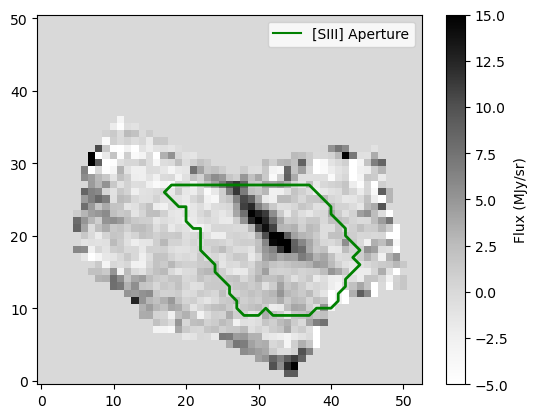

In [25]:
mask_oneclump = fits.open(os.path.join(maskdir, maskfile))[0].data

# tweak the mask:
mask_oneclump[27:,:] = 0

xx, yy = np.indices(mask_oneclump.shape)

cubedat = fits.open(os.path.join(datadir,cubefile_g140h))[1].data
slice = np.nansum(cubedat[2126:2136,:,:], axis=0)

cutout = slice*mask_oneclump

fig, ax = plt.subplots()

ims = ax.imshow(slice, origin='lower', vmin=-5, vmax=15, cmap='Greys')
ax.contour(yy, xx, mask_oneclump,[0], colors='g', linewidths=2)
plt.colorbar(ims, label='Flux (MJy/sr)')
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(-10,-10,'g-', label='[SIII] Aperture')
ax.legend()

plt.savefig('auroral/s3aperturev2.png')
plt.show()

3.278018825731005e-18 3.6395512839590145
2.1222106032195697e-16 3.9788350134506247
9.428859835776513e-18 -3.8382058220768593


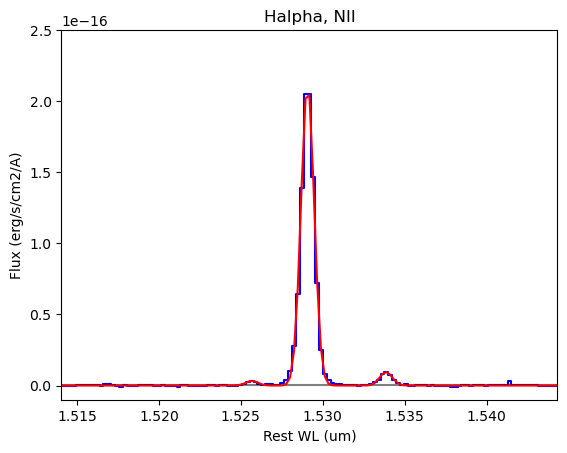

N2a flux,err: 2.9905372812393075e-17 1.0631287433008478e-17
N2b flux,err: 9.071463842039567e-17 1.1387654023031457e-17
Halpha flux,err: 2.1165783294539644e-15 1.7657388509395937e-17
6312/Halpha: 4.30e-03 +- 1.03e-03


In [26]:
# for comp with Strom+23, fit Halpha with smaller extraction cube: 
scale=1e16
lineHa = [0.652*(1+zsource), 0.66*(1+zsource)]#SpectralRegion(0.495*u.um, 0.502*u.um) 
param_dictHa = {
    "amplitude": [1,1,1],
    "wavelength": [6550*(1+zsource), 6564*(1+zsource), 6585*(1+zsource)],
    "width": [3, 1,1]
}

f,ferr,poptHa,pcovHa = tem.spec.cont_sub_curvefit(dfsmol,
                                                    lineHa,
                                                    line_param_dict=param_dictHa,
                                                    scale=scale,
                                                    obs_wl=True,
                                                    verbose=True)

fN2a = f[0]
fHa = f[1]
fN2b = f[2]
ferrN2a = ferr[0]
ferrHa = ferr[1]
ferrN2b = ferr[2]

fitresOIII = bws.multigauss2(dfsmol.wave, poptHa[0]/scale, poptHa[1]/1e4,
                     poptHa[2]/1e4, poptHa[3]/scale, poptHa[4]/1e4, poptHa[5]/1e4,
                            poptHa[6]/scale, poptHa[7]/1e4, poptHa[8]/1e4)

fig = plt.figure()

plt.step(dfsmol.wave, dfsmol.flam-dfsmol.flam_autocont, 'b-', where='mid')
plt.step(dfsmol.wave, dfsmol.flamerr, 'k-', where='mid', alpha=0.5)
#plt.plot(contsub7330.spectral_axis, fit7330(wlarray), 'r-')
#plt.plot(contsub7320.spectral_axis, fit7320(wlarray), 'r-')
plt.plot(dfsmol.wave, fitresOIII, 'r-')
plt.xlabel('Rest WL (um)')
plt.ylabel('Flux (erg/s/cm2/A)')
plt.title('Halpha, NII')
plt.xlim(0.65*(1+zsource), 0.663*(1+zsource))
plt.ylim(-1e-17, 0.25e-15)
plt.show()

print("N2a flux,err:",fN2a, ferrN2a)
print("N2b flux,err:",fN2b, ferrN2b)
#print("OIII ratio:", f5008/f4960)
print("Halpha flux,err:",fHa, ferrHa)

ratio = f6312/fHa
ratioerr = np.sqrt((ferr6312/f6312)**2 + (ferrHa/fHa)**2)*ratio
print(f'6312/Halpha: {ratio:.2e} +- {ratioerr:.2e}')

4.140682177273808e-18 3.6947377161512853
3.5516365377916346e-18 4.509529449199545


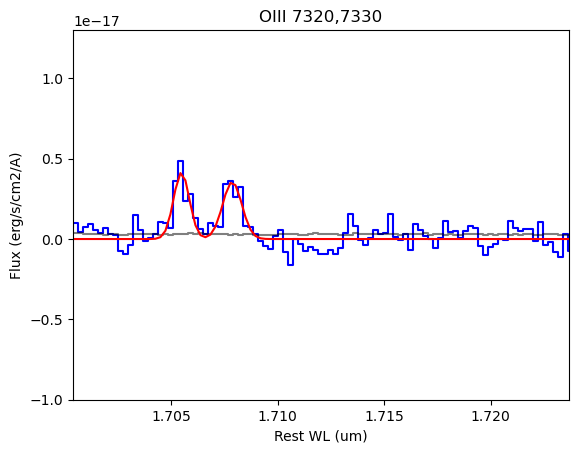

7320 flux,err: 3.8348240741930694e-17 7.952615819900786e-18
7330 flux,err: 4.014668373557271e-17 7.662220643708776e-18
OII ratio: 1.0468976661992102


In [27]:
scale=1e16
line7330 = [0.7318*(1+zsource), 0.734*(1+zsource)]#SpectralRegion(0.495*u.um, 0.502*u.um) 
paramsOII = [1, .7320*(1+zsource), 1, 1, .7330*(1+zsource), 2]
param_dictOII = {
    "amplitude": [1,1],
    "wavelength": [7322*(1+zsource), 7332*(1+zsource)],
    "width": [1, 1]
}

f,ferr,poptOII,pcovOII = tem.spec.cont_sub_curvefit(df140,
                                                            line7330,
                                                            line_param_dict=param_dictOII,
                                                            scale=scale,
                                                            obs_wl=True,
                                                            verbose=True)

f7320 = f[0]
f7330 = f[1]
ferr7320 = ferr[0]
ferr7330 = ferr[1]

fitOII = bws.multigauss2(df140.wave, poptOII[0]/scale, poptOII[1]/1e4,
                     poptOII[2]/1e4,poptOII[3]/scale,poptOII[4]/1e4, poptOII[5]/1e4)

fig = plt.figure()

plt.step(df140.wave, df140.flam-df140.flam_autocont, 'b-', where='mid')
plt.step(df140.wave, df140.flamerr, 'k-', where='mid', alpha=0.5)
#plt.plot(contsub7330.spectral_axis, fit7330(wlarray), 'r-')
#plt.plot(contsub7320.spectral_axis, fit7320(wlarray), 'r-')
plt.plot(df140.wave, fitOII, 'r-')
plt.xlabel('Rest WL (um)')
plt.ylabel('Flux (erg/s/cm2/A)')
plt.title('OIII 7320,7330')
plt.xlim(0.73*(1+zsource), 0.74*(1+zsource))
plt.ylim(-1e-17, 1.3e-17)
plt.show()

print("7320 flux,err:",f7320, ferr7320)
print("7330 flux,err:",f7330, ferr7330)
print("OII ratio:", f7330/f7320)
#idx = lines.index[lines['restwave']==7322.01][0] # OIIa
#lines.at[idx,'flux'] = f7320
#lines.at[idx, 'fluxerr'] = ferr7320
#idx = lines.index[lines['restwave']==7331.68][0] # OIIb
#lines.at[idx,'flux'] = f7330
#lines.at[idx, 'fluxerr'] = ferr7330


In [28]:
print('Amplitude,       Center (AA),       Sigma (AA)')
print(poptOII[:3])
print(poptOII[3:])

Amplitude,       Center (AA),       Sigma (AA)
[4.14068218e-02 1.70548194e+04 3.69473772e+00]
[3.55163654e-02 1.70786501e+04 4.50952945e+00]


In [18]:
10*(1+zsource)

23.293

In [19]:
perr = np.sqrt(np.diag(pcovOII))
perr,pcovOII

(array([0.00656617, 0.57394342, 0.56559271, 0.00496654, 0.70441167,
        0.7082588 ]),
 array([[ 4.31145551e-05, -1.23987716e-04,  2.11885070e-03,
         -9.32516287e-09, -8.21443693e-07,  2.54020417e-06],
        [-1.23987716e-04,  3.29411051e-01, -5.43360072e-02,
          8.61434858e-07,  7.24137061e-05, -2.32951385e-04],
        [ 2.11885070e-03, -5.43360072e-02,  3.19895119e-01,
         -1.67919521e-06, -1.45684702e-04,  4.56329075e-04],
        [-9.32516287e-09,  8.61434858e-07, -1.67919521e-06,
          2.46664998e-05,  8.24889474e-05, -2.00418287e-03],
        [-8.21443693e-07,  7.24137061e-05, -1.45684702e-04,
          8.24889474e-05,  4.96195799e-01, -1.96251978e-02],
        [ 2.54020417e-06, -2.32951385e-04,  4.56329075e-04,
         -2.00418287e-03, -1.96251978e-02,  5.01630526e-01]]))

In [20]:
f7320/fHb, f7330/fHb

(0.019556087438015114, 0.020600489718215872)

In [22]:
reload(tem.spec)

<module 'jwst_templates.spec' from '/Users/bdwelch1/code/jwst_templates/spec.py'>

4.443396923444989e-18 3.1410610893320325
4.095245274696122e-18 3.1410610893320325


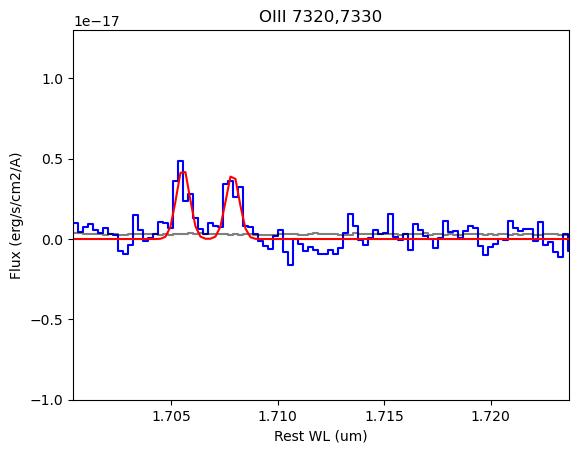

7320 flux,err: 3.498496365601212e-17 4.498789781234342e-18
7330 flux,err: 3.224380121022806e-17 3.795095025677373e-18
[4.44339692e-02 1.70555469e+04 3.14106109e+00 4.09524527e-02
 1.70788399e+04 3.14106109e+00]


In [29]:
# repeat OII auroral doublet fit with fixed sigmas
# and for funsies, try fixed line positions based on 7330 fit - 10AA rest = 23.3AA obs

scale=1e16
line7330 = [0.7318*(1+zsource), 0.734*(1+zsource)]#SpectralRegion(0.495*u.um, 0.502*u.um) 
medOIIIwidth = np.median([poptOIII[2],poptOIII[5]])
lam7330obs = 1.70788399e+04 #Angstroms
diffobs = 10 * (1+zsource)
param_dictOII = {
    "amplitude": [1,1],
    "wavelength": [lam7330obs-diffobs, lam7330obs], #[7320*(1+zsource), 7330*(1+zsource)],
    "width": [medOIIIwidth, medOIIIwidth]
}

f,ferr,poptOII,pcovOII = tem.spec.cont_sub_curvefit(df140,
                                                            line7330,
                                                            line_param_dict=param_dictOII,
                                                            scale=scale,
                                                            obs_wl=True,
                                                            verbose=True,
                                                   fixed=["width","wavelength"])

f7320 = f[0]
f7330 = f[1]
ferr7320 = ferr[0]
ferr7330 = ferr[1]

fitOII = bws.multigauss2(df140.wave, poptOII[0]/scale, poptOII[1]/1e4,
                     poptOII[2]/1e4,poptOII[3]/scale,poptOII[4]/1e4, poptOII[5]/1e4)

fig = plt.figure()

plt.step(df140.wave, df140.flam-df140.flam_autocont, 'b-', where='mid')
plt.step(df140.wave, df140.flamerr, 'k-', where='mid', alpha=0.5)
#plt.plot(contsub7330.spectral_axis, fit7330(wlarray), 'r-')
#plt.plot(contsub7320.spectral_axis, fit7320(wlarray), 'r-')
plt.plot(df140.wave, fitOII, 'r-')
plt.xlabel('Rest WL (um)')
plt.ylabel('Flux (erg/s/cm2/A)')
plt.title('OIII 7320,7330')
plt.xlim(0.73*(1+zsource), 0.74*(1+zsource))
plt.ylim(-1e-17, 1.3e-17)
plt.show()

print("7320 flux,err:",f7320, ferr7320)
print("7330 flux,err:",f7330, ferr7330)
print(poptOII)
idx = lines.index[lines['restwave']==7322.01][0] # OIIa
lines.at[idx,'flux'] = f7320
lines.at[idx, 'fluxerr'] = ferr7320
idx = lines.index[lines['restwave']==7331.68][0] # OIIb
lines.at[idx,'flux'] = f7330
lines.at[idx, 'fluxerr'] = ferr7330


In [25]:
bla = [(1, 17055.546899999998), (4, 17078.8399), (2, 3.1793630106352158), (5, 3.1793630106352158)]
sorted(bla)

[(1, 17055.546899999998),
 (2, 3.1793630106352158),
 (4, 17078.8399),
 (5, 3.1793630106352158)]

In [60]:
%matplotlib inline

7.090564809001216e-18 3.2307050617901565
5.173325751484936e-16 3.8854112308840802
2.1527050451413786e-17 3.593468165186352


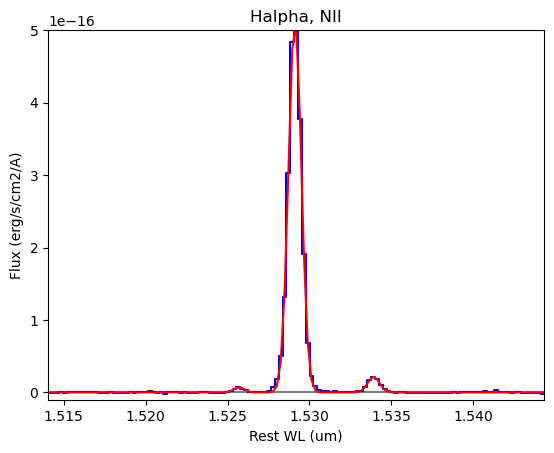

N2a flux,err: 5.742064640614391e-17 2.1108177068290484e-17
N2b flux,err: 1.9390466813814832e-16 2.1122026892940968e-17
Halpha flux,err: 5.038447656040723e-15 3.791879977362542e-17


In [30]:
scale=1e16
lineHa = [0.652*(1+zsource), 0.66*(1+zsource)]#SpectralRegion(0.495*u.um, 0.502*u.um) 
param_dictHa = {
    "amplitude": [1,1,1],
    "wavelength": [6550*(1+zsource), 6564*(1+zsource), 6585*(1+zsource)],
    "width": [3, 1,1]
}

f,ferr,poptHa,pcovHa = tem.spec.cont_sub_curvefit(df140,
                                                    lineHa,
                                                    line_param_dict=param_dictHa,
                                                    scale=scale,
                                                    obs_wl=True,
                                                    verbose=True)

fN2a = f[0]
fHa = f[1]
fN2b = f[2]
ferrN2a = ferr[0]
ferrHa = ferr[1]
ferrN2b = ferr[2]

fitresOIII = bws.multigauss2(df140.wave, poptHa[0]/scale, poptHa[1]/1e4,
                     poptHa[2]/1e4, poptHa[3]/scale, poptHa[4]/1e4, poptHa[5]/1e4,
                            poptHa[6]/scale, poptHa[7]/1e4, poptHa[8]/1e4)

fig = plt.figure()

plt.step(df140.wave, df140.flam-df140.flam_autocont, 'b-', where='mid')
plt.step(df140.wave, df140.flamerr, 'k-', where='mid', alpha=0.5)
#plt.plot(contsub7330.spectral_axis, fit7330(wlarray), 'r-')
#plt.plot(contsub7320.spectral_axis, fit7320(wlarray), 'r-')
plt.plot(df140.wave, fitresOIII, 'r-')
plt.xlabel('Rest WL (um)')
plt.ylabel('Flux (erg/s/cm2/A)')
plt.title('Halpha, NII')
plt.xlim(0.65*(1+zsource), 0.663*(1+zsource))
plt.ylim(-1e-17, 0.5e-15)
plt.show()

print("N2a flux,err:",fN2a, ferrN2a)
print("N2b flux,err:",fN2b, ferrN2b)
#print("OIII ratio:", f5008/f4960)
print("Halpha flux,err:",fHa, ferrHa)
idx = lines.index[lines['restwave']==6549.85][0] # NIIa
lines.at[idx,'flux'] = fN2a
lines.at[idx, 'fluxerr'] = ferrN2a
idx = lines.index[lines['restwave']==6585.28][0] # NIIb
lines.at[idx,'flux'] = fN2b
lines.at[idx, 'fluxerr'] = ferrN2b
idx = lines.index[lines['restwave']==6564.61][0] # Halpha
lines.at[idx,'flux'] = fHa
lines.at[idx, 'fluxerr'] = ferrHa


In [30]:
perr = np.sqrt(np.diag(pcovHa))
poptHa,perr,param_dictHa

(array([7.09056481e-02, 1.52569945e+04, 3.23070506e+00, 5.17332575e+00,
        1.52910916e+04, 3.88541123e+00, 2.15270505e-01, 1.53391144e+04,
        3.59346817e+00]),
 array([0.01776596, 0.92707431, 0.86902381, 0.02986758, 0.02093209,
        0.01875776, 0.01579816, 0.29124789, 0.28926896]),
 {'amplitude': [1, 1, 1],
  'wavelength': [15256.914999999999, 15289.5252, 15338.440499999999],
  'width': [3, 1, 1]})

In [31]:
print(f'7320/halpha: {f7320/fHa} +- {np.sqrt((ferr7320/f7320)**2 + (ferrHa/fHa)**2) * (f7320/fHa)}')
print(f'7330/halpha: {f7330/fHa} +- {np.sqrt((ferr7330/f7330)**2 + (ferrHa/fHa)**2) * (f7330/fHa)}')


7320/halpha: 0.006943599704577214 +- 0.0008944198989416705
7330/halpha: 0.006399550697241073 +- 0.0007547652518537034


2.267207354520589e-17 4.336562332347586
1.8163647076693835e-17 3.937421489156518


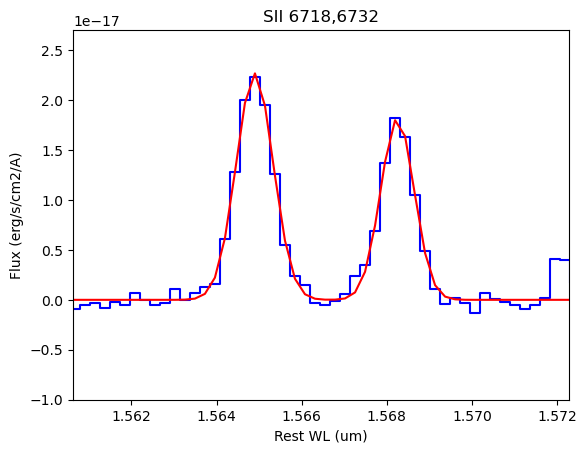

6718 flux,err: 2.4644883473724927e-16 1.052958284691362e-17
6732 flux,err: 1.7926887631279612e-16 1.0326149671265678e-17
SII ratio: 0.7274080906242593


In [31]:
scale=1e16
line6718 = [0.67*(1+zsource), 0.675*(1+zsource)]#SpectralRegion(0.495*u.um, 0.502*u.um) 
param_dictSII = {
    "amplitude": [1,1],
    "wavelength": [6718*(1+zsource), 6732*(1+zsource)],
    "width": [1, 1]
}

f,ferr,poptSII,pcovSII = tem.spec.cont_sub_curvefit(df140,
                                                            line6718,
                                                            line_param_dict=param_dictSII,
                                                            scale=scale,
                                                            obs_wl=True,
                                                            verbose=True)

f6718 = f[0]
f6732 = f[1]
ferr6718 = ferr[0]
ferr6732 = ferr[1]

fitSII = bws.multigauss2(df140.wave, poptSII[0]/scale, poptSII[1]/1e4,
                     poptSII[2]/1e4,poptSII[3]/scale,poptSII[4]/1e4, poptSII[5]/1e4)

fig = plt.figure()

plt.step(df140.wave, df140.flam-df140.flam_autocont, 'b-', where='mid')
#plt.plot(contsub7330.spectral_axis, fit7330(wlarray), 'r-')
#plt.plot(contsub7320.spectral_axis, fit7320(wlarray), 'r-')
plt.plot(df140.wave, fitSII, 'r-')
plt.xlabel('Rest WL (um)')
plt.ylabel('Flux (erg/s/cm2/A)')
plt.title('SII 6718,6732')
plt.xlim(0.67*(1+zsource), 0.675*(1+zsource))
plt.ylim(-1e-17, 2.7e-17)
plt.show()

print("6718 flux,err:",f6718, ferr6718)
print("6732 flux,err:",f6732, ferr6732)
print("SII ratio:", f6732/f6718)
idx = lines.index[lines['restwave']==6718.29][0] # SIIa
lines.at[idx,'flux'] = f6718
lines.at[idx, 'fluxerr'] = ferr6718
idx = lines.index[lines['restwave']==6732.67][0] # SIIb
lines.at[idx,'flux'] = f6732
lines.at[idx, 'fluxerr'] = ferr6732


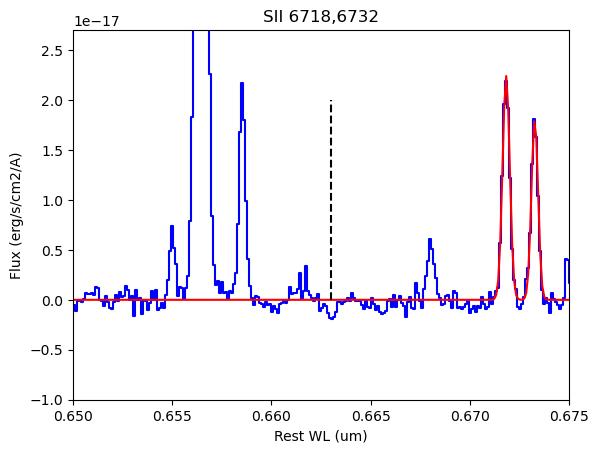

In [33]:
fig = plt.figure()

plt.step(df140.wave/(1+zsource), df140.flam-df140.flam_autocont, 'b-', where='mid')
#plt.plot(contsub7330.spectral_axis, fit7330(wlarray), 'r-')
#plt.plot(contsub7320.spectral_axis, fit7320(wlarray), 'r-')
plt.plot(df140.wave/(1+zsource), fitSII, 'r-')
plt.vlines(0.6630, 0, 2e-17, linestyle='--', color='k')
plt.xlabel('Rest WL (um)')
plt.ylabel('Flux (erg/s/cm2/A)')
plt.title('SII 6718,6732')
plt.xlim(0.65, 0.675)
plt.ylim(-1e-17, 2.7e-17)
plt.show()

1.2345684200967921e-17 3.9532044198905987


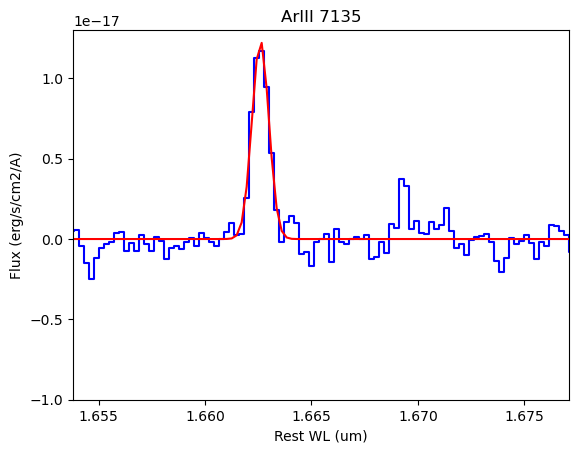

ArIII 7138 flux,err: 1.2233602640645218e-16 8.72651693917916e-18
[1.23456842e+00 1.66260317e+04 3.95320442e+00]


In [32]:
# Next up, fit [Ar III]! Get an Argon abundance!

scale=1e17
line7135 = [0.7130*(1+zsource), 0.7145*(1+zsource)]#SpectralRegion(0.495*u.um, 0.502*u.um) 
#medOIIIwidth = np.median([poptOIII[2],poptOIII[5]])
#lam7135obs = 1.70788399e+04 #Angstroms
#diffobs = 10 * (1+zsource)
param_dictArIII = {
    "amplitude": [1],
    "wavelength": [7138*(1+zsource)], #[7320*(1+zsource), 7330*(1+zsource)],
    "width": [2]
}

f,ferr,poptArIII,pcovArIII = tem.spec.cont_sub_curvefit(df140,
                                                            line7135,
                                                            line_param_dict=param_dictArIII,
                                                            scale=scale,
                                                            obs_wl=True,
                                                            verbose=True)#,
#                                                   fixed=["width","wavelength"])

f7135 = f[0]
#f7330 = f[1]
ferr7135 = ferr[0]
#ferr7330 = ferr[1]

fitArIII = bws.multigauss2(df140.wave, poptArIII[0]/scale, poptArIII[1]/1e4,
                     poptArIII[2]/1e4)

fig = plt.figure()

plt.step(df140.wave, df140.flam-df140.flam_autocont, 'b-', where='mid')
#plt.step(df140.wave, df140.flamerr, 'k-', where='mid', alpha=0.5)
plt.plot(df140.wave, fitArIII, 'r-')
plt.xlabel('Rest WL (um)')
plt.ylabel('Flux (erg/s/cm2/A)')
plt.title('ArIII 7135')
plt.xlim(0.71*(1+zsource), 0.72*(1+zsource))
plt.ylim(-1e-17, 1.3e-17)
plt.show()

print("ArIII 7138 flux,err:",f7135, ferr7135)
print(poptArIII)
idx = lines.index[lines['restwave']==7137.8][0] # ArIII 7135
lines.at[idx,'flux'] = f7135
lines.at[idx, 'fluxerr'] = ferr7135
#idx = lines.index[lines['restwave']==7331.68][0] # OIIb
#lines.at[idx,'flux'] = f7330
#lines.at[idx, 'fluxerr'] = ferr7330


3.043362799421439e-18 5.283542236215093


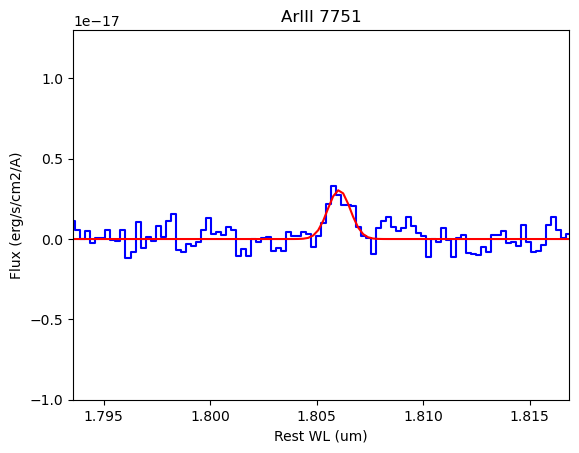

ArIII 7751 flux,err: 4.030592063265106e-17 8.049250882175319e-18
[3.04336280e-01 1.80605198e+04 5.28354224e+00]


In [33]:
# And the other argon line!!

scale=1e17
line7751 = [0.77*(1+zsource), 0.78*(1+zsource)]#SpectralRegion(0.495*u.um, 0.502*u.um) 
#medOIIIwidth = np.median([poptOIII[2],poptOIII[5]])
#lam7135obs = 1.70788399e+04 #Angstroms
#diffobs = 10 * (1+zsource)
param_dictArIII = {
    "amplitude": [1],
    "wavelength": [7753*(1+zsource)], #[7320*(1+zsource), 7330*(1+zsource)],
    "width": [2]
}

f,ferr,poptArIII,pcovArIII = tem.spec.cont_sub_curvefit(df140,
                                                            line7751,
                                                            line_param_dict=param_dictArIII,
                                                            scale=scale,
                                                            obs_wl=True,
                                                            verbose=True)#,
#                                                   fixed=["width","wavelength"])

f7751 = f[0]
#f7330 = f[1]
ferr7751 = ferr[0]
#ferr7330 = ferr[1]

fitArIII = bws.multigauss2(df140.wave, poptArIII[0]/scale, poptArIII[1]/1e4,
                     poptArIII[2]/1e4)

fig = plt.figure()

plt.step(df140.wave, df140.flam-df140.flam_autocont, 'b-', where='mid')
#plt.step(df140.wave, df140.flamerr, 'k-', where='mid', alpha=0.5)
plt.plot(df140.wave, fitArIII, 'r-')
plt.xlabel('Rest WL (um)')
plt.ylabel('Flux (erg/s/cm2/A)')
plt.title('ArIII 7751')
plt.xlim(0.77*(1+zsource), 0.78*(1+zsource))
plt.ylim(-1e-17, 1.3e-17)
plt.show()

print("ArIII 7751 flux,err:",f7751, ferr7751)
print(poptArIII)
idx = lines.index[lines['restwave']==7753.2][0] # ArIII 7751
lines.at[idx,'flux'] = f7751
lines.at[idx, 'fluxerr'] = ferr7751
#idx = lines.index[lines['restwave']==7331.68][0] # OIIb
#lines.at[idx,'flux'] = f7330
#lines.at[idx, 'fluxerr'] = ferr7330


In [51]:
9.3e-18 / 2.49e-16

0.03734939759036145

In [34]:
def get_uplim(spec, linereg, contreg, nsigma=3, 
              wavekey='wave', fluxkey='flam', contkey='flam_autocont'):
    '''
    Get upper limit for non-detected emission line
    calculate sum of pixels in linereg
    Npix = width of linereg
    calculate rolling sum of Npix in contreg (from min+Npix/2 to max-Npix/2)
    calculate standard deviation of rolling sums
    if sum(linereg) > nsigma * stddev: line exists
    else: uplim = nsigma*stddev
    '''
    linespec = spec[(spec[wavekey]>linereg[0]) & (spec[wavekey]<linereg[1])]
    linesum = sum(linespec[fluxkey]-linespec[contkey])
    npix = len(linespec)
    
    if len(contreg) == 2:
        contspec = spec[(spec[wavekey]>contreg[0]) & (spec[wavekey]<contreg[1])]
    elif len(contreg) == 4:
        contspec = spec[(spec[wavekey]>contreg[0]) & (spec[wavekey]<contreg[1]) 
                        | (spec[wavekey]>contreg[2]) & (spec[wavekey]<contreg[3])]
    
    halfpix = np.ceil(npix/2.)
    lowhalf = int(np.floor(npix/2.))
    contmin = int(halfpix) # maybe add some extra thing here later for increased generality?
    contmax = int(len(contspec) - halfpix)
    
    sums = []
    for i in range(contmin, contmax):
        sum_i = sum(contspec[fluxkey][i-lowhalf:i+lowhalf] - contspec[contkey][i-lowhalf:i+lowhalf])
        sums.append(sum_i)
        
    median_sums = np.median(np.abs(sums))
    std_sums = np.std(np.abs(sums))

    if linesum >= nsigma*std_sums:
        print(f"There's a line here!! Significance: {linesum/std_sums:.2f}. Go forth and fit it!")
        return 0
    else:
        return nsigma*std_sums

    #return linesum, median_sums, std_sums

In [35]:
n2_5755_uplim = get_uplim(df140, 
                          (0.5752*(1+zsource),0.5759*(1+zsource)), 
                          (0.57*(1+zsource),0.575*(1+zsource),0.576*(1+zsource),0.582*(1+zsource)))
s3_6312_uplim = get_uplim(df140, 
                          (0.63118*(1+zsource),0.63169*(1+zsource)), 
                          (0.632*(1+zsource),0.636*(1+zsource)))
ar4_4711_uplim = get_uplim(df140,
                           (0.47*(1+zsource),0.472*(1+zsource)),
                           (0.472*(1+zsource),0.48*(1+zsource)))
print(n2_5755_uplim)
print(s3_6312_uplim)
print(ar4_4711_uplim)
idx = lines.index[lines['restwave']==5756.240][0] # NII
lines.at[idx, 'flux'] = n2_5755_uplim
lines.at[idx, 'fluxerr'] = -1

4.4582346992394326e-18
2.3979198446065455e-18
1.1502411814685515e-17


In [49]:
# come up with a way to turn this into a latex table at some point, then it can easily be updated if needed
lines

,restwave,label,plotlabel,reference,flux,fluxerr,dered_flux,dered_fluxerr,final_flux,final_fluxerr
0,1908.73400,CIII],r'C~III]~1909',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
1,3727.09200,[OII],r'[O~II]~3727',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
2,3729.87500,[OII],r'[O~II]~3730',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
3,3869.86000,[NeIII],r'[Ne~III]',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
4,3839.18000,HeI,r'He~I~3839',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
5,3890.15100,H8,r'H8',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
6,3968.59300,[NeIII],r'[Ne~III]~3969',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
7,3971.19500,Hepsilon,r'H$\epsilon$',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
8,4025.11705,HeI,r'He~I~4025',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
9,4102.89200,Hdelta,r'H$\delta$',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0


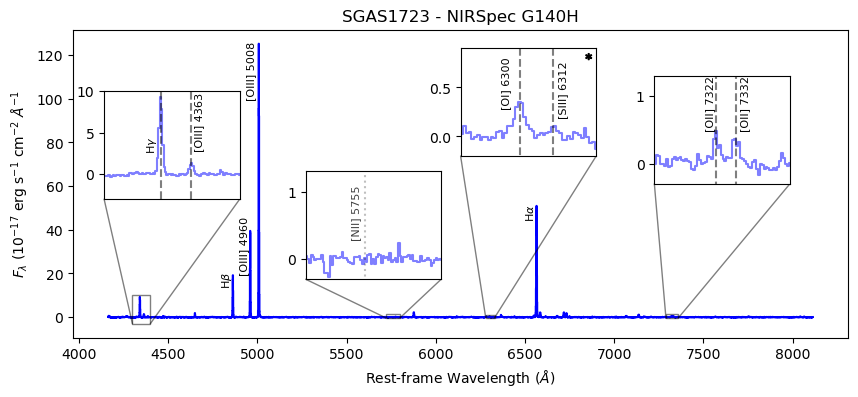

In [151]:
# nice-ish line fit figure:
# start w/ full spectrum, include zoom-in boxes for each auroral line, w/ fits for all but NII

fig, ax = plt.subplots(figsize=(10,4))

ax.step(df140.rest_wave*1e4, (df140.flam-df140.flam_autocont)*1e17, 'b-', where='mid')
#ax.set_ylim(-5e-17,3e-16)
ax.set_xlabel("Rest-frame Wavelength ($\AA$)")
ax.set_ylabel('$F_{\lambda}$ ($10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$')
ax.set_title('SGAS1723 - NIRSpec G140H')
ax.text(5008-70, 100, '[OIII] 5008', fontsize=8, rotation='vertical') 
ax.text(4960-60, 20, '[OIII] 4960', fontsize=8, rotation='vertical') 
ax.text(4861-70, 15, 'H$\\beta$', fontsize=8, rotation='vertical') 
ax.text(6565-70, 45, 'H$\\alpha$', fontsize=8, rotation='vertical') 

axins1 = ax.inset_axes([0.04,0.45,0.175,0.35])
#axins1.plot(df140.rest_wave, fit4363, 'r-')
axins1.step(df140.rest_wave*1e4, (df140.flam - df140.flam_autocont)*1e17, 'b-', where='mid', alpha=0.5)
#plt.step(spectrum_g140h.spectral_axis, spectrum_g140h.flux, 'g-', where='mid')
#axins1.xlabel('Rest-frame Wavelength ($\mu$m)')
#axins1.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
axins1.text(.4366*1e4,3,'[OIII] 4363',fontsize=8,rotation='vertical')
axins1.text(.433*1e4,3,'H$\gamma$',fontsize=8,rotation='vertical')
axins1.vlines([.434168*1e4,.4364*1e4],-3, 10, linestyles='dashed',colors='k',alpha=0.5)
axins1.set_xlim(0.43*1e4, 0.44*1e4)
axins1.set_xticks([])
axins1.set_ylim(-3, 10)
ax.indicate_inset_zoom(axins1,edgecolor='k')


axins3 = ax.inset_axes([0.5,0.59,0.175,0.35])
#axins3.plot(df140.rest_wave, fit6312, 'r-')
#axins3.step(df140.rest_wave*1e4, (df140.flam - df140.flam_autocont)*1e17, 'b-', where='mid', alpha=0.5)
axins3.step(dfsmol.rest_wave*1e4, contsub_spec6312loc.flux*1e17, 'b-', where='mid', alpha=0.5) #(dfsmol.flam - dfsmol.flam_autocont)
#plt.step(spectrum_g140h.spectral_axis, spectrum_g140h.flux, 'g-', where='mid')
#axins1.xlabel('Rest-frame Wavelength ($\mu$m)')
#axins1.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
axins3.text(.6316*1e4,0.2,'[SIII] 6312',fontsize=8,rotation='vertical')
axins3.text(.6295*1e4,0.3,'[OI] 6300',fontsize=8,rotation='vertical')
axins3.vlines([.6302*1e4,.6314*1e4],-3, 10, linestyles='dashed',colors='k',alpha=0.5)
axins3.set_xlim(0.628*1e4, 0.633*1e4)
axins3.set_ylim(-0.2, 0.9)
axins3.set_xticks([])
axins3.plot(6327,0.8,color='k',marker='$*$',markersize=7)
ax.indicate_inset_zoom(axins3,edgecolor='k')


axins4 = ax.inset_axes([0.75,0.5,0.175,0.35])
#axins4.plot(df140.rest_wave, fitOII, 'r-')
axins4.step(df140.rest_wave*1e4, (df140.flam - df140.flam_autocont)*1e17, 'b-', where='mid', alpha=0.5)
#plt.step(spectrum_g140h.spectral_axis, spectrum_g140h.flux, 'g-', where='mid')
#axins1.xlabel('Rest-frame Wavelength ($\mu$m)')
#axins1.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
axins4.text(.7316*1e4,0.5,'[OII] 7322',fontsize=8,rotation='vertical')
axins4.text(.7334*1e4,0.5,'[OII] 7332',fontsize=8,rotation='vertical')
axins4.vlines([.7322*1e4,.7332*1e4],-3, 10, linestyles='dashed',colors='k',alpha=0.5)
axins4.set_xlim(0.729*1e4, 0.736*1e4)
axins4.set_ylim(-.3, 1.3)
axins4.set_xticks([])
ax.indicate_inset_zoom(axins4,edgecolor='k')


axins5 = ax.inset_axes([0.3,0.19,0.175,0.35])
#axins3.plot(df140.rest_wave, fit6312, 'r-')
axins5.step(df140.rest_wave*1e4, (df140.flam - df140.flam_autocont)*1e17, 'b-', where='mid', alpha=0.5)
#plt.step(spectrum_g140h.spectral_axis, spectrum_g140h.flux, 'g-', where='mid')
#axins1.xlabel('Rest-frame Wavelength ($\mu$m)')
#axins1.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
axins5.text(.5747*1e4,0.3,'[NII] 5755',fontsize=8,rotation='vertical', alpha=0.75)
axins5.vlines(.5755*1e4,-3, 10, linestyles=':',colors='k',alpha=0.25)
axins5.set_xlim(0.572*1e4, 0.58*1e4)
axins5.set_ylim(-.3, 1.3)
axins5.set_xticks([])
ax.indicate_inset_zoom(axins5,edgecolor='k')



#plt.savefig('auroral/sgas1723_g140_stackcube_v3.png')
plt.show()

In [28]:
o3_sum = lines.loc[lines['restwave']==5008.24]['flux'].values[0] + lines.loc[lines['restwave']==4960.295]['flux'].values[0]
hbeta = lines.loc[lines['restwave']==4862.683]['flux'].values[0]
halpha = lines.loc[lines['restwave']==6564.61]['flux'].values[0]
o3hbeta = o3_sum / hbeta
print(o3hbeta)
print(halpha/hbeta)

8.372354055198832
3.2400168220822496


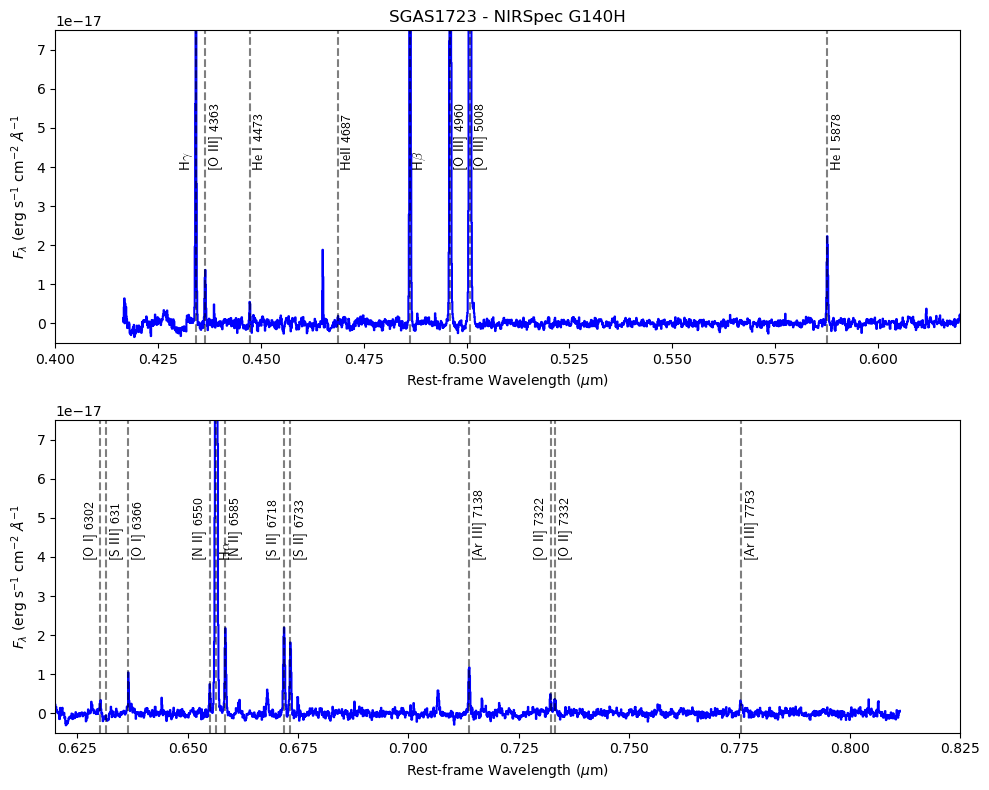

In [40]:
# make line label plot:

fig, ax = plt.subplots(2,1,figsize=(10,8))

ax[0].step(df140.rest_wave, df140.flam-df140.flam_autocont, 'b-', where='mid')
ax[0].set_ylim(-5e-18,0.75e-16)
ax[0].set_xlim(0.4,0.62)
ax[0].set_xlabel("Rest-frame Wavelength ($\mu$m)")
ax[0].set_ylabel('$F_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$')
ax[0].set_title('SGAS1723 - NIRSpec G140H')
# add lines and labels
ylo, yhi = ax[0].get_ylim()
for i in range(len(lines)):
    line = lines.iloc[i]
    wl = line['restwave'] * 1e-4 # to um
    if (wl < 0.62) & (wl > 0.435):
        label = line['plotlabel'][2:-1]
        if label == '[Ar~IV]': continue
        elif label == '[N~II]~5756': continue
        elif label == '[O~III]~5579': continue
        else:
            ax[0].vlines(wl,ylo,yhi,linestyles='--',colors='k', alpha=0.5)
            ax[0].text(wl+0.0007,4e-17,label,rotation='vertical', usetex=True)
    elif (wl > 0.42) & (wl < 0.435):
        label = line['plotlabel'][2:-1]
        ax[0].vlines(wl,ylo,yhi,linestyles='--',colors='k', alpha=0.5)
        ax[0].text(wl-0.004,4e-17,label,rotation='vertical', usetex=True)

ax[1].step(df140.rest_wave, df140.flam-df140.flam_autocont, 'b-', where='mid')
ax[1].set_ylim(-5e-18,0.75e-16)
ax[1].set_xlim(0.62,0.825)
ax[1].set_xlabel("Rest-frame Wavelength ($\mu$m)")
ax[1].set_ylabel('$F_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$')
for i in range(len(lines)):
    line = lines.iloc[i]
    wl = line['restwave'] * 1e-4 # to um
    if wl == .6302046:
        label = line['plotlabel'][2:-1]
        ax[1].vlines(wl,ylo,yhi,linestyles='--',colors='k', alpha=0.5)
        ax[1].text(wl-0.004,4e-17,label,rotation='vertical', usetex=True)
    if (wl > 0.6303) & (wl < 0.825):
        label = line['plotlabel'][2:-1]
        if label == '[O~I]~6393': continue
        elif label == '[S~II]~6718':
            ax[1].vlines(wl,ylo,yhi,linestyles='--',colors='k', alpha=0.5)
            ax[1].text(wl-0.004,4e-17,label,rotation='vertical', usetex=True)
        elif label == '[O~II]~7322':
            ax[1].vlines(wl,ylo,yhi,linestyles='--',colors='k', alpha=0.5)
            ax[1].text(wl-0.004,4e-17,label,rotation='vertical', usetex=True)
        elif label == '[N~II]~6550':
            ax[1].vlines(wl,ylo,yhi,linestyles='--',colors='k', alpha=0.5)
            ax[1].text(wl-0.004,4e-17,label,rotation='vertical', usetex=True)
        elif label == 'H$\alpha$':
            ax[1].vlines(wl,ylo,yhi,linestyles='--',colors='k', alpha=0.5)
            ax[1].text(wl+0.004,4e-17,label,rotation='vertical', usetex=True)
        else:
            ax[1].vlines(wl,ylo,yhi,linestyles='--',colors='k', alpha=0.5)
            ax[1].text(wl+0.0007,4e-17,label,rotation='vertical', usetex=True)

plt.tight_layout()
#plt.savefig('sgas1723_linelabel_v2.png')
plt.show()

# Stand back, I'm going to try pyneb!
We'll see how this goes. Have a fire extinguisher ready.

In [4]:
import pyneb as pn

In [5]:
# define some functions to get uncertainties on temp, density, abundance:
# written by Danielle Berg, provided by Grace Olivier

# GET_TEMDEN_ERR: Determine the direct temp or dens for a given line ratio + error
#         INPUTS:       key - which diagnostic you are using
#                     ratio - line ratio corresponding to the diagnostic key
#                 ratio_err - uncertainty on the diagnostic line ratio
#                     niter - how many random samplings of a normal distribution with
#                             (center,width) = (ratio,ratio_err) to use in calculation
#
#----------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------
def get_temden_err(key, ratio, ratio_err, temdenin, niter, verbose=False):
    temdeno = np.zeros([niter])
    x       = np.random.normal(ratio, ratio_err, niter)
    # tem diagnostics:
    if key == 'Ne3':
        temdeno = Ne3.getTemDen(x,den=temdenin,wave1=3868,wave2=3342)
    if key == 'O3':
        temdeno = O3.getTemDen(x,den=temdenin,wave1=4363,wave2=5007)
    if key == 'O3uv':
        temdeno = O3.getTemDen(x,den=temdenin,wave1=1666,wave2=5007)
    if key == 'N2':
        temdeno = N2.getTemDen(x,den=temdenin,wave1=5755,wave2=6584)
    if key == 'S3':
        temdeno = S3.getTemDen(x,den=temdenin,wave1=6312,wave2=9532)
    if key == 'S2':
        temdeno = S2.getTemDen(x,den=temdenin,to_eval='(L(4069)+L(4076))/(L(6717)+L(6731))')
    if key == 'O2':
        temdeno = O2.getTemDen(x,den=temdenin,to_eval='(L(3726)+L(3729))/(L(7319)+L(7320)+L(7331)+L(7333))')
    # den diagnostics:
    if key == 'NS2':
        temdeno = S2.getTemDen(x,tem=temdenin,wave1=6717,wave2=6731)
    if key == 'Ar4':
        temdeno = Ar4.getTemDen(x,tem=temdenin,wave1=4711,wave2=4740)
    if key == 'C3':
        temdeno = C3.getTemDen(x,tem=temdenin,wave1=1907,wave2=1909)
    if key == 'Si3':
        temdeno = Si3.getTemDen(x,tem=temdenin,wave1=1883,wave2=1892)
    if key == 'Cl3':
        temdeno = Cl3.getTemDen(x,tem=temdenin,wave1=5517,wave2=5537)
    if verbose:
        return  np.median(temdeno[(np.nan_to_num(temdeno) > 0.)]), np.std(temdeno[(np.nan_to_num(temdeno) > 0.)]), temdeno
    else:
        return  np.median(temdeno[(np.nan_to_num(temdeno) > 0.)]), np.std(temdeno[(np.nan_to_num(temdeno) > 0.)])
#----------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------
"""
GET_IABUND_ERR: Determine an ion abundance and error due to flux unc and emis unc (temp)
        INPUTS:       key - which ion you are using
                      rat - emission line intensity corresponding to the ion key
                     rate - uncertainty rat
                      lam - wavelength of the emission line of interest
                     dens - electron density for the ion of interest
                      tem - electron temperature for the ion of interest
                     teme - uncertainty on tem
		OUTPUTS:     abund, err
"""
def get_iabund_err(key, lam, ratio, ratio_err, dens, tem, teme):
    niter = 1000
    iabund = np.zeros([niter])
    x      = np.random.normal(ratio, ratio_err, niter)
    y      = np.random.normal(tem,   teme,      niter)
    z      = y*0. + dens
    if key == 'O4':   iabund = O4.getIonAbundance (int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'O3':   iabund = O3.getIonAbundance (int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'O2b':  iabund = O2.getIonAbundance (int_ratio=x*100,tem=y,den=z,to_eval='L(3726)+L(3728)')
    if key == 'O2r':  iabund = O2.getIonAbundance( int_ratio=x*100,tem=y,den=z,
                                                  to_eval='L(7319)+L(7320)+L(7331)+L(7332)')
    if key == 'O1':   iabund = O1.getIonAbundance( int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'N3':   iabund = N3.getIonAbundance( int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'N2':   iabund = N2.getIonAbundance( int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'S3':   iabund = S3.getIonAbundance( int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'S2':   iabund = S2.getIonAbundance( int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'Ne3':  iabund = Ne3.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'Ne2':  iabund = N32.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'Ar4':  iabund = Ar4.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'Ar3':  iabund = Ar3.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'C3':   iabund = C3.getIonAbundance( int_ratio=x*100,tem=y,den=z,to_eval='L(1907)+L(1909)')
    if key == 'C4':   iabund = C4.getIonAbundance( int_ratio=x*100,tem=y,den=z,to_eval='L(1548)+L(1550)')
    if key == 'Fe2':  iabund = Fe2.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'Fe3':  iabund = Fe3.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'Fe4':  iabund = Fe4.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'Fe5':  iabund = Fe5.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    return  np.median(iabund[(np.nan_to_num(iabund) > 0.)]), np.std(iabund[(np.nan_to_num(iabund) > 0.)])

In [6]:
# From Danielle Berg's code - check if these are any different from the default?
DataFileDict = {'O2':  {'atom':'o_ii_atom_FFT04.dat',  'coll':'o_ii_coll_Kal09.dat'},
                'O3':  {'atom':'o_iii_atom_FFT04.dat', 'coll':'o_iii_coll_AK99.dat'},
                #'O3':  {'atom':'o_iii_atom_FFT04.dat', 'coll':'o_iii_coll_TZ17.dat'},
                'N2':  {'atom':'n_ii_atom_FFT04.dat',  'coll':'n_ii_coll_T11.dat'},
                #'Ne3': {'atom':'ne_iii_atom_FFT04.dat','coll':'ne_iii_coll_McLB00.dat'},
                'Ar3': {'atom':'ar_iii_atom_MZ83.dat', 'coll':'ar_iii_coll_MB09.dat'},#,
                #'S2':  {'atom':'s_ii_atom_PKW09.dat',  'coll':'s_ii_coll_TZ10.dat'},
                #'S3':  {'atom':'s_iii_atom_PKW09.dat', 'coll':'s_iii_coll_HRS12.dat'}
                'S3':  {'atom':'s_iii_atom_FFTI06.dat', 'coll':'s_iii_coll_HRS12.dat'}}
pn.atomicData.setDataFileDict(DataFileDict)

In [7]:
# define some atoms! these will be good to have later
# Low Ionization:
O2  = pn.Atom('O',2)
N2  = pn.Atom('N',2)
S2  = pn.Atom('S',2)
# High Ionization:
O3 = pn.Atom('O',3)
S3 = pn.Atom('S',3)
Ar3 = pn.Atom('Ar',3)

In [8]:
# are defaults different from Danielle's preferred files??
print(O3.atomFile, O3.collFile)
print(O2.atomFile, O2.collFile)
print(S3.atomFile, S3.collFile)
print(S2.atomFile, S2.collFile)
print(N2.atomFile, N2.collFile)
print(Ar3.atomFile, Ar3.collFile)

o_iii_atom_FFT04.dat o_iii_coll_AK99.dat
o_ii_atom_FFT04.dat o_ii_coll_Kal09.dat
s_iii_atom_FFTI06.dat s_iii_coll_HRS12.dat
s_ii_atom_RGJ19.dat s_ii_coll_TZ10.dat
n_ii_atom_FFT04.dat n_ii_coll_T11.dat
ar_iii_atom_MZ83.dat ar_iii_coll_MB09.dat


In [9]:
O3.printSources()
print()
O2.printSources()
print()
S3.printSources()
print()
S2.printSources()
print()
N2.printSources()
print()
Ar3.printSources()

O3: A-values from all levels: Froese Fischer et al 2004, ADNDT 87, 1: 
O3: Energy levels: 
    Ref. 7288 of NIST 2014 (try this: http://physics.nist.gov/cgi-bin/ASBib1/get_ASBib_ref.cgi?db=el&db_id=7288&comment_code=&element=O&spectr_charge=3&): 
O3: All collision strengths: Aggarwal and Keenan 1999, ApJS 123, 311: 

O2: A-values from all levels: Froese Fischer et al 2004, ADNDT 87, 1: 
O2: Energy levels: 
    Ref. 11267 of NIST 2014 (try this: http://physics.nist.gov/cgi-bin/ASBib1/get_ASBib_ref.cgi?db=el&db_id=11267&comment_code=&element=O&spectr_charge=2&): 
O2: All collision strengths: Kisielius et al 2009, MNRAS, 397, 903: 

S3: All energy and A values: Froese Fischer, C., G. Tachiev, and A. Irimia, 2006, At. Data Nucl. Data Tables 92, 607 cited by Podobedova, Kelleher, and Wiese 2009, J. Phys. Chem. Ref. Data, Vol.: 
S3: Energy levels: 
    Ref. 7237 of NIST 2014 (try this: http://physics.nist.gov/cgi-bin/ASBib1/get_ASBib_ref.cgi?db=el&db_id=7237&comment_code=&element=S&spectr_ch

In [56]:
#from dustmaps.config import config
#config.reset()

In [57]:
# Galactic dust correction!
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarWebQuery

RV = 3.1

bayestar = BayestarWebQuery(version='bayestar2019') # originally was 2015, but use 2019 for now

ra, dec = 260.9017, 34.1986 # center of 
coo = SkyCoord(ra, dec, frame='fk5', unit='deg')
gal_ebv = np.max(bayestar(coo, mode='median'))
print(gal_ebv)
gc  = pn.RedCorr(E_BV = gal_ebv, law ='CCM89')
#fgc  = flux[:,j]*gc.getCorr(wave)
#fgce = err[:,j]*gc.getCorr(wave) 

0.03


In [58]:
zsource = 1.3293
for i,line in lines.iterrows():
    flx = line['flux']
    flxer = line['fluxerr']
    wl = line['restwave']
    if flx != 0:
        # QUESTION! - do I need to redshift these lines? 
        # probably? Because this is galactic extinction from the milky way?
        dred = flx*gc.getCorr(wl*(1+zsource))
        dreder = dred*np.sqrt((flxer/flx)**2 + (gc.getErrCorr(wl*(1+zsource),0.01)/gc.getCorr(wl*(1+zsource)))**2)
        lines.at[i,'dered_flux'] = dred
        lines.at[i,'dered_fluxerr'] = dreder
        

In [59]:
# now get internal gas dust correction (probably very low)
# first, get theoretical Ha/Hb ratio
H1 = pn.RecAtom('H', 1)
Hbeta_t1 = H1.getEmissivity(tem=1e4, den=1e2, lev_i=4, lev_j=2)
Halpha_t1 = H1.getEmissivity(tem=1e4, den=1e2, lev_i=3, lev_j=2)
print('HaHb',Halpha_t1/Hbeta_t1)
HaHb_t1 = Halpha_t1/Hbeta_t1
Hgamma_t1 = H1.getEmissivity(tem=1e4, den=1e2, lev_i=5, lev_j=2)
HbHg_t1 = Hbeta_t1/Hgamma_t1
print('HbHg',HbHg_t1)

# now what is the actual ratio?
dered_hbeta = lines.loc[lines['restwave']==4862.683]['flux'].values[0]
dered_halpha = lines.loc[lines['restwave']==6564.61]['flux'].values[0]
print('measHaHb',dered_halpha/dered_hbeta)
meas_HaHb = dered_halpha/dered_hbeta
# add Hbeta/Hgamma measured ratio
dered_hgamma = lines.loc[lines['restwave']==4341.684]['flux'].values[0]
meas_HbHg = dered_hbeta / dered_hgamma
print('measHbHg',meas_HbHg)
print(dered_hgamma,dered_hbeta)

rc = pn.RedCorr(E_BV = gal_ebv, law ='CCM89')
ebv_hahb = rc.setCorr(obs_over_theo=meas_HaHb / HaHb_t1, wave1=6563., wave2=4861.) # = ebv_hahb
print(f'E(B-V), Halpha/Hbeta: {rc.E_BV}')
print(rc.getCorr(5008))
# add ebv_hbhg = setCorr(hbeta / hgamma)
#rc2 = pn.RedCorr(E_BV = 0, law='CCM89')
rc.setCorr(obs_over_theo=meas_HbHg / HbHg_t1, wave1=4861., wave2=4341.)
ebv_hbhg = rc.E_BV
print(f'E(B-V), Hbeta/Hgamma: {ebv_hbhg}')

# calculate error-weighted average E(B-V)
dered_halpha_err = lines.loc[lines['restwave']==6564.61]['fluxerr'].values[0]
dered_hbeta_err = lines.loc[lines['restwave']==4862.683]['fluxerr'].values[0]
dered_hgamma_err = lines.loc[lines['restwave']==4341.684]['fluxerr'].values[0]
err_HaHb = np.sqrt((dered_halpha_err/dered_halpha)**2 + (dered_hbeta_err/dered_hbeta)**2)
err_HbHg = np.sqrt((dered_hbeta_err/dered_hbeta)**2 + (dered_hgamma_err/dered_hgamma)**2)
print(err_HaHb)
print(err_HbHg)
w_HaHb = err_HaHb / (err_HaHb + err_HbHg)
w_HbHg = err_HbHg / (err_HaHb + err_HbHg)
print(w_HaHb, w_HbHg)

HaHb 2.863157894736842
HbHg 2.1352005532503457
measHaHb 3.2397881011169765
measHbHg 2.232187912004698
6.967057471821771e-16 1.555178147084257e-15
E(B-V), Halpha/Hbeta: 0.12490869585947426
1.4909506260353385
E(B-V), Hbeta/Hgamma: 0.08551557740750979
0.023219630998324754
0.026000169192463743
0.47175386548339376 0.5282461345166063


In [60]:
# get initial temp measurement
dered_o3_4363 = lines.loc[lines['restwave']==4364.436]['dered_flux'].values[0] * rc.getCorr(4364.436)
dered_o3_4363_err = lines.loc[lines['restwave']==4364.436]['dered_fluxerr'].values[0] * rc.getCorr(4364.436)
dered_o3_5007 = lines.loc[lines['restwave']==5008.24]['dered_flux'].values[0] * rc.getCorr(5008.24)
dered_o3_5007_err = lines.loc[lines['restwave']==5008.24]['dered_fluxerr'].values[0] * rc.getCorr(5008.24)
to3r = dered_o3_4363 / dered_o3_5007
to3re = np.sqrt((dered_o3_4363_err/dered_o3_4363)**2 + (dered_o3_5007_err/dered_o3_5007)**2) * to3r
to3n = O3.getTemDen(int_ratio=to3r, den=100., wave1=4364, wave2=5008)
print(f'5007/4363 ratio: {to3r} +- {to3re}')
print(f'T_O3: {to3n}')

5007/4363 ratio: 0.012326614089339024 +- 0.0011664819560561234
T_O3: 12350.47639234869


In [62]:
# get initial density measurement
dered_s2_6717 = lines.loc[lines['restwave']==6718.29]['dered_flux'].values[0] * rc.getCorr(6718.29)
dered_s2_6717_err = lines.loc[lines['restwave']==6718.29]['dered_fluxerr'].values[0] * rc.getCorr(6718.29)
dered_s2_6731 = lines.loc[lines['restwave']==6732.67]['dered_flux'].values[0] * rc.getCorr(6732.67)
dered_s2_6731_err = lines.loc[lines['restwave']==6732.67]['dered_fluxerr'].values[0] * rc.getCorr(6732.67)
ns2r = dered_s2_6717 / dered_s2_6731
ns2re = np.sqrt((dered_s2_6717_err/dered_s2_6717)**2 + (dered_s2_6731_err/dered_s2_6731)**2)*ns2r
ns2 = S2.getTemDen(int_ratio=ns2r, tem=to3n, wave1=6718, wave2=6732)
print(f'6717/6731: {ns2r} +- {ns2re}')
print(f'N_S2: {ns2}')

6717/6731: 1.3755689481808389 +- 0.09865263996119764
N_S2: 71.54949699377588


In [63]:
delta_t = 100

# define initial state for loop
to3i = to3n
ns2i = ns2
rci = rc
ebvi = rci.E_BV

while delta_t > 10:
    Hbeta_ti = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=4, lev_j=2)
    Halpha_ti = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=3, lev_j=2)
    HaHb_ti = Halpha_ti/Hbeta_ti
    Hgamma_ti = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=5, lev_j=2)
    HbHg_ti = Hbeta_ti/Hgamma_ti
    
    # now what is the actual ratio?
    dered_hbeta_i = lines.loc[lines['restwave']==4862.683]['dered_flux'].values[0] * rci.getCorr(4862.683)
    dered_halpha_i = lines.loc[lines['restwave']==6564.61]['dered_flux'].values[0] * rci.getCorr(6564.61)
    meas_HaHb_i = dered_halpha_i/dered_hbeta_i
    dered_hgamma_i = lines.loc[lines['restwave']==4341.684]['dered_flux'].values[0] * rci.getCorr(4341.684)
    meas_HbHg_i = dered_hbeta_i/dered_hgamma_i
    # and get uncertainties on these ratios
    dered_hbeta_err_i = lines.loc[lines['restwave']==4862.683]['dered_fluxerr'].values[0] * rci.getCorr(4862.683)
    dered_halpha_err_i = lines.loc[lines['restwave']==6564.61]['dered_fluxerr'].values[0] * rci.getCorr(6564.61)
    dered_hgamma_err_i = lines.loc[lines['restwave']==4341.684]['dered_fluxerr'].values[0] * rci.getCorr(4341.684)

    rci = pn.RedCorr(E_BV = ebvi, law ='CCM89')
    rci.setCorr(obs_over_theo=meas_HaHb_i / HaHb_ti, wave1=6563., wave2=4861.)
    ebv_hahb_i = rci.E_BV
    rci.setCorr(obs_over_theo=meas_HbHg_i / HbHg_ti, wave1=4861., wave2=4341.)
    ebv_hbhg_i = rci.E_BV

    # get weighted avg for new E(B-V)
    err_HaHb_i = np.sqrt((dered_halpha_err_i/dered_halpha_i)**2 + (dered_hbeta_err_i/dered_hbeta_i)**2)
    err_HbHg_i = np.sqrt((dered_hbeta_err_i/dered_hbeta_i)**2 + (dered_hgamma_err_i/dered_hgamma_i)**2)
    w_HaHb_i = 1 - (err_HaHb_i / (err_HaHb_i + err_HbHg_i))
    w_HbHg_i = 1 - (err_HbHg_i / (err_HaHb_i + err_HbHg_i))

    ebvi = (w_HaHb_i*ebv_hahb_i + w_HbHg_i*ebv_hbhg_i) / (w_HaHb_i+w_HbHg_i) 
    rci = pn.RedCorr(E_BV=ebvi, law='CCM89')

    dered_o3_4363_i = lines.loc[lines['restwave']==4364.436]['dered_flux'].values[0] * rci.getCorr(4364.436)
    dered_o3_5007_i = lines.loc[lines['restwave']==5008.24]['dered_flux'].values[0] * rci.getCorr(5008.24)
    to3ri = dered_o3_4363_i / dered_o3_5007_i
    to3ip1 = O3.getTemDen(int_ratio=to3ri, den=ns2i, wave1=4364, wave2=5008)
    delta_t = np.abs(to3ip1 - to3i)
    #print(delta_t)
    to3i = O3.getTemDen(int_ratio=to3ri, den=ns2i, wave1=4364, wave2=5008)
    dered_s2_6717_i = lines.loc[lines['restwave']==6718.29]['dered_flux'].values[0] * rci.getCorr(6718.29)
    dered_s2_6731_i = lines.loc[lines['restwave']==6732.67]['dered_flux'].values[0] * rci.getCorr(6732.67)
    ns2ri = dered_s2_6717_i / dered_s2_6731_i
    ns2i = S2.getTemDen(int_ratio=ns2ri, tem=to3i, wave1=6718, wave2=6732)

    
    


In [64]:
# get uncertainty in E(B-V)

Hbeta_ti = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=4, lev_j=2)
Halpha_ti = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=3, lev_j=2)
HaHb_ti = Halpha_ti/Hbeta_ti
Hgamma_ti = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=5, lev_j=2)
HbHg_ti = Hbeta_ti/Hgamma_ti

# now what is the actual ratio?
dered_hbeta = lines.loc[lines['restwave']==4862.683]['dered_flux'].values[0]
dered_halpha = lines.loc[lines['restwave']==6564.61]['dered_flux'].values[0] 
meas_HaHb = dered_halpha/dered_hbeta
dered_hgamma = lines.loc[lines['restwave']==4341.684]['dered_flux'].values[0] 
meas_HbHg = dered_hbeta/dered_hgamma
# and get uncertainties on these ratios
dered_hbeta_err = lines.loc[lines['restwave']==4862.683]['dered_fluxerr'].values[0]
dered_halpha_err = lines.loc[lines['restwave']==6564.61]['dered_fluxerr'].values[0]
dered_hgamma_err = lines.loc[lines['restwave']==4341.684]['dered_fluxerr'].values[0]

err_HaHb = np.sqrt((dered_halpha_err/dered_halpha)**2 + (dered_hbeta_err/dered_hbeta)**2)
err_HbHg = np.sqrt((dered_hbeta_err/dered_hbeta)**2 + (dered_hgamma_err/dered_hgamma)**2)

w_HaHb = 1 - (err_HaHb_i / (err_HaHb_i + err_HbHg_i))
w_HbHg = 1 - (err_HbHg_i / (err_HaHb_i + err_HbHg_i))

range_HaHb = np.random.normal(meas_HaHb, err_HaHb, 100)
range_HbHg = np.random.normal(meas_HbHg, err_HbHg, 100)

ebv_range = []
for i, j in zip(range_HaHb, range_HbHg):
    rcerr = pn.RedCorr(E_BV=0, law='CCM89')
    rcerr.setCorr(HaHb_ti / i, wave1=6563., wave2=4861.)
    ebv_hahb = rcerr.E_BV
    rcerr.setCorr(HbHg_ti / j, wave1=4861., wave2=4341.)
    ebv_hbhg = rcerr.E_BV
    ebvi = (w_HaHb*ebv_hahb + w_HbHg*ebv_hbhg) / (w_HaHb+w_HbHg)
    ebv_range.append(ebvi)

ebv_err = np.std(ebv_range)
print(f'E(B-V) = {rci.E_BV} +- {ebv_err}')

E(B-V) = 0.051250014901241425 +- 0.010757076675363048


In [65]:
rci.getCorr(4363), rci.getErrCorr(4363,ebv_err)

(1.2162913817859724, 0.0021063042218666876)

In [66]:
print(to3i, ns2i, rci.E_BV, rci.getCorr(5008))
ha_v2 = lines.loc[lines['restwave']==6564.61]['dered_flux'].values[0] * rci.getCorr(6564.61)
hb_v2 = lines.loc[lines['restwave']==4862.683]['dered_flux'].values[0] * rci.getCorr(4862.683)
hg_v2 = lines.loc[lines['restwave']==4341.684]['dered_flux'].values[0] * rci.getCorr(4341.684)

hat = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=3, lev_j=2)
hbt = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=4, lev_j=2)
hgt = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=5, lev_j=2)

print()
print('Halpha Ratios:')
print('Measure: ',ha_v2/hb_v2)
print('Theory: ',hat/hbt)
print()
print('Measure: ',hg_v2/hb_v2)
print('Theory: ',hgt/hbt)


# now apply this internal galaxy deredening!
for i,line in lines.iterrows():
    flx = line['flux']
    flxer = line['fluxerr']
    wl = line['restwave']
    if flx != 0:
        dred = flx*rci.getCorr(wl)
        dreder = dred*np.sqrt((flxer/flx)**2 + (rci.getErrCorr(wl,ebv_err)/rci.getCorr(wl))**2)#flxer*rci.getCorr(wl)
        lines.at[i,'final_flux'] = dred
        lines.at[i,'final_fluxerr'] = dreder
  

12255.529394310435 73.18921461198543 0.051250014901241425 1.17807229938038

Halpha Ratios:
Measure:  3.0464990459437025
Theory:  2.82458629328322

Measure:  0.46271156963335297
Theory:  0.4708404747075654


In [10]:
lines

NameError: name 'lines' is not defined

#### calculate spatially-integrated strong-line metallicities for Grace's paper

In [3]:
from scipy.optimize import brentq

def Z_logO3S2(x,logO3S2):
    y = 0.191 -logO3S2 - 4.292*x - 2.538*x**2 + 0.053*x**3 + 0.332*x**4
    return y

def Z_logN2(x, logN2):
    y = -0.489 - logN2 + 1.513*x - 2.554*x**2 - 5.293*x**3 - 2.867*x**4
    return y

def Z_logS2(x, logS2):
    y = -0.442 - logS2 - 0.36*x - 6.271*x**2 -8.339*x**3 - 3.559*x**4
    return y 

def Z_logO3N2(x, logO3N2):
    y = 0.281 - logO3N2 - 4.765*x - 2.268*x**2
    return y

o3_5007 = lines.loc[lines['restwave']==5008.24]['final_flux'].values[0] 
o3_5007_err = lines.loc[lines['restwave']==5008.24]['final_fluxerr'].values[0] 
o3_4959 = lines.loc[lines['restwave']==4960.295]['final_flux'].values[0]
o3_4959_err = lines.loc[lines['restwave']==4960.295]['final_fluxerr'].values[0]

s2_6717 = lines.loc[lines['restwave']==6718.29]['final_flux'].values[0]
s2_6717_err = lines.loc[lines['restwave']==6718.29]['final_fluxerr'].values[0]
s2_6731 = lines.loc[lines['restwave']==6732.67]['final_flux'].values[0] 
s2_6731_err = lines.loc[lines['restwave']==6732.67]['final_fluxerr'].values[0] 

n2_6585 = lines.loc[lines['restwave']==6585.28]['final_flux'].values[0]
n2_6585_err = lines.loc[lines['restwave']==6585.28]['final_fluxerr'].values[0]

ha = lines.loc[lines['restwave']==6564.61]['final_flux'].values[0]
ha_err = lines.loc[lines['restwave']==6564.61]['final_fluxerr'].values[0]
hb = lines.loc[lines['restwave']==4862.683]['final_flux'].values[0]
hb_err = lines.loc[lines['restwave']==4862.683]['final_fluxerr'].values[0]

logO3S2 = np.log10((o3_5007/hb)*ha/(s2_6717+s2_6731))
c20_logO3S2_loh = brentq(Z_logO3S2,-1,0,args=(np.log10((o3_5007/hb)*ha/(s2_6717+s2_6731))))
o3s2err1 = (o3_5007_err/o3_5007)**2 + (hb_err/hb)**2
o3s2err2 = (ha_err/ha)**2 + (s2_6717_err/s2_6717)**2 + (s2_6731_err/s2_6731)**2
logO3S2_loh_err = (1./np.log(10)) * np.sqrt(o3s2err1 + o3s2err2) 
zo3s2err = np.sqrt((logO3S2_loh_err/logO3S2)**2 + (0.11/(c20_logO3S2_loh+8.69))**2) * (c20_logO3S2_loh+8.69)
print(f'log(O3S2) = {logO3S2} +- {logO3S2_loh_err}')
print(f'O3S2: 12+log(O/H) = {c20_logO3S2_loh + 8.69:.2f} +- {zo3s2err:.2f}')

logN2 = np.log10(n2_6585/ha)
c20_logN2_loh = brentq(Z_logN2,-1,0,args=(np.log10(n2_6585/ha)))
logN2_err = (1./np.log(10)) * np.sqrt((n2_6585_err/n2_6585)**2 + (ha_err/ha)**2)
zn2err = np.sqrt((logN2_err/logN2)**2 + (0.1/(c20_logN2_loh+8.69))**2) * (c20_logN2_loh + 8.69)
print(f'log(N2) = {np.log10(n2_6585/ha)} +- {logN2_err}')
print(f'N2: 12+log(O/H) = {c20_logN2_loh + 8.69:.2f} +- {zn2err:.2f}')

logS2 = np.log10((s2_6717+s2_6731)/ha)
c20_logS2_loh = brentq(Z_logS2,-1,0,args=(logS2))
logS2_err = (1./np.log(10)) * np.sqrt((s2_6717_err/s2_6717)**2 + (s2_6731_err/s2_6731)**2 + (ha_err/ha)**2)
zs2err = np.sqrt((logS2_err/logS2)**2 + (0.1/(c20_logS2_loh+8.69))**2) * (c20_logS2_loh + 8.69)
print(f'log(S2) = {logS2} +- {logS2_err}')
print(f'S2: 12+log(O/H) = {c20_logS2_loh+8.69:.2f} +- {zs2err:.2f}')

logO3N2 = np.log10((o3_5007/hb)*(ha/n2_6585))
c20_logO3N2_loh = brentq(Z_logO3N2,-1,0,args=(logO3N2))
O3N2err1 = (o3_5007_err/o3_5007)**2 + (hb_err/hb)**2
O3N2err2 = (n2_6585_err/n2_6585)**2 + (ha_err/ha)**2
logO3N2err = (1./np.log(10)) * np.sqrt(O3N2err1 + O3N2err2)
zo3n2err = np.sqrt((logO3N2err/logO3N2)**2 + (0.21/(c20_logO3N2_loh+8.69))**2) * (c20_logO3N2_loh+8.69)
print(f'log(O3N2) = {logO3N2} +- {logO3N2err}')
print(f'O3N2: 12+log(O/H) = {c20_logO3N2_loh+8.69:.2f} +- {zo3n2err:.2f}')

NameError: name 'lines' is not defined

In [116]:
logN2_err

0.047425618325362996

In [8]:
n2ha = .05
logN2 = np.log10(n2ha)
c20_logN2_loh = brentq(Z_logN2,-1,0,args=(np.log10(n2ha)))
#logN2_err = (1./np.log(10)) * np.sqrt((n2_6585_err/n2_6585)**2 + (ha_err/ha)**2)
#zn2err = np.sqrt((logN2_err/logN2)**2 + (0.1/(c20_logN2_loh+8.69))**2) * (c20_logN2_loh + 8.69)
print(f'log(N2) = {np.log10(n2ha)} +- {0}')
print(f'N2: 12+log(O/H) = {c20_logN2_loh + 8.69:.2f} +- {0:.2f}')


log(N2) = -1.3010299956639813 +- 0
N2: 12+log(O/H) = 8.25 +- 0.00


In [154]:
import entomology.bwutils as butil
reload(butil)

printlines = lines.copy()
printlines['flux'] *= 1e17
printlines['fluxerr'] *= 1e17
printlines['final_flux'] *= 1e17
printlines['final_fluxerr'] *= 1e17


rowsused0 = [9,10,14,15,16,18,20,21,22,23,24,25,26,29,30,31]
rowsused = [row+1 for row in rowsused0]
colsused = ['plotlabel', 'restwave', 'flux', 'fluxerr', 'final_flux', 'final_fluxerr']
fmts = ['str', '.2f', '.2f', '.2f', '.2f', '.2f']

butil.write2latex(printlines, rows=rowsused, cols=colsused, fmt=fmts, outfile='s1723fluxtable.tex')

'H$\\gamma$ & $4341.68$ &$69.67 \\pm 0.97$ & $84.89 \\pm 1.19$  \\\\ \n[O~III]~4363 & $4364.44$ &$11.34 \\pm 1.07$ & $13.80 \\pm 1.30$  \\\\ \nH$\\beta$ & $4862.68$ &$155.52 \\pm 3.42$ & $184.49 \\pm 4.06$  \\\\ \n[O~III]~4960 & $4960.30$ &$325.48 \\pm 3.83$ & $384.43 \\pm 4.56$  \\\\ \n[O~III]~5008 & $5008.24$ &$976.50 \\pm 5.66$ & $1150.99 \\pm 6.85$  \\\\ \n[N~II]~5756 & $5756.24$ &$0.45 \\pm -100000000000000000.00$ & $0.51 \\pm 114948508236834384.00$  \\\\ \n[O~I]~6302 & $6302.05$ &$0.00 \\pm 0.00$ & $0.00 \\pm 0.00$  \\\\ \n[S~III]~631 & $6313.80$ &$0.00 \\pm 0.00$ & $0.00 \\pm 0.00$  \\\\ \n[N~II]~6550 & $6549.85$ &$5.74 \\pm 2.11$ & $6.48 \\pm 2.38$  \\\\ \nH$\\alpha$ & $6564.61$ &$503.84 \\pm 3.79$ & $568.09 \\pm 4.32$  \\\\ \n[N~II]~6585 & $6585.28$ &$19.39 \\pm 2.11$ & $21.85 \\pm 2.38$  \\\\ \n[S~II]~6718 & $6718.29$ &$23.76 \\pm 1.08$ & $26.70 \\pm 1.22$  \\\\ \n[S~II]~6733 & $6732.67$ &$17.68 \\pm 1.07$ & $19.85 \\pm 1.20$  \\\\ \n[Ar~III]~7138 & $7137.80$ &$12.23 \\pm 0.8

#### Get Te(OIII4363), N(SII)

In [68]:
# get initial temp measurement
dered_o3_4363 = lines.loc[lines['restwave']==4364.436]['final_flux'].values[0] 
dered_o3_4363_err = lines.loc[lines['restwave']==4364.436]['final_fluxerr'].values[0] 
dered_o3_5007 = lines.loc[lines['restwave']==5008.24]['final_flux'].values[0] 
dered_o3_5007_err = lines.loc[lines['restwave']==5008.24]['final_fluxerr'].values[0] 
dered_o3_4959 = lines.loc[lines['restwave']==4960.295]['final_flux'].values[0] 
dered_o3_4959_err = lines.loc[lines['restwave']==4960.295]['final_fluxerr'].values[0] 
to3r = dered_o3_4363 / dered_o3_5007
to3re = np.sqrt((dered_o3_4363_err/dered_o3_4363)**2 + (dered_o3_5007_err/dered_o3_5007)**2) * to3r
to3n = O3.getTemDen(int_ratio=to3r, den=100., wave1=4364, wave2=5008)
print(f'5007/4363 ratio: {to3r} +- {to3re}')
print(f'T_O3: {to3n}')

5007/4363 ratio: 0.011986283918763203 +- 0.0011345965732320988
T_O3: 12216.001190787456


In [69]:
to3r = dered_o3_4363 / dered_o3_5007
#to3r *= 2
to3re = np.sqrt((dered_o3_4363_err/dered_o3_4363)**2 + (dered_o3_5007_err/dered_o3_5007)**2) * to3r
to3n = O3.getTemDen(int_ratio=to3r, den=100., wave1=4364, wave2=5008)
print(f'5007/4363 ratio: {to3r} +- {to3re}')
print(f'T_O3: {to3n}')
dered_Hbeta = lines.loc[lines['restwave']==4862.683]['final_flux'].values[0]
dered_Hbeta_err = lines.loc[lines['restwave']==4862.683]['final_fluxerr'].values[0]
o3_hbeta = dered_o3_4363 / dered_Hbeta
o3abund = O3.getIonAbundance(int_ratio=o3_hbeta*100, tem=to3n, den=ns2, wave=4363)
print(f'OIII Abundance: {o3abund}')

5007/4363 ratio: 0.011986283918763203 +- 0.0011345965732320988
T_O3: 12216.001190787456
OIII Abundance: 0.00012056920381794525


In [70]:
# get initial density measurement
dered_s2_6717 = lines.loc[lines['restwave']==6718.29]['final_flux'].values[0] 
dered_s2_6717_err = lines.loc[lines['restwave']==6718.29]['final_fluxerr'].values[0] 
dered_s2_6731 = lines.loc[lines['restwave']==6732.67]['final_flux'].values[0] 
dered_s2_6731_err = lines.loc[lines['restwave']==6732.67]['final_fluxerr'].values[0] 
ns2r = dered_s2_6717 / dered_s2_6731
ns2re = np.sqrt((dered_s2_6717_err/dered_s2_6717)**2 + (dered_s2_6731_err/dered_s2_6731)**2)*ns2r
ns2 = S2.getTemDen(int_ratio=ns2r, tem=to3n, wave1=6718, wave2=6732)
print(f'6717/6731: {ns2r} +- {ns2re}')
print(f'N_S2: {ns2}')

6717/6731: 1.3751907277512085 +- 0.09864866111030798
N_S2: 73.18921461198543


In [71]:
NS2, NS2e, NS2full = get_temden_err('NS2', ns2r, ns2re, to3n, 300, verbose=True)
print(f'N[SII]: {NS2} +- {NS2e}')
print(np.percentile(NS2full[np.nan_to_num(NS2full)>0.], [16,50,84]))


N[SII]: 103.90748878039275 +- 105.7311491158783
[ 31.83997013 103.90748878 241.8721363 ]


In [72]:
# set N(S2) = 100 for future calculations:
ns2 = 100
NS2 = 100

In [73]:
dered_Hbeta = lines.loc[lines['restwave']==4862.683]['final_flux'].values[0]
dered_Hbeta_err = lines.loc[lines['restwave']==4862.683]['final_fluxerr'].values[0]
o3_hbeta = dered_o3_5007 / dered_Hbeta
o3abund = O3.getIonAbundance(int_ratio=o3_hbeta*100, tem=to3n, den=ns2, wave=5007)
print(f'OIII Abundance: {o3abund}')

OIII Abundance: 0.0001203570548661816


In [74]:
#print(to3r, to3re)
TO3, TO3e = get_temden_err('O3', to3r, to3re, ns2, 300)
print(f'T_e[OIII]: {to3n} +- {TO3e}')
o3r = dered_o3_5007 / dered_Hbeta
o3re = np.sqrt((dered_o3_5007_err/dered_o3_5007)**2 + (dered_Hbeta_err/dered_Hbeta)**2) * o3r
o3 = get_iabund_err('O3', 5007, o3r, o3re, NS2, TO3, TO3e)
print(f'O++/H: {o3abund} +- {o3[1]}')

T_e[OIII]: 12216.001190787456 +- 437.83974694410034
O++/H: 0.0001203570548661816 +- 1.3418615625660881e-05


In [75]:
# now get Te(OIII) from the HST data, using our deredening:
# first write out the line measurements (in erg/s/cm2):
o3_1660_jr = 1.7e-17
o3_1660_jr_err = 0.4e-17
o3_1666_jr = 5e-17
o3_1666_jr_err = 1e-17
o3_4363_jr = 2.8e-17
o3_4363_jr_err = 6e-17
o3_4959_jr = 258e-17
o3_4959_jr_err = 4e-17
o3_5007_jr = 767e-17
o3_5007_jr_err = 11e-17
jr_hbeta = 142e-17
jr_hbeta_err = 4e-17
#make dict for easy nonsense
jr_lineslist = [o3_1660_jr,o3_1666_jr,o3_4363_jr,o3_4959_jr,o3_5007_jr,jr_hbeta]
jr_lines_err = [o3_1660_jr_err,o3_1666_jr_err,o3_4363_jr_err,o3_4959_jr_err,o3_5007_jr_err,jr_hbeta_err]
jr_waves = [1660,1666,4363,4959,5007,4862]
jr_lines = {'obs':jr_lineslist, 'obserr':jr_lines_err, 'wave':jr_waves,'dered':[],'derederr':[]}
# dered
for i in range(len(jr_lineslist)):
    fobs = jr_lines['obs'][i]
    fobserr = jr_lines['obserr'][i]
    wl = jr_lines['wave'][i]
    drd = fobs*rci.getCorr(wl)
    drderr = fobs*np.sqrt((fobserr/fobs)**2 + (rci.getErrCorr(wl,ebv_err)/rci.getCorr(wl)))#fobserr*rci.getCorr(wl)
    jr_lines['dered'].append(drd)
    jr_lines['derederr'].append(drderr)
# now we can get the Te measurements!
# first 4363, cuz I have that code already (woohoo!)
to3r_jr = jr_lines['dered'][2] / jr_lines['dered'][4] # 4363/5007
to3re_jr = np.sqrt((jr_lines['derederr'][2]/jr_lines['dered'][2])**2 + (jr_lines['derederr'][4]/jr_lines['dered'][4])**2)
to3re_jr *= to3r_jr
TO3_jr, TO3_jre = get_temden_err('O3', to3r_jr, to3re_jr, NS2, 300)
print(f'T_e[OIII]4363: {TO3_jr} +- {TO3_jre}')
o3r_jr = jr_lines['dered'][4] / jr_lines['dered'][5]
o3re_jr = np.sqrt((jr_lines['derederr'][5]/jr_lines['dered'][5])**2 + (jr_lines['derederr'][4]/jr_lines['dered'][4])**2)
o3re_jr *= o3r_jr
o3_jr = get_iabund_err('O3', 5007, o3r_jr, o3re_jr, NS2, TO3_jr, TO3_jre)
print(f'O++/H: {o3_jr[0]} +- {o3_jr[1]}')
# next up, the 1666 temperature! 'O3uv' for get_temden_err
o3uvr = (jr_lines['dered'][1]) / jr_lines['dered'][4]
o3uvre = np.sqrt((jr_lines['derederr'][1]/jr_lines['dered'][1])**2 + (jr_lines['derederr'][4]/jr_lines['dered'][4])**2)
o3uvre *= o3uvr
TO3_uv, TO3_uve = get_temden_err('O3uv', o3uvr, o3uvre, NS2, 300)
print(f'T_e[OIII]UV: {TO3_uv} +- {TO3_uve}')

T_e[OIII]4363: 9804.974573226258 +- 2422.997580972329
O++/H: 0.00019517393198748066 +- 2.299098557617501
T_e[OIII]UV: 11022.907450968587 +- 335.1525587935426


In [76]:
# fiddling with O3UV extinction
o3r = dered_o3_5007 / dered_Hbeta
o3re = np.sqrt((dered_o3_5007_err/dered_o3_5007)**2 + (dered_Hbeta_err/dered_Hbeta)**2) * o3r
o3uv = get_iabund_err('O3', 5007, o3r, o3re, NS2, TO3_uv, TO3_uve)
print(f'O++/H (UV): {o3uv[0]} +- {o3uv[1]}')

# from Jane's paper:
o2_3727_r = 76e-17 # erg/s/cm^2, from "flux" column of Rigby+2021, using Keck/ESI
o2_3727_re = 0.7e-17 # "fluxerr" column of Rigby+2021, using Keck/ESI
o2_3729_r = 107e-17 # erg/s/cm^2, from "flux" column of Rigby+2021, using Keck/ESI
o2_3729_re = 0.7e-17 # "fluxerr" column of Rigby+2021, using Keck/ESI
hbeta_r = 142e-17 # erg/s/cm^2, from "flux" column of Rigby+2021
hbeta_re = 4e-17

# apply same deredenning as above:
dered_3727_r = o2_3727_r * gc.getCorr(3727*(1+zsource)) * rci.getCorr(3727)
#dered_3727_re = o2_3727_re * gc.getCorr(3727*(1+zsource)) * rci.getCorr(3727)
dered_3727_re = o2_3727_r * np.sqrt((o2_3727_re/o2_3727_r)**2 + (rci.getErrCorr(3727,ebv_err)/rci.getCorr(3727))**2)
dered_3729_r = o2_3729_r * gc.getCorr(3729*(1+zsource)) * rci.getCorr(3729)
#dered_3729_re = o2_3729_re * gc.getCorr(3729*(1+zsource)) * rci.getCorr(3729)
dered_3729_re = o2_3729_r * np.sqrt((o2_3729_re/o2_3729_r)**2 + (rci.getErrCorr(3729,ebv_err)/rci.getCorr(3729))**2)
dered_hbeta_r = hbeta_r * gc.getCorr(4861*(1+zsource)) * rci.getCorr(4861)
#dered_hbeta_re = hbeta_re * gc.getCorr(4861*(1+zsource)) * rci.getCorr(4861)
dered_hbeta_re = hbeta_r * np.sqrt((hbeta_re/hbeta_r)**2 + (rci.getErrCorr(4861,ebv_err)/rci.getCorr(4861))**2)

o2r = (dered_3727_r+dered_3729_r)/dered_hbeta_r
o2re = np.sqrt((dered_3727_re/dered_3727_r)**2 + (dered_3729_re/dered_3729_r)**2 + (dered_hbeta_re/dered_hbeta_r)**2)
o2uv = get_iabund_err('O2b', 3727, o2r, o2re, NS2, TO3_uv, TO3_uve)
print(f'O+/H (UV temp): {o2uv[0]:.2e} +- {o2uv[1]:.2e}')

tot_oabund_uv = o2uv[0]+o3uv[0]
tot_oabund_uv_err = np.sqrt(o2uv[1]**2 + o3uv[1]**2)
tot_met_uv = 12 + np.log10(tot_oabund_uv)
tot_met_uv_err = np.sqrt(tot_oabund_uv_err**2 / (tot_oabund_uv**2 * np.log10(tot_oabund_uv)**2))
print(f'Total O/H: {tot_oabund_uv} +- {tot_oabund_uv_err}')
print(f'Metallicity 12+log(O/H): {tot_met_uv} +- {tot_met_uv_err}')
print()
print(f'I(3727) = {dered_3727_r} +- {dered_3727_re}')
print(f'I(3729) = {dered_3729_r} +- {dered_3729_re}')

O++/H (UV): 0.00016454193498338356 +- 1.729182387156964e-05
O+/H (UV temp): 3.35e-05 +- 4.25e-06
Total O/H: 0.00019807259114944923 +- 1.7807224064237966e-05
Metallicity 12+log(O/H): 8.296824382978716 +- 0.024277140522815436

I(3727) = 9.944946437798803e-16 +- 7.152680743801613e-18
I(3729) = 1.3999858151136629e-15 +- 7.299391070920556e-18


In [77]:
#rcii = pn.RedCorr(E_BV = 0.076, law ='CCM89')
#rcii = pn.RedCorr(E_BV = 0.065, law ='MCC99 FM90 LMC')
rcii = pn.RedCorr(E_BV = 0.07, R_V=3.1, law ='F99')
print('E(B-V): ',rci.E_BV,rcii.E_BV)
print(f'R_V: {rcii.R_V}')
print(rcii.getCorr(1666),rci.getCorr(1666))

jr_lineslist = [o3_1660_jr,o3_1666_jr,o3_4363_jr,o3_4959_jr,o3_5007_jr,jr_hbeta]
jr_lines_err = [o3_1660_jr_err,o3_1666_jr_err,o3_4363_jr_err,o3_4959_jr_err,o3_5007_jr_err,jr_hbeta_err]
jr_waves = [1660,1666,4363,4959,5007,4862]
jr_lines = {'obs':jr_lineslist, 'obserr':jr_lines_err, 'wave':jr_waves,'dered':[],'derederr':[]}
# dered
for i in range(len(jr_lineslist)):
    fobs = jr_lines['obs'][i]
    fobserr = jr_lines['obserr'][i]
    wl = jr_lines['wave'][i]
    drd = fobs*rcii.getCorr(wl)
    drderr = fobserr*rcii.getCorr(wl)
    jr_lines['dered'].append(drd)
    jr_lines['derederr'].append(drderr)

# next up, the 1666 temperature! 'O3uv' for get_temden_err
o3uvr = (jr_lines['dered'][1]) / jr_lines['dered'][4]
o3uvre = np.sqrt((jr_lines['derederr'][1]/jr_lines['dered'][1])**2 + (jr_lines['derederr'][4]/jr_lines['dered'][4])**2)
o3uvre *= o3uvr
TO3_uv, TO3_uve = get_temden_err('O3uv', o3uvr, o3uvre, NS2, 300)
TO3_uv = O3.getTemDen(o3uvr, den=100, wave1=1666, wave2=5007)
print(f'T_e[OIII]UV: {TO3_uv} +- {TO3_uve}')
print(f'Temp Diff: {12200-TO3_uv}, sum err = {TO3_uve + 400}')

o3r = dered_o3_5007 / dered_Hbeta
o3re = np.sqrt((dered_o3_5007_err/dered_o3_5007)**2 + (dered_Hbeta_err/dered_Hbeta)**2) * o3r
o3uv = get_iabund_err('O3', 5007, o3r, o3re, NS2, TO3_uv, TO3_uve)
o3uv_abund = O3.getIonAbundance(int_ratio=o3r*100, tem=TO3_uv, den=NS2, wave=5007)
print(f'O++/H (UV): {o3uv_abund} +- {o3uv[1]}')
print(f'O++/H (JWST): {o3abund} +- {o3[1]}')
print(f'O++/H Diff: {o3abund-o3uv_abund}, sum err = {o3[1]+o3uv[1]}')

E(B-V):  0.051250014901241425 0.07
R_V: 3.1
1.6400986265654864 1.4463965348526033
T_e[OIII]UV: 11215.7225715802 +- 426.83254426423457
Temp Diff: 984.2774284198003, sum err = 826.8325442642346
O++/H (UV): 0.00015589101569310474 +- 1.9622274184574906e-05
O++/H (JWST): 0.0001203570548661816 +- 1.3418615625660881e-05
O++/H Diff: -3.553396082692314e-05, sum err = 3.3040889810235783e-05


In [78]:
10**(8.14)/10**(8.7)

0.27542287033381746

#### Get OII temp

In [79]:
# try getting OII assuming a fixed O3/O2 ratio:
to2_tt = (0.7*(to3n/1e4) + 0.3) * 1e4
to2_tte = 0.7*TO3e
print(f'T_OII from Garnett92 T-T relation: {to2_tt} +- {to2_tte} K')
#dered_o2_3727_bla = 0.2 * dered_o3_5007 # copied from sanders23, assuming O32=5
#print(f'OII assuming O3/O2=5: {dered_o2_3727_bla} erg/s/cm^2')
#o2_hbeta = dered_o2_3727 / dered_Hbeta
#o2abund_a = O2.getIonAbundance(int_ratio=o2_hbeta*100, tem=to2_tt, den=ns2, wave=3727)
#print(f'OII Abundance w/ O3/O2=5: {o2abund_a}')

# get o2 abundance using T-T relation:
dered_o2_7320 = lines.loc[lines['restwave']==7322.010]['final_flux'].values[0]
dered_o2_7330 = lines.loc[lines['restwave']==7331.680]['final_flux'].values[0]

o2ratio_a = (dered_o2_7320 + dered_o2_7330) / dered_Hbeta

o2abund_a = O2.getIonAbundance(int_ratio=o2ratio_a*100,
                               tem=to2_tt, den=ns2,
                               to_eval='L(7319)+L(7320)+L(7331)+L(7332)')
print(f'OII Abundance w/ Garnett92 T-T relation: {o2abund_a}')

T_OII from Garnett92 T-T relation: 11551.200833551218 +- 306.4878228608702 K
OII Abundance w/ Garnett92 T-T relation: 3.7371479897589656e-05


In [83]:
# get temp, abundance from OII, using 3727/3729 from Rigby+2021
#O2.getTemDen(x,den=temdenin,to_eval='(L(3726)+L(3729))/(L(7319)+L(7320)+L(7331)+L(7333))')
#O2.getIonAbundance(int_ratio=x*100,tem=y,den=z,to_eval='L(7319)+L(7320)+L(7331)+L(7332)')

hbeta = lines.loc[lines['restwave']==4862.683]['flux'].values[0]
hbeta_err = lines.loc[lines['restwave']==4862.683]['fluxerr'].values[0]
dered_hbeta = lines.loc[lines['restwave']==4862.683]['final_flux'].values[0]

# from Jane's paper:
o2_3727_r = 76e-17 # erg/s/cm^2, from "flux" column of Rigby+2021, using Keck/ESI
o2_3727_re = 0.7e-17 # "fluxerr" column of Rigby+2021, using Keck/ESI
o2_3729_r = 107e-17 # erg/s/cm^2, from "flux" column of Rigby+2021, using Keck/ESI
o2_3729_re = 0.7e-17 # "fluxerr" column of Rigby+2021, using Keck/ESI
hbeta_r = 142e-17 # erg/s/cm^2, from "flux" column of Rigby+2021
hbeta_re = 4e-17 # fluxerr

hbeta_scale = hbeta / hbeta_r
hbeta_scale_err = np.sqrt((hbeta_err/hbeta)**2 + (hbeta_re/hbeta_r)**2) * hbeta_scale
print('Hbeta:',hbeta_scale,'+-',hbeta_scale_err) 
print(hbeta_r, hbeta)
o2_3727_r_scale = o2_3727_r * hbeta_scale
#o2_3727_re_scale = o2_3727_re * hbeta_scale
o2_3727_re_scale = np.sqrt((o2_3727_re/o2_3727_r)**2 + (hbeta_scale_err/hbeta_scale)**2) * o2_3727_r_scale
o2_3729_r_scale = o2_3729_r * hbeta_scale
o2_3729_re_scale = o2_3729_re * hbeta_scale

# apply same deredenning as above:
dered_3727_r = o2_3727_r_scale * gc.getCorr(3727*(1+zsource)) * rci.getCorr(3727)
#dered_3727_re = o2_3727_re * gc.getCorr(3727*(1+zsource)) * rci.getCorr(3727)
dered_3727_re = o2_3727_r_scale * np.sqrt((o2_3727_re_scale/o2_3727_r_scale)**2 + (rci.getErrCorr(3727,ebv_err)/rci.getCorr(3727))**2)
dered_3729_r = o2_3729_r_scale * gc.getCorr(3729*(1+zsource)) * rci.getCorr(3729)
#dered_3729_re = o2_3729_re * gc.getCorr(3729*(1+zsource)) * rci.getCorr(3729)
dered_3729_re = o2_3729_r_scale * np.sqrt((o2_3729_re_scale/o2_3729_r_scale)**2 + (rci.getErrCorr(3729,ebv_err)/rci.getCorr(3729))**2)
dered_hbeta_r = hbeta_r * gc.getCorr(4861*(1+zsource)) * rci.getCorr(4861)
#dered_hbeta_re = hbeta_re * gc.getCorr(4861*(1+zsource)) * rci.getCorr(4861)
dered_hbeta_re = hbeta_r * np.sqrt((hbeta_re/hbeta_r)**2 + (rci.getErrCorr(4861,ebv_err)/rci.getCorr(4861))**2)
print(f'I(3727),scaled = {dered_3727_r} +- {dered_3727_re}')
print(f'I(3729),scaled = {dered_3729_r} +- {dered_3729_re}')
print()
dered_hbeta_r = 156e-17 # erg/s/cm^2, from "flux_dr" column of Rigby+2021
hbeta_scale2 = dered_hbeta / dered_hbeta_r
dered_3727_r2 = 86.2e-17 * hbeta_scale2 # erg/s/cm^2, from "flux_dr" column of Rigby+2021
dered_3729_r2 = 121e-17 * hbeta_scale2 # erg/s/cm^2, from "flux_dr" column of Rigby+2021

# from JWST (this work):
dered_o2_7320 = lines.loc[lines['restwave']==7322.010]['final_flux'].values[0]
dered_o2_7320_err = lines.loc[lines['restwave']==7322.010]['final_fluxerr'].values[0]
dered_o2_7330 = lines.loc[lines['restwave']==7331.680]['final_flux'].values[0]
dered_o2_7330_err = lines.loc[lines['restwave']==7331.680]['final_fluxerr'].values[0]
#print()
#print('OII7320/7330')
#print(dered_o2_7320,dered_o2_7320_err)
#print(dered_o2_7330,dered_o2_7330_err)
#print()

to2r = (dered_3727_r+dered_3729_r) / (dered_o2_7320 + dered_o2_7330)
#to2r *= 0.8
to2re = (dered_3727_re/dered_3727_r)**2+(dered_3729_re/dered_3729_r)**2
print(to2re)
to2re += (dered_o2_7320_err/dered_o2_7320)**2+(dered_o2_7330_err/dered_o2_7330)**2
print((dered_o2_7320_err/dered_o2_7320)**2+(dered_o2_7330_err/dered_o2_7330)**2)
print(to2re, np.sqrt(to2re))
to2re = np.sqrt(to2re) * to2r
print('O2 ratio:', to2r, to2re)
to2b = O2.getTemDen(to2r,den=ns2,to_eval='(L(3727)+L(3729))/(L(7319)+L(7320)+L(7331)+L(7333))')#L(7319)++L(7333)
print(f'T_O2 (using Rigby21 fluxes): {to2b} K')

o2ratio_b = (dered_o2_7320 + dered_o2_7330) / dered_Hbeta
#print(o2ratio_b)
o2abund_b = O2.getIonAbundance(int_ratio=o2ratio_b*100,
                               tem=to2b, den=ns2,
                               to_eval='L(7319)+L(7320)+L(7331)+L(7332)')
print(f'OII Abundance (w/ Rigby21): {o2abund_b}')


Hbeta: 1.09519587822835 +- 0.0391217336564907
1.42e-15 1.555178147084257e-15
I(3727),scaled = 1.089166434787896e-15 +- 3.0747157243348653e-17
I(3729),scaled = 1.5332586942906403e-15 +- 7.994263014449015e-18

0.0008241171095335494
0.030391189021230634
0.031215306130764182 0.17667853896487876
O2 ratio: 35.21322714052204 6.221421523425849
T_O2 (using Rigby21 fluxes): 13790.217569313047 K
OII Abundance (w/ Rigby21): 1.5370205403048005e-05


In [463]:
to2r = (dered_3727_r+dered_3729_r) / (dered_o2_7320 + dered_o2_7330)
#print(to2r)
top = dered_3727_r+dered_3729_r
bottom = dered_o2_7320 + dered_o2_7330
toperr = np.sqrt((dered_3727_re)**2+(dered_3729_re)**2)
bottomerr = np.sqrt(dered_o2_7320_err**2 + dered_o2_7330_err**2)
to2re = np.sqrt((toperr/top)**2 + (bottomerr/bottom)**2)
#print(to2re)
to2re *= to2r
#print(to2re)
print('O2 ratio:', to2r, '+-', to2re)


O2 ratio: 35.227251420367395 +- 3.087896198433784


In [513]:
# messing around with reddening...
rcii = pn.RedCorr(E_BV = 0.1, law ='CCM89')
dered_3727_r = o2_3727_r_scale * gc.getCorr(3727*(1+zsource)) * rcii.getCorr(3727)
dered_3729_r = o2_3729_r_scale * gc.getCorr(3729*(1+zsource)) * rcii.getCorr(3729)
dered_o2_7320 = lines.loc[lines['restwave']==7322.010]['dered_flux'].values[0] * rcii.getCorr(7320)
dered_o2_7330 = lines.loc[lines['restwave']==7331.680]['dered_flux'].values[0] * rcii.getCorr(7330)

to2r = (dered_3727_r+dered_3729_r) / (dered_o2_7320 + dered_o2_7330)
print('O2 ratio:',to2r)
print('Te(O2):', O2.getTemDen(to2r,den=ns2,to_eval='(L(3727)+L(3729))/(L(7319)+L(7320)+L(7331)+L(7333))'))

O2 ratio: 39.0001081455202
Te(O2): 12807.562408891663


In [464]:
# using Rigby2021 OII3727 fluxes
TO2, TO2e = get_temden_err('O2', to2r, to2re, 100, 300)
print(f'T_e(OII): {to2b} +- {TO2e}')

T_e(OII): 13774.60306975036 +- 1027.7127068815869


In [465]:
o2ratio_b = (dered_o2_7320 + dered_o2_7330) / dered_Hbeta
o2re2 = np.sqrt(dered_o2_7320_err**2 + dered_o2_7330_err**2)
o2re2 = np.sqrt((o2re2/(dered_o2_7320 + dered_o2_7330))**2 + (dered_Hbeta_err/dered_Hbeta)**2)
o2re2 *= o2ratio_b
print(o2ratio_b, '+-', o2re2)

0.0403799691601157 +- 0.0036455012260391923


In [466]:
print(o2re2/o2ratio_b)
print(TO2e/TO2)
print(1.9e-5 * np.sqrt((o2re2/o2ratio_b)**2 + (TO2e/TO2)**2))

0.09027994081877469
0.07473612928208838
2.2268094622320263e-06


In [467]:
iabund = O2.getIonAbundance( int_ratio=(o2ratio_b)*100,tem=TO2,den=NS2,to_eval='L(7319)+L(7320)+L(7331)+L(7332)')
iabundlo = O2.getIonAbundance( int_ratio=(o2ratio_b+o2re2)*100,tem=TO2+TO2e,den=NS2,to_eval='L(7319)+L(7320)+L(7331)+L(7332)')
iabundhi = O2.getIonAbundance( int_ratio=(o2ratio_b-o2re2)*100,tem=TO2-TO2e,den=NS2,to_eval='L(7319)+L(7320)+L(7331)+L(7332)')
iabundm1 = O2.getIonAbundance( int_ratio=(o2ratio_b+o2re2)*100,tem=TO2-TO2e,den=NS2,to_eval='L(7319)+L(7320)+L(7331)+L(7332)')
iabundm2 = O2.getIonAbundance( int_ratio=(o2ratio_b-o2re2)*100,tem=TO2+TO2e,den=NS2,to_eval='L(7319)+L(7320)+L(7331)+L(7332)')
print(iabund, iabundlo, iabundhi)
print(iabundm1, iabundm2)

1.556980376745438e-05 1.228451408060461e-05 2.0583076319618925e-05
2.4668374633643103e-05 1.0250091245398597e-05


In [468]:
o2 = get_iabund_err('O2r', 7320, o2ratio_b, o2re2, NS2, TO2, TO2e)
print(f'O+/H: {o2[0]} +- {o2[1]}')

O+/H: 1.5402112340373e-05 +- 7.227866099587879e-06


In [473]:
tot_oabund = o3abund + o2abund_b #o2[0]+o3[0]
tot_oabund_err = np.sqrt(o2[1]**2 + o3[1]**2)
tot_met = 12 + np.log10(tot_oabund)
tot_met_err = np.sqrt(tot_oabund_err**2 / (tot_oabund**2 * np.log10(tot_oabund)**2))
print(f'Total O/H: {tot_oabund} +- {tot_oabund_err}')
print(f'Metallicity 12+log(O/H): {tot_met} +- {tot_met_err}')

Total O/H: 0.0001355502753726385 +- 1.4758964833436188e-05
Metallicity 12+log(O/H): 8.132100404193862 +- 0.028150123319979306


In [474]:
tot_met_tt_test = 12 + np.log10(o3[0]+o2abund_a)
print(f'Metallicity assuming TT relation abund for O2: {tot_met_tt_test}')

Metallicity assuming TT relation abund for O2: 8.193545031871695


In [475]:
print((o2[0]+o3[0])/o2[0])

8.719418950743089


In [476]:
print(o2[1]/o2[0], o3[1]/o3[0])
print(tot_oabund_err/tot_oabund)

0.4692775860777054 0.1082294846870984
0.10888185061124088


#### Get Te(NII) limit

In [477]:
# now we get the NII 5755 temp limit, from line upper limit
dered_n2_5755 = lines.loc[lines['restwave']==5756.24]['final_flux'].values[0]
#dered_n2_5755 = 0.1*dered_n2_5755
dered_n2_5755_err = lines.loc[lines['restwave']==5756.24]['final_fluxerr'].values[0]
dered_n2_6585 = lines.loc[lines['restwave']==6585.28]['final_flux'].values[0]
dered_n2_6585_err = lines.loc[lines['restwave']==6585.28]['final_fluxerr'].values[0]
tn2r = dered_n2_5755 / dered_n2_6585
tn2re = np.sqrt((dered_n2_5755_err/dered_n2_5755)**2 + (dered_n2_6585_err/dered_n2_6585)**2) * tn2r
tn2n = N2.getTemDen(int_ratio=tn2r, den=ns2, wave1=5755, wave2=6584)
print(f'NII 5755/6585 ratio: < {tn2r}')
print(f'T_N2 < {tn2n}')
print(f'T_N2 (G92, T_O2=T_N2): {to2_tt} +- {to2_tte}')


NII 5755/6585 ratio: < 0.02345097225898734
T_N2 < 12191.920516356833
T_N2 (G92, T_O2=T_N2): 11557.341942593965 +- 294.8467320306599


In [530]:
# calculate "expected" N2 flux from Strom+23:
halpha = lines.loc[lines['restwave']==6564.61]['flux'].values[0]
halpha_err = lines.loc[lines['restwave']==6564.61]['fluxerr'].values[0]
n2_uplim = lines.loc[lines['restwave']==5756.24]['flux'].values[0]
n2_Ha_strom = 0.002 # 0.2%
n2_Ha_strom_low = 0.0015
n2_Ha_strom_hi = 0.0025
n2_strom = n2_Ha_strom * halpha
n2_strom_low = n2_Ha_strom_low * (halpha - halpha_err)
n2_strom_hi = n2_Ha_strom_hi * (halpha + halpha_err)
print(f'F([NII]), Strom23: {n2_strom:.2e} [{n2_strom_low:.2e} -- {n2_strom_hi:.2e}]')
print(f'[NII]5755 Upper Limit: {n2_uplim:.2e}')

F([NII]), Strom23: 1.01e-17 [7.50e-18 -- 1.27e-17]
[NII]5755 Upper Limit: 4.46e-18


In [531]:
o2_Ha_strom = 0.0121 #
o2_Ha_strom_low = 0.011
o2_Ha_strom_hi = 0.0138
o2_strom = o2_Ha_strom * halpha
o2_strom_low = o2_Ha_strom_low * (halpha - halpha_err)
o2_strom_hi = o2_Ha_strom_hi * (halpha + halpha_err)
print(f'F([OII]7320), Strom23: {o2_strom:.2e} [{o2_strom_low:.2e} -- {o2_strom_hi:.2e}]')

o2_Ha_strom = 0.0095 # 0.2%
o2_Ha_strom_low = 0.0088
o2_Ha_strom_hi = 0.0112
o2_strom = o2_Ha_strom * halpha
o2_strom_low = o2_Ha_strom_low * (halpha - halpha_err)
o2_strom_hi = o2_Ha_strom_hi * (halpha + halpha_err)
print(f'F([OII]7330), Strom23: {o2_strom:.2e} [{o2_strom_low:.2e} -- {o2_strom_hi:.2e}]')

F([OII]7320), Strom23: 6.10e-17 [5.50e-17 -- 7.01e-17]
F([OII]7330), Strom23: 4.79e-17 [4.40e-17 -- 5.69e-17]


In [533]:
o2_7320 = lines.loc[lines['restwave']==7322.010]['flux'].values[0]
o2_7330 = lines.loc[lines['restwave']==7331.680]['flux'].values[0]
o2_7320_err = lines.loc[lines['restwave']==7322.010]['fluxerr'].values[0]
o2_7330_err = lines.loc[lines['restwave']==7331.680]['fluxerr'].values[0]

print(f'O27320/Ha = {o2_7320/halpha} +- {(o2_7320/halpha)*np.sqrt((o2_7320_err/o2_7320)**2 + (halpha_err/halpha)**2)}')
print(f'O27330/Ha = {o2_7330/halpha} +- {(o2_7330/halpha)*np.sqrt((o2_7330_err/o2_7330)**2 + (halpha_err/halpha)**2)}')


O27320/Ha = 0.006943599704577214 +- 0.0008944198989416705
O27330/Ha = 0.006399550697241073 +- 0.0007547652518537034


In [480]:
tn2n2 = tn2n - 2000
n2abund = N2.getIonAbundance(int_ratio=n2_hbeta*100, tem=tn2n2, den=ns2, wave=6585)
print(n2abund, tn2n2)

2.3240599980195002e-06 10191.920516356833


In [506]:
# and now get the abundance:
n2_hbeta = dered_n2_6585 / dered_Hbeta
n2_hbeta_err = np.sqrt((dered_n2_6585_err/dered_n2_6585)**2 + (dered_Hbeta_err/dered_Hbeta)**2) * n2_hbeta
n2abund = N2.getIonAbundance(int_ratio=n2_hbeta*100, tem=tn2n, den=ns2, wave=6585)
print(f'NII Abundance uplim: >{n2abund}')
n2abund2a = get_iabund_err('N2', 6585, n2_hbeta, n2_hbeta_err, 100, TO2, TO2e)
print(f'NII Abundance TT (w/O2 measured): {n2abund2a[0]} +- {n2abund2a[1]}')
n2abund2b = get_iabund_err('N2', 6585, n2_hbeta, n2_hbeta_err, 100, to2_tt, to2_tte)
n2abund2b0 = N2.getIonAbundance(int_ratio=n2_hbeta*100, tem=to2_tt, den=ns2, wave=6585)
print(f'NII Abundance TT (TT from OIII): {n2abund2b0} +- {n2abund2b[1]}')
print(f'N+/O+ uplim: {np.log10(n2abund/o2abund_b)}')
n_o_err = np.sqrt((n2abund2b[1]/(n2abund2b[0]*np.log(10)))**2 + (o2[1]/(o2[0]*np.log(10)))**2)
print(f'N+/O+ TT (O++): {np.log10(n2abund2b0/o2abund_b)} +- {n_o_err}')
n_o_err2 = np.sqrt((n2abund2a[1]/(n2abund2a[0]*np.log(10)))**2 + (o2[1]/(o2[0]*np.log(10)))**2)
print(f'N+/O+ TT (O+): {np.log10(n2abund2a[0]/o2abund_b)} +- {n_o_err2}')
print(f'NII6585/OII3727,9: {np.log10(dered_n2_6585/(dered_3727_r+dered_3729_r))}')

NII Abundance uplim: >1.5170848237943873e-06
NII Abundance TT (w/O2 measured): 1.1508386005274956e-06 +- 2.4213189799013235e-07
NII Abundance TT (TT from OIII): 1.7146379345670585e-06 +- 2.2085069374168687e-07
N+/O+ uplim: -1.0078521251425216
N+/O+ TT (O++): -0.9546895612307901 +- 0.21134780951478815
N+/O+ TT (O+): -1.1278475688098426 +- 0.22335066905339493
NII6585/OII3727,9: -1.0795146587149644


In [482]:
print(n2abund2a[1]/n2abund2a[0], o2[1]/o2[0])
print(o2)
print(n2abund2a)

0.21049752011837813 0.4692775860777054
(1.5402112340373e-05, 7.227866099587879e-06)
(1.153118882206685e-06, 2.427286651061834e-07)


In [483]:
print(o2[1]/o2[0])
print(o2[0], o2[1])
#print(n2abund2b[1]/n2abund2b[0])

0.4692775860777054
1.5402112340373e-05 7.227866099587879e-06


warng Atom N2: int_ratio, tem and den must does not have the same shape


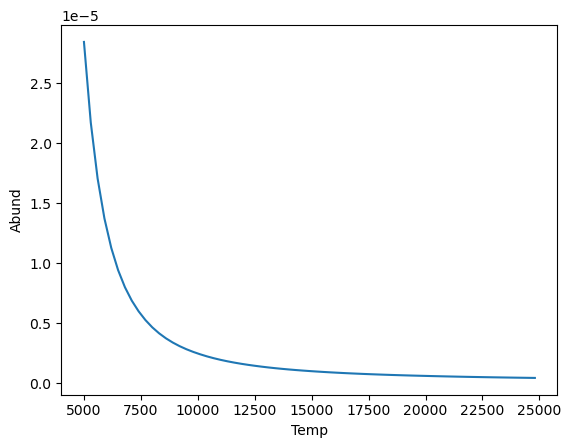

In [484]:
temlist = np.arange(5000,25000, 300)
denlist = np.ones_like(temlist) * ns2
abundances = N2.getIonAbundance(int_ratio=n2_hbeta*100, tem=temlist, den=denlist, wave=6585)

fig=plt.figure()
plt.plot(temlist, abundances, '-')
plt.xlabel('Temp')
plt.ylabel('Abund')
plt.show()

In [485]:
# get NII ICF
atom_abund = {'O2':o2[0], 'O3':o3[0], 'N2':n2abund, 'N3':0}
icf = pn.ICF()
print(icf.getAvailableICFs('N'))
elem_abund = icf.getElemAbundance(atom_abund, icf_list=['direct_N.23', 'direct_N.234', 'direct_N.2345', 
                                                        'TPP77_14', 'KB94_A0', 'KB94_A1.6', 'KB94_A1.8', 
                                                        'KB94_A1.10', 'KB94_A1.10b', 'KH01_4c', 'DIMS14_14', 
                                                        'DIMS14_14b', 'Ial06_18a', 'Ial06_18b', 'Ial06_18c'])
print(elem_abund)

{'N': ['direct_N.23', 'direct_N.234', 'direct_N.2345', 'TPP77_14', 'KB94_A0', 'KB94_A1.6', 'KB94_A1.8', 'KB94_A1.10', 'KB94_A1.10b', 'KH01_4c', 'DIMS14_14', 'DIMS14_14b', 'Ial06_18a', 'Ial06_18b', 'Ial06_18c']}
warng ICF: elem_abun["KB94_A6"]  / abun["O2"] cannot be evaluated for KB94_A1.6
warng ICF: elem_abun["KB94_A8"]  / abun["O2"] cannot be evaluated for KB94_A1.8
warng ICF: elem_abun["KB94_A10"]  / abun["O2"] cannot be evaluated for KB94_A1.10
warng ICF: elem_abun["KB94_A10b"]  / abun["O2"] cannot be evaluated for KB94_A1.10b
warng ICF: 10**(-0.16 * abun["O3"] / (abun["O2"] + abun["O3"]) * (1.0 + np.log10(abun["He3"] / (abun["He2"] + abun["He3"])))) * elem_abun["DIMS14_12"] / abun["O2"] cannot be evaluated for DIMS14_14
warng ICF: 10**(0.64 * abun["O3"] / (abun["O2"] + abun["O3"])) * elem_abun["DIMS14_12"] / abun["O2"] cannot be evaluated for DIMS14_14b
{'direct_N.23': 1.5170848237943873e-06, 'direct_N.234': nan, 'direct_N.2345': nan, 'TPP77_14': 1.322809816247752e-05, 'KB94_A0': 

In [486]:
icflist = [#'direct_N.23', 'direct_N.234', 'direct_N.2345', 
           #'TPP77_14', 'KB94_A0', 'KB94_A1.6', 'KB94_A1.8', 
           #'KB94_A1.10', 'KB94_A1.10b', 'KH01_4c', 'DIMS14_14', 
           #'DIMS14_14b', 
        'Ial06_18a', 'Ial06_18b', 'Ial06_18c'] # low, med, hi metallicity - we want med probably

for string in icflist:
    print(icf.getExpression(string))
    print(icf.getElemAbundance(atom_abund, icf_list=[string]))
    print(icf.getReference(string))
    print()

n_abund_I06med = icf.getElemAbundance(atom_abund, icf_list=['Ial06_18b'])['Ial06_18b']
print()
print(f'Orig. N+/H+: < {n2abund}')
print(f'ICF(N) [Izotov+06, med] = {n_abund_I06med/n2abund}')
print(f'--> N/H = {n_abund_I06med}')

N = (N2) * (-0.825 * O2 / (O2 + O3) + 0.718 + 0.853 * (O2 + O3) / O2)
{'Ial06_18a': 1.222929353698603e-05}
Izotov et al 2006, A&A, 448, 955

N = (N2) * (-0.809 * O2 / (O2 + O3) + 0.712 + 0.852 * (O2 + O3) / O2)
{'Ial06_18b': 1.2209746757257108e-05}
Izotov et al 2006, A&A, 448, 955

N = (N2) * (-1.476 * O2 / (O2 + O3) + 1.752 + 0.688 * (O2 + O3) / O2)
{'Ial06_18c': 1.1502056071606482e-05}
Izotov et al 2006, A&A, 448, 955


Orig. N+/H+: < 1.5170848237943873e-06
ICF(N) [Izotov+06, med] = 8.048163534270456
--> N/H = 1.2209746757257108e-05


In [487]:
atom_abund = {'O2':o2[0], 'O3':o3[0], 'N2':n2abund, 'N3':0}
icf = pn.ICF()

n_abund_I06med2 = icf.getElemAbundance(atom_abund, icf_list=['Ial06_18b'])['Ial06_18b']
print(f'Orig. N+/H+ (TT): {n2abund}')
print(f'ICF(N) [Izotov+06, med] = {n_abund_I06med2/n2abund}')
print(f'--> N/H (TT) = {n_abund_I06med2}')

Orig. N+/H+ (TT): 1.5170848237943873e-06
ICF(N) [Izotov+06, med] = 8.048163534270456
--> N/H (TT) = 1.2209746757257108e-05


In [488]:
# or, using Peimbert1967 N/O = N+/O+ --> N/N+ = O/O+
icf = (o2[0]+o3[0]) / o2[0]
icferr = np.sqrt( (np.sqrt(o2[1]**2+o3[1]**2) / (o2[0]+o3[0]))**2 + (o2[1]/o2[0])**2)
print(f'ICF: {icf} +- {icferr}')

n_abund_p67 = icf * n2abund2a[0]
n_abund_p67_err = np.sqrt((n2abund2a[1]/n2abund2a[0])**2 + (icferr/icf)**2) * n_abund_p67
print(f'N/H (TT) = {n_abund_p67} +- {n_abund_p67_err}')
print(f'N+/H+ (TT) = {n2abund2a[0]} +- {n2abund2a[1]}')

n_abund_p67_uplim = icf * n2abund
print(f'N/H uplim: {n_abund_p67_uplim}')
print(f'N+/H+ uplim: {n2abund}')
print(f'12 + log(N+/H+) = {12 + np.log10(n2abund2a[0])}')

ICF: 8.719418950743089 +- 0.4819739903518477
N/H (TT) = 1.0054526633972658e-05 +- 2.188208615238876e-06
N+/H+ (TT) = 1.153118882206685e-06 +- 2.427286651061834e-07
N/H uplim: 1.322809816247752e-05
N+/H+ uplim: 1.5170848237943873e-06
12 + log(N+/H+) = 6.061874083725614


In [489]:
12+np.log10(64.8e-6*1.417)

7.962944856118054

#### Get Te(SIII)

In [490]:
ts3_tt = 0.83 * TO3 + 1700 #G92 TT relation
ts3_tte = 0.83 * TO3e
print(f'Te(S3) TT: {ts3_tt} +- {ts3_tte}')

Te(S3) TT: 11864.79209680769 +- 349.60398226492526


#### Get Argon Abundance

In [491]:
from scipy.interpolate import interp1d

In [492]:
# use te_s3 from TT relation
# 
ar3_dered = lines.loc[lines['restwave']==7137.8]['final_flux'].values[0]
ar3_dered_err = lines.loc[lines['restwave']==7137.8]['final_fluxerr'].values[0]
dered_hbeta = lines.loc[lines['restwave']==4862.683]['final_flux'].values[0]
dered_hbeta_err = lines.loc[lines['restwave']==4862.683]['final_fluxerr'].values[0]

ar3_ratio = ar3_dered / dered_hbeta
ar3_ratioerr = ar3_ratio * np.sqrt((ar3_dered_err/ar3_dered)**2 + (dered_hbeta_err/dered_hbeta)**2)

ar3_abund = Ar3.getIonAbundance(int_ratio=ar3_ratio*100,
                               tem=ts3_tt, den=ns2, wave=7135)
ar3 = get_iabund_err('Ar3', 7138, ar3_ratio, ar3_ratioerr, dens=ns2, tem=ts3_tt, teme=ts3_tte)
print(f'Ar++/H+: {ar3_abund} +- {ar3[1]}')
print()
v = o2abund_b / (o2abund_b+o3abund)
verr_denom = np.sqrt(o2[1]**2 + o3[1]**2)
verr = v * np.sqrt((o2[1]/o2abund_b)**2 + (verr_denom/(o2abund_b+o3abund))**2)
print(v,verr)
iz06_int = 0.285*v + 0.833 + (0.051/v)
iz06_hi = 0.517*v + 0.763 + (0.042/v)
th95 = 1./(0.15 + v*(2.39-2.64*v))
print(f'ICF(Iz06 IntZ): {iz06_int}')
print(f'ICF(Iz06 HiZ): {iz06_hi}')
print(f'ICF(Thuan95): {th95}')
icfint = interp1d([7.6,8.2],[iz06_int,iz06_hi])
icf_interp = icfint(8.14)
icferr_int = 0.285*verr + (0.051/verr)
icferr_hi = 0.517*verr + (0.042/verr)
print(icferr_int,icferr_hi)
icferrint = interp1d([7.6,8.2],[icferr_int,icferr_hi])
icferr_interp = icferrint(8.14)
print(f'ICF(Iz06 interp): {icf_interp} +- {0.1*icf_interp}')
print()
#print(f'Ar/H (Iz06Int): {ar3_abund*iz06_int}')
#print(f'Ar/H (Iz06Hi): {ar3_abund*iz06_hi}')
#print(f'Ar/H (Thuan95): {ar3_abund*th95}')
arh = ar3_abund * icf_interp
arh_err = arh * np.sqrt((ar3[1]/ar3_abund)**2 + 0.1**2) # adding 10% uncertainty to ICF
print(f'Ar/H (Iz06interp): {ar3_abund*icf_interp} +- {arh_err}')
print()
#print(f'log(Ar/O) (Iz06Int): {np.log10((ar3_abund*iz06_int)/tot_oabund)}')
#print(f'log(Ar/O) (Iz06Hi): {np.log10((ar3_abund*iz06_hi)/tot_oabund)}')
#print(f'log(Ar/O) (Thuan95): {np.log10((ar3_abund*th95)/tot_oabund)}')
ar_o = (arh)/tot_oabund
log_ar_o = np.log10(ar_o)
ar_o_err = ar_o * np.sqrt((arh_err/arh)**2 + (tot_oabund_err/tot_oabund)**2)
log_ar_o_err = (1/np.log(10)) * ar_o_err/ar_o
print(f'log(Ar/O): {log_ar_o} +- {log_ar_o_err}')

Ar++/H+: 4.154449620497232e-07 +- 4.025174319822486e-08

0.11396239950721346 0.054747125267776815
ICF(Iz06 IntZ): 1.3129953086232486
ICF(Iz06 HiZ): 1.190461169174153
ICF(Thuan95): 2.576766223240958
0.947158692771945 0.7954678325274878
ICF(Iz06 interp): 1.2027145831190622 +- 0.12027145831190622

Ar/H (Iz06interp): 4.996617143405475e-07 +- 6.957210592982757e-08

log(Ar/O): -2.4334243304919925 +- 0.07676404550090514


#### Make Te plot

In [493]:
import matplotlib.transforms as transforms

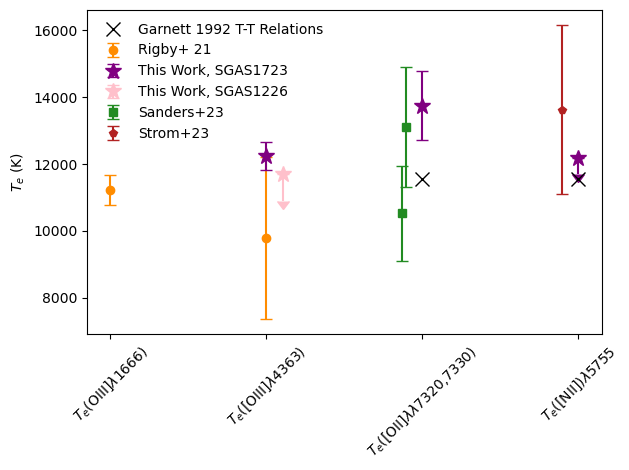

Te([OIII]4363: 12246.737466033363 +- 421.209617186657
Te([OII]7320,7330: 13751.216670621627 +- 1027.7127068815869
Te([NII]5755: < 12191.920516356833
Te(4363, rigby21): 9778.632920630387 +- 2417.9047846762555
Te(UV, rigby): 11215.7225715802 +- 450.93002939498126


In [495]:
measures_full = ['$T_e$(OIII]$\lambda$1666)',
                 '$T_e$([OIII]$\lambda$4363)',
                 '$T_e$([SIII])$\lambda$6312',
                 '$T_e$([NII])$\lambda$5755',
                 '$T_e$([OII]$\lambda\lambda$7320,7330)']

measures_1723 = [measures_full[1],measures_full[4],measures_full[3]]
temps_1723 = [TO3,TO2,tn2n]
temperrs_1723 = [TO3e,TO2e,500]
uplims_1723 = np.array([0,0,1], dtype=bool)

measures_jr = measures_full[:2]
temps_jr = [TO3_uv,TO3_jr]
temperrs_jr = [TO3_uve,TO3_jre]

measures_1226 = [measures_full[1]]
temps_1226 = [11700]

s1723_TT_measures = [measures_full[4],measures_full[3]]#,measures_full[2]]
s1723_TT_temps = [to2_tt,to2_tt]#,ts3_tt]

# add in temps from Sanders+2023 keck data
measures_sand1, measures_sand2 = measures_full[-1],measures_full[-1]
temps_sand1, temps_sand2 = 13110, 10530
temperrs_sand1, temperrs_sand2 = 1800, 1420

# add in temp from Strom+2023 Cecilia
measures_strom = measures_full[-2]
temps_strom = [13630]
temperrs_strom = [2540]


fig = plt.figure()

# add in offset for non-sgas1723 data
offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

plt.errorbar(measures_jr, temps_jr, yerr=temperrs_jr, marker='o', color='darkorange', linestyle='', 
             capsize=4, label='Rigby+ 21')
plt.errorbar(measures_1723, temps_1723, yerr=temperrs_1723, uplims=uplims_1723,
             marker='*', markersize=12, color='purple', linestyle='', capsize=4, label='This Work, SGAS1723')
plt.errorbar(measures_1226, temps_1226, yerr=800, uplims=True, transform=trans+offset(12),
             marker='*', markersize=12, color='pink', linestyle='', capsize=4, label='This Work, SGAS1226')
plt.errorbar(measures_sand1, temps_sand1, yerr=temperrs_sand1, marker='s', color='forestgreen', 
             linestyle='', capsize=4, label='Sanders+23', transform=trans+offset(-12), zorder=2)
plt.errorbar(measures_sand2, temps_sand2, yerr=temperrs_sand2, marker='s', color='forestgreen', 
             linestyle='', capsize=4, transform=trans+offset(-15), zorder=2)
plt.errorbar(measures_strom, temps_strom, yerr=temperrs_strom, marker='p', color='firebrick', 
             linestyle='', capsize=4, label='Strom+23', transform=trans+offset(-12), zorder=2)
#plt.plot(measures_1226, temps_1226, marker='v', color='fuchsia', linestyle='', markersize=9, label='SGAS1226')
plt.plot(s1723_TT_measures, s1723_TT_temps, 
         color='k', marker='x', markersize=10, linestyle='', label='Garnett 1992 T-T Relations')

plt.ylabel('$T_e$ (K)')
plt.legend(loc='best', framealpha=0.)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('auroral/Te_full_stackcube_comp_v3.png')
plt.show()
print(f'Te([OIII]4363: {TO3} +- {TO3e}')
print(f'Te([OII]7320,7330: {TO2} +- {TO2e}')
print(f'Te([NII]5755: < {tn2n}')
print(f'Te(4363, rigby21): {TO3_jr} +- {TO3_jre}')
print(f'Te(UV, rigby): {TO3_uv} +- {TO3_uve}')

#### Get abundances

In [518]:
atot_oabund = o2abund_a + o3abund
ametallicity = 12 + np.log10(atot_oabund)
print(atot_oabund)
print(ametallicity)
btot_oabund = o2abund_b + o3abund
bmetallicity = 12 + np.log10(btot_oabund)
print(btot_oabund)
print(bmetallicity)


0.00015735837707580701
8.196889867814583
0.0001355502753726385
8.132100404193862


In [519]:
get_temden_err('NS2', ns2r, ns2re, 1e4, 30)
#S2.getTemDen()

(154.47408507460653, 96.61384225313476)

In [520]:
# some strong line diagnostics:
# up first, N2/Halpha
dered_halpha = lines.loc[lines['restwave']==6564.61]['final_flux'].values[0]
dered_halpha_err = lines.loc[lines['restwave']==6564.61]['final_fluxerr'].values[0]
N2Ha = dered_n2_6585 / dered_halpha
N2Ha_err = np.sqrt((dered_n2_6585_err/dered_n2_6585)**2 + (dered_halpha_err/dered_halpha)**2) * N2Ha
print(f'NII6585/Halpha: {N2Ha} +- {N2Ha_err}')
linear_pp04_metal = 8.90 + 0.57*np.log10(N2Ha) # equation 1, Pettini&Pagel 2004
linear_pp04_metalhi = (8.90 + 0.57*np.log10(N2Ha+N2Ha_err)) - linear_pp04_metal
linear_pp04_metallo = linear_pp04_metal - (8.90 + 0.57*np.log10(N2Ha-N2Ha_err)) 
print(f'12+log(O/H), N2: {linear_pp04_metal} +{linear_pp04_metalhi} -{linear_pp04_metallo}')

NII6585/Halpha: 0.038466993769183576 +- 0.004200691407845801
12+log(O/H), N2: 8.093500300859093 +0.02565617587762503 -0.02862597250720178


In [521]:
# now lets try N2 with the Kewley parametrization, just for funsies
log_n2 = np.log10(N2Ha)
log_n2_err = np.sqrt(N2Ha_err**2 / ((N2Ha * np.log(N2Ha))**2)) * N2Ha
print(log_n2, log_n2_err)

log_U = -2.2 #??
x = log_n2
y = log_U
A,B,C,D,E,F,G,H,I,J = [10.526,1.9958,-0.6741,0.2892,0.5712,-0.6597, 0.0101, 0.0800, 0.0782, -0.0982]
kewley_fit_N2 = A + B*x + C*y + D*x*y + E*x**2 + F*y**2 + G*x*y**2 + H*y*x**2 + I*x**3 + J*y**3
#print(kewley_fit, 0.0042*kewley_fit)
kewley_fit_N2_err = np.sqrt((0.0067)**2 + (log_n2_err/log_n2)**2) * kewley_fit_N2
#print(kewley_fit_err)
print(f'N2/Halpha: 12 + log(O/H) = {kewley_fit_N2} +- {kewley_fit_N2_err}')

-1.4149117528787858 0.001289364580436928
N2/Halpha: 12 + log(O/H) = 8.438551503316566 +- 0.05705884355138671


In [522]:
# up next, R23 = (OII3727,9 + OIII4959,5007) / Hbeta
r23num = (dered_3727_r+dered_3729_r + dered_o3_4959+dered_o3_5007)
r23 = r23num / dered_Hbeta
r23err1 = np.sqrt(dered_3727_re**2 + dered_3729_re**2 + dered_o3_4959_err**2 + dered_o3_5007_err**2)
r23err = np.sqrt((r23err1/r23num)**2 + (dered_Hbeta_err/dered_Hbeta)**2) * r23
print(r23, r23err)
log_r23 = np.log10(r23)
log_r23_err = np.sqrt(r23err**2 / (r23 * np.log(10))**2) * log_r23
print(log_r23, log_r23_err)

log_U = -2.2 #??
x = log_r23
y = log_U
A,B,C,D,E,F,G,H,I,J = [9.7757,-0.5059,0.9707,-0.1744,-0.0255,0.3838, -0.0378, 0.0806, -0.0852, 0.0462]
kewley_fit_R23 = A + B*x + C*y + D*x*y + E*x**2 + F*y**2 + G*x*y**2 + H*y*x**2 + I*x**3 + J*y**3
#print(kewley_fit, 0.0042*kewley_fit)
kewley_fit_R23_err = np.sqrt(0.0042**2 + (log_r23_err/log_r23)**2)*kewley_fit_R23
#print(kewley_fit_err)
print(f'R23: 12 + log(O/H) = {kewley_fit_R23} +- {kewley_fit_R23_err}')

10.083448655849995 0.22665789294852914
1.0036090912420046 0.009797395816350633
R23: 12 + log(O/H) = 8.409128555741491 +- 0.08936646110914051


In [11]:
log_U = -2.5 #??
x = np.log10(8)
y = log_U
A,B,C,D,E,F,G,H,I,J = [9.7757,-0.5059,0.9707,-0.1744,-0.0255,0.3838, -0.0378, 0.0806, -0.0852, 0.0462]
kewley_fit_R23 = A + B*x + C*y + D*x*y + E*x**2 + F*y**2 + G*x*y**2 + H*y*x**2 + I*x**3 + J*y**3
#print(kewley_fit, 0.0042*kewley_fit)
#kewley_fit_R23_err = np.sqrt(0.0042**2 + (log_r23_err/log_r23)**2)*kewley_fit_R23
#print(kewley_fit_err)
print(f'R23: 12 + log(O/H) = {kewley_fit_R23} +- {0}')

R23: 12 + log(O/H) = 8.501456526910085 +- 0


In [14]:
log_r23, log_r23_err = 1.0036090912420046, 0.009797395816350633

In [20]:
# also for funsies, let's try the Sanders+ R23 calibration:
c0 = 1.017
c1 = 0.026
c2 = -0.331

y = c0 - log_r23

# thanks to the quadratic formula, we now have:
met1 = ((-c1 + np.sqrt(c1**2 - 4*c2*y)) / (2*c2)) + 8
met2 = ((-c1 - np.sqrt(c1**2 - 4*c2*y)) / (2*c2)) + 8
print(met1, met2)

sandmeterr = np.sqrt(0.02**2 + (log_r23_err/log_r23)**2)*met2
print(sandmeterr)

7.834339721565363 8.244210127377235
0.18347763891596275


In [524]:
8.2-10.4

-2.200000000000001

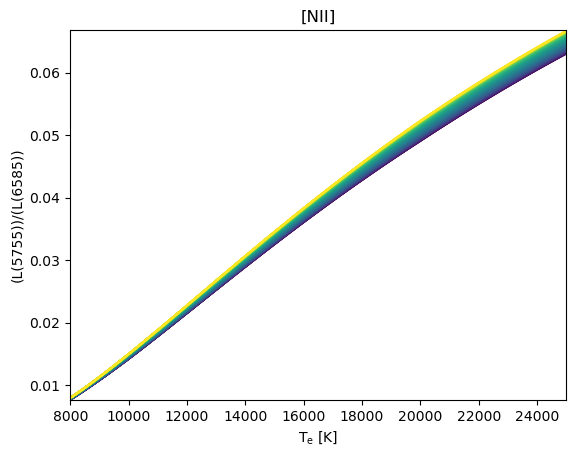

N2 ratio <  0.02345097225898734


In [525]:
n2grid = pn.EmisGrid('N', 2, n_tem=100, n_den=100, tem_min=8000, tem_max=25000, den_min=1,den_max=500)


n2grid.plotLineRatio(to_eval='(L(5755))/(L(6585))', par='den', n_par=100, legend=False,
                     par_low=0.5, par_high=2.5)

print('N2 ratio < ', tn2r)


In [526]:
# Read in data for OHNO plot

# first, Berg+2020 - HII regions in local galaxies
#a3 = Table.read('auroral/berg20_data/tablea3.dat', header=None)
#b1 = Table.read('auroral/berg20_data/tableb1.dat', format='ascii.no_header', delimiter=' ')
b1 = np.loadtxt('auroral/berg20_data/tableb1.dat', dtype=str)
b2 = np.loadtxt('auroral/berg20_data/tableb2.dat', dtype=str)
b3 = np.loadtxt('auroral/berg20_data/tableb3.dat', dtype=str)

b1_oh = []
b1_oherr = []
b1_no = []
b1_noerr = []
for i in b1:
    b1_oh.append(float(i[1]))
    b1_oherr.append(float(i[2]))
    b1_no.append(float(i[3]))
    b1_noerr.append(float(i[4]))

b2_oh = []
b2_oherr = []
b2_no = []
b2_noerr = []
for i in b2:
    b2_oh.append(float(i[1]))
    b2_oherr.append(float(i[2]))
    b2_no.append(float(i[3]))
    b2_noerr.append(float(i[4]))

b3_oh = []
b3_oherr = []
b3_no = []
b3_noerr = []
for i in b3:
    b3_oh.append(float(i[1]))
    b3_oherr.append(float(i[2]))
    b3_no.append(float(i[3]))
    b3_noerr.append(float(i[4]))

btot_oh = b1_oh + b2_oh + b3_oh
btot_oherr = b1_oherr + b2_oherr + b3_oherr
btot_no = b1_no + b2_no + b3_no
btot_noerr = b1_noerr + b2_noerr + b3_noerr


# Sanders+2023
sand_oh = [7.89, 8.24]
sand_oherr = [0.2, 0.27]
sand_no = [-0.69, -0.78]
sand_noerr = [0.1, 0.14]

# Berg+2012
berg12 = pd.read_csv('auroral/berg12_abund.csv', header=0, sep='\s+')
oh_b12 = berg12['12+log(O/H)']
oherr_b12 = berg12['12+log(O/H)_err']
no_b12 = berg12['log(N/O)']
noerr_b12 = berg12['log(N/O)_err']

#Berg+2019
berg19 = pd.read_csv('auroral/berg19_abund.csv', header=0, sep='\s+')
oh_b19 = berg19['12+log(O/H)']
oherr_b19 = berg19['12+log(O/H)_err']
no_b19 = berg19['log(N/O)']
noerr_b19 = berg19['log(N/O)_err']

# Rogers+2023
oh_rogers = [8.16]
oherr_rogers = [0.05]
no_rogers = [-1.46]
noerr_rogers = [0.15]


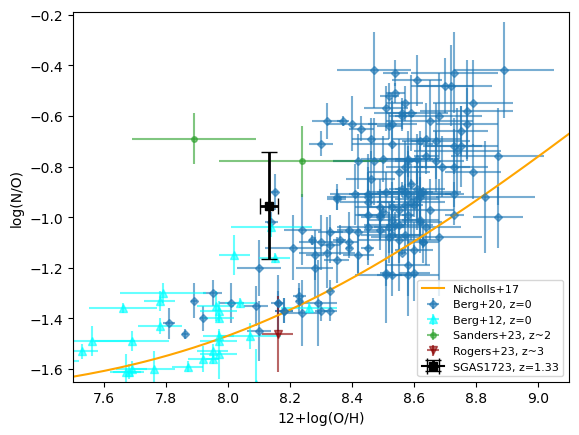

SGAS1723 12+log(O/H) 8.132100404193862 +- 0.028150123319979306
SGAS1723 log(N/O); -0.9546895612307901 +- 0.21134780951478815


In [527]:
no = np.log10(n2abund2a[0]/o2[0]) 
no2 = np.log10(n2abund2b0/o2abund_b)
noerr = n_o_err
oh = tot_met
oherr = tot_met_err

nicholls_log_oh_p12 = np.arange(7.5,9.5,0.01)
nicholls_log_oh = nicholls_log_oh_p12 - 12
nicholls_log_no = np.log10(10**(-1.732) + 10**(nicholls_log_oh+2.19))

fig = plt.figure()
plt.errorbar(btot_oh, btot_no, xerr=btot_oherr, yerr=btot_noerr, 
             linestyle='None', marker='D', alpha=0.6, color='tab:blue', label='Berg+20, z=0', markersize=4)
#plt.errorbar(b1_oh, b1_no, xerr=b1_oherr, yerr=b1_noerr, 
#             linestyle='None', marker='D', alpha=0.6, label='Berg+2020, NGC628')
#plt.errorbar(b2_oh, b2_no, xerr=b2_oherr, yerr=b2_noerr, 
#             linestyle='None', marker='D', alpha=0.6, label='Berg+2020, NGC5194')
#plt.errorbar(b3_oh, b3_no, xerr=b3_oherr, yerr=b3_noerr, 
#             linestyle='None', marker='D', alpha=0.6, label='Berg+2020, NGC5457')
plt.errorbar(oh_b12, no_b12, xerr=oherr_b12, yerr=noerr_b12,
             linestyle='None', marker='^',alpha=0.6, color='cyan', markersize=6, label='Berg+12, z=0')
#plt.errorbar(oh_b19, no_b19, xerr=oherr_b19, yerr=noerr_b19,
#             linestyle='None', marker='v',alpha=0.6, color='b', markersize=6, label='Berg+19')
plt.errorbar(sand_oh, sand_no, xerr=sand_oherr, yerr=sand_noerr, 
             linestyle='None', marker='o', alpha=0.6, color='tab:green', label='Sanders+23, z~2', markersize=4)
plt.errorbar(oh_rogers, no_rogers, xerr=oherr_rogers, yerr=noerr_rogers,
             linestyle='None', marker='v', alpha=0.6, color='darkred', label='Rogers+23, z~3')
plt.errorbar(oh, no2, xerr=oherr, yerr=noerr, 
             color='k', marker='s', label='SGAS1723, z=1.33', zorder=3, markersize=6, capsize=6, elinewidth=2)
#plt.plot(oh, no2, color='k', marker='s', alpha=0.5)
plt.plot(nicholls_log_oh_p12, nicholls_log_no, linestyle='-', color='orange', label='Nicholls+17')
plt.xlim(7.5,9.1)
plt.ylim(-1.65,-0.19)

plt.xlabel('12+log(O/H)')
plt.ylabel('log(N/O)')

plt.legend(loc='lower right',fontsize=8)

plt.savefig('auroral/oh_no_stackcube_v3.png')
plt.show()
print('SGAS1723 12+log(O/H)',oh,'+-',oherr)
print('SGAS1723 log(N/O);',no2,'+-',noerr)

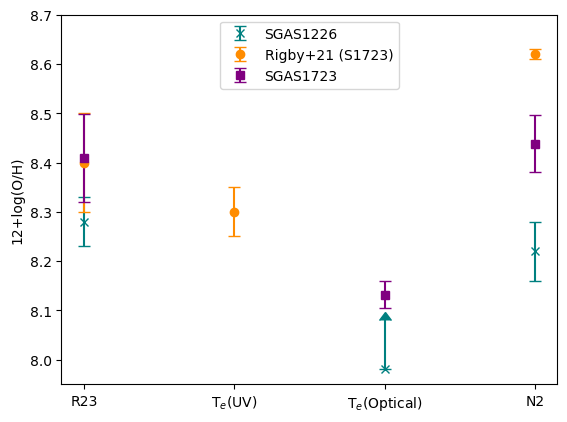

SGAS1723: This Work
['R23', 'T$_e$(UV)', 'T$_e$(Optical)', 'N2']
[8.409128555741491, 0, 8.132100404193862, 8.438551503316566]
[0.08936646110914051, 0, 0.028150123319979306, 0.05705884355138671]

SGAS1723: Rigby+21
['R23', 'T$_e$(UV)', 'T$_e$(Optical)', 'N2']
[8.4, 8.3, 0, 8.62]
[0.1, 0.05, 0, 0.01]

SGAS1226:
['R23', 'T$_e$(UV)', 'T$_e$(Optical)', 'N2']
[8.28, 0, 7.98, 8.22]
[0.05, 0, 0.1, 0.06]


In [528]:
# Make Abundance Figure
measures = ['R23','T$_e$(UV)', 'T$_e$(Optical)', 'N2']
metals_1723 = [kewley_fit_R23, 0, tot_met, kewley_fit_N2]
metals_1723_err = [kewley_fit_R23_err, 0, tot_met_err, kewley_fit_N2_err]

rigby_1723_pk6 = [8.4, 8.3, 0, 8.62]
rigby_1723_pk6err = [0.1, 0.05, 0, 0.01]

metals_1226 = [8.28,0,7.98,8.22]
metals_1226_err = [0.05,0,0.1,0.06]
lolims_1226 = [0, 0, 1, 0]

fig = plt.figure()
plt.errorbar(measures, metals_1226, yerr=metals_1226_err, lolims=lolims_1226,
             marker='x', color='teal', linestyle='', capsize=4, label='SGAS1226')
plt.errorbar(measures, rigby_1723_pk6, yerr=rigby_1723_pk6err,
             marker='o', color='darkorange', linestyle='', capsize=4, label='Rigby+21 (S1723)')
plt.errorbar(measures, metals_1723, yerr=metals_1723_err, 
             marker='s', color='purple', linestyle='', capsize=4, label='SGAS1723')

plt.ylabel('12+log(O/H)')
plt.ylim(7.95,8.7)
plt.legend(loc='upper center')

#plt.savefig('auroral/abund_stackcube_v2.png')
plt.show()
print('SGAS1723: This Work')
print(measures)
print(metals_1723)
print(metals_1723_err)
print()
print('SGAS1723: Rigby+21')
print(measures)
print(rigby_1723_pk6)
print(rigby_1723_pk6err)
print()
print('SGAS1226:')
print(measures)
print(metals_1226)
print(metals_1226_err)

In [484]:
(1.5+1.09)/1.5

1.7266666666666666

#### HERE BE DRAGONS
Everything below here is old, mainly kept for posterity (and because I'm a bit of a hoarder when it comes to code)

In [23]:
def gaussian(x, amp, mu, sigma):
    exponential = -1 * (x - mu)**2 / (2 * sigma**2)
    return amp * np.exp(exponential)

def multigauss(x, *args, fixed=None):
    # set fixed as a list of tuples (index, value) that you wnat fixed
    # get list of inds from list of tuples:
    argarr = np.array(args)
    if fixed is not None:
        #fixinds = [f[0] for f in fixed]
        #print(fixinds)
        for tup in fixed:
            argarr = np.insert(argarr, tup[0], tup[1])
    print(argarr)
    ngauss = int(len(argarr) / 3)
    total = 0
    for n in range(ngauss):
        i = 3*n
        j = 3*n + 1
        k = 3*n + 2
        #if fixed is not None:
        #    if i in fixinds: ival = fixed[fixinds.index(i)][1]
        #    else: ival = args[i]
        #    if j in fixinds: jval = fixed[fixinds.index(j)][1]
        #    else: jval = args[j]
        #    if k in fixinds: kval = fixed[fixinds.index(k)][1]
        #    else: kval = args[k]
        #else: ival = args[i], jval = args[j], kval = args[k]
        ival = argarr[i]
        jval = argarr[j]
        kval = argarr[k]
        print(ival,jval,kval)
        total += gaussian(x, ival, jval, kval)
    return total  


In [13]:
%matplotlib inline

[1 1 1 2 2 2 3 3 3]
1 1 1
2 2 2
3 3 3


<function matplotlib.pyplot.show(close=None, block=None)>

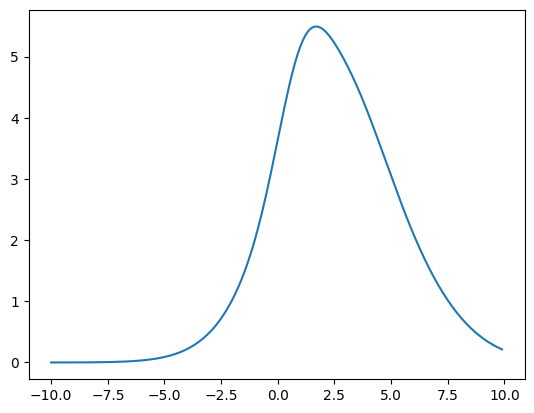

In [25]:
x = np.arange(-10,10,0.1)
fix = [(1,-7),(6,1)]
#y = lambda x,*args: multigauss(x,*args,fixed=fix)
#multigauss(x, 1,1,1,2,2,2,3,3,3, fixed=fix)

fig = plt.figure()
plt.plot(x,multigauss(x, 1,1,1,2,2,2,3,3,3, fixed=None))
plt.show

In [15]:
# Now we'll read in the spectrum as a Spectrum1D object
orig_cubefile_g140h = 'Level3_SGAS1723_BGSUB_g140h-f100lp_s3d.fits'
cube140 = Spectrum1D.read(os.path.join(datadir, orig_cubefile_g140h), format="JWST s3d")

with fits.open(os.path.join(datadir, cubefile_g140h)) as cubehdu:
    header = cubehdu[1].header
    pixar_sr = header["PIXAR_SR"] * u.sr
    pixar_a2 = header['PIXAR_A2']

    
# Now let's read in the mask we'll use to extract the final 1D spectrum
# DONT FORGET .T BECAUSE PYTHON IS WEIRD
SNRlayers = fits.open(os.path.join(maskdir,maskfile))
SNRall = SNRlayers[0].data.T ##.T!!!!!
SNRlow = SNRlayers[1].data.T
SNRmask = SNRall - SNRlow
x,y = 35,29
print(SNRmask[x,y],SNRmask[y,x])
#SNRmask[x,y] = 0 # mask out one errant pixel

1.0 0.0


<IPython.core.display.Javascript object>


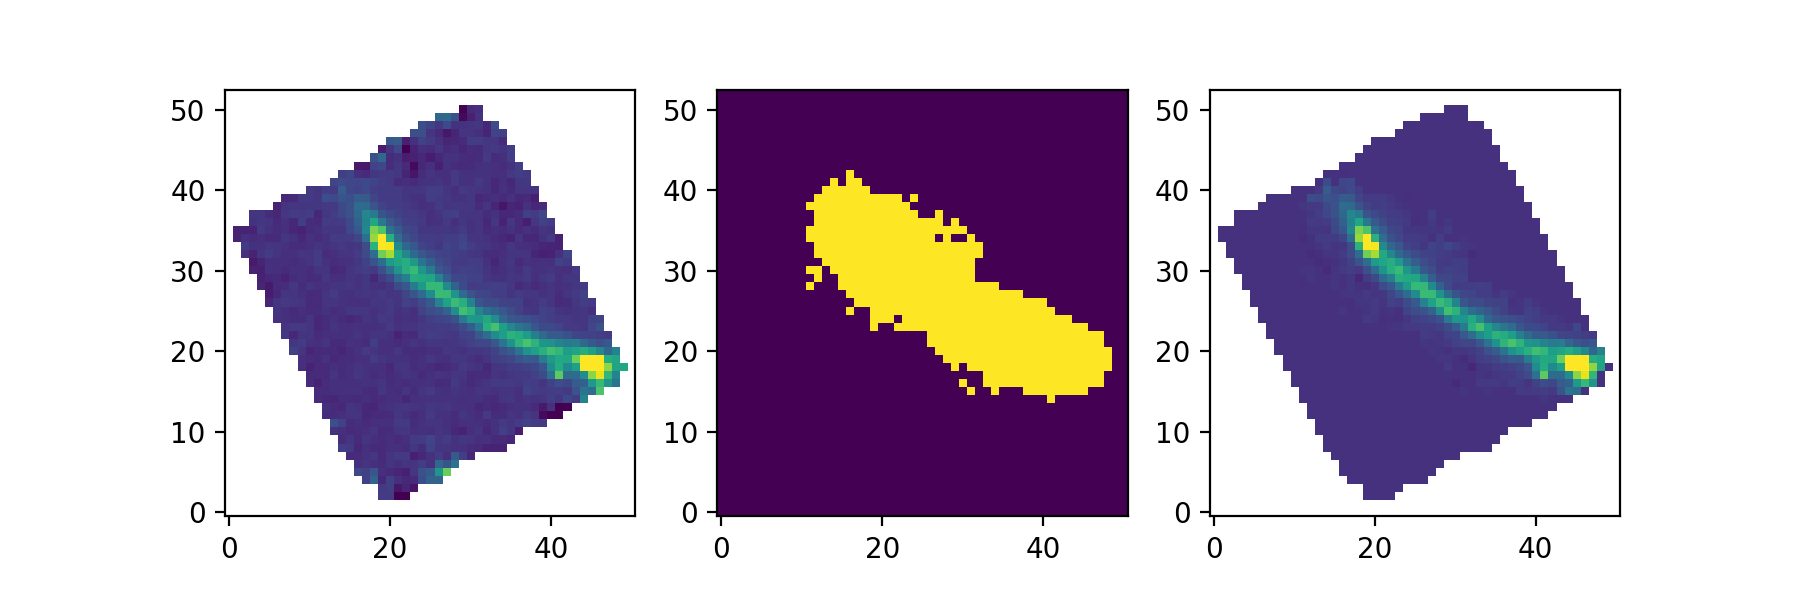

In [17]:
# Consistency check - does the mask line up with the data??
imslice = cube140[:,:,856].flux
imslice.shape = (imslice.shape[:2])
imslice_cut = imslice * SNRmask

fig, ax = plt.subplots(1,3, figsize=(9,3))

ax[0].imshow(imslice, origin='lower', vmin=-2, vmax=12)

ax[1].imshow(SNRmask, origin='lower')
# check that errant pixel was masked correctly: (red box should be 0)
#rect = patches.Rectangle((y-0.5,x-0.5),1,1, linewidth=1, edgecolor='r', fill=False)
#ax[1].add_patch(rect)


ax[2].imshow(imslice_cut, origin='lower', vmin=-2, vmax=12)

plt.show()

/Users/bdwelch1/code/entomology/bw_specstuff.py:92: RuntimeWarning: Mean of empty slice
  err_i = np.nanmean(err0[:,:,i].value * mask)


<IPython.core.display.Javascript object>


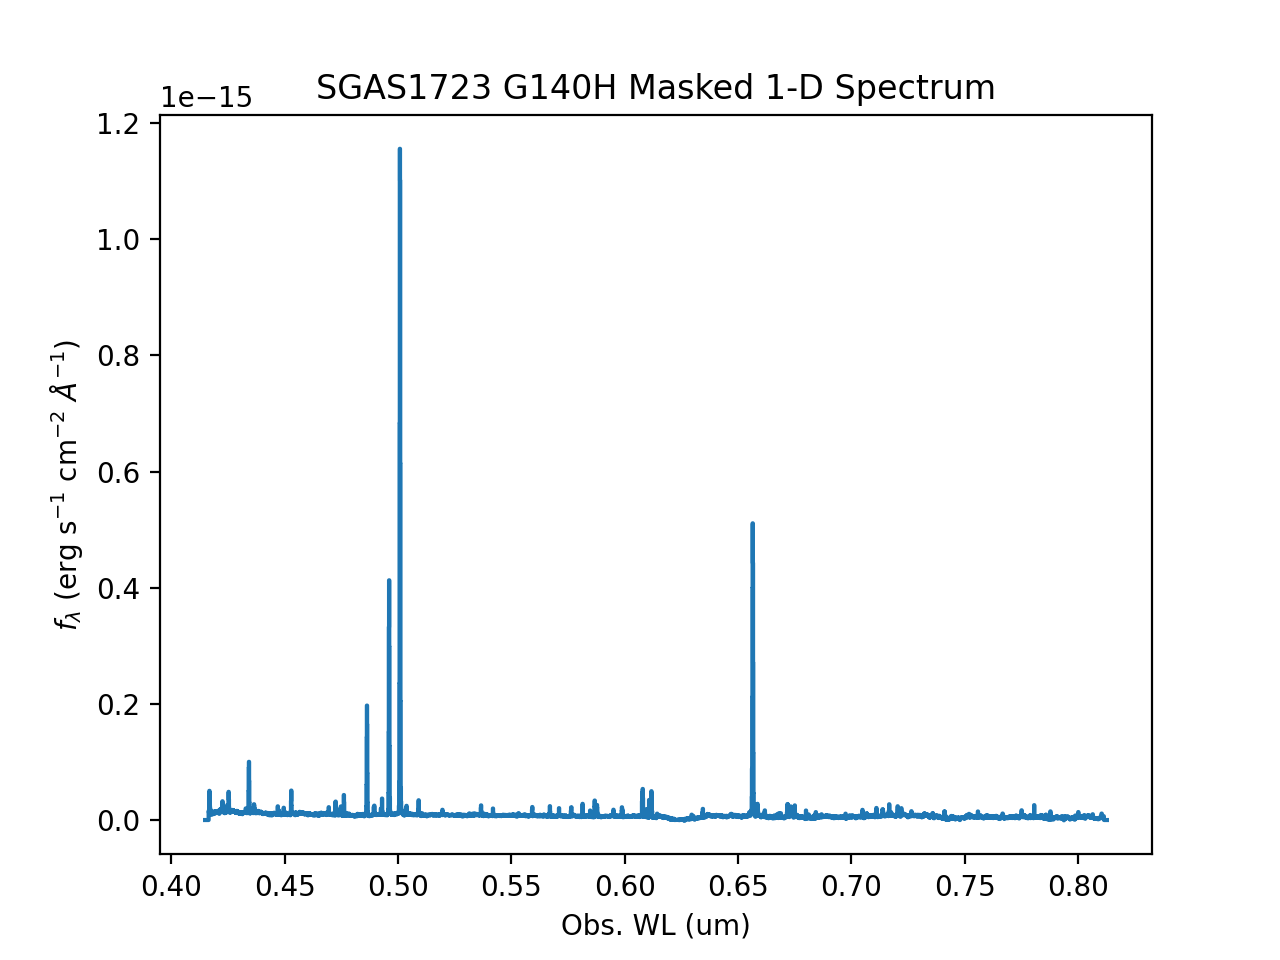

In [37]:
# extract the 1-D spectrum:
spectrum_g140h = bws.extract1D_cube_mask(spec140, SNRmask, pixar_sr, zsource=1.3293)
wlarray = spectrum_g140h.spectral_axis # save in a new variable for ease later

# and plot it for funsies:
fig = plt.figure()
plt.step(spectrum_g140h.spectral_axis, spectrum_g140h.flux, where='mid')
plt.xlabel("Obs. WL (um)")
plt.ylabel("$f_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ $\AA ^{-1}$)")
plt.title('SGAS1723 G140H Masked 1-D Spectrum')
#plt.ylim(-5e-17, 5e-17)
plt.show()

<IPython.core.display.Javascript object>


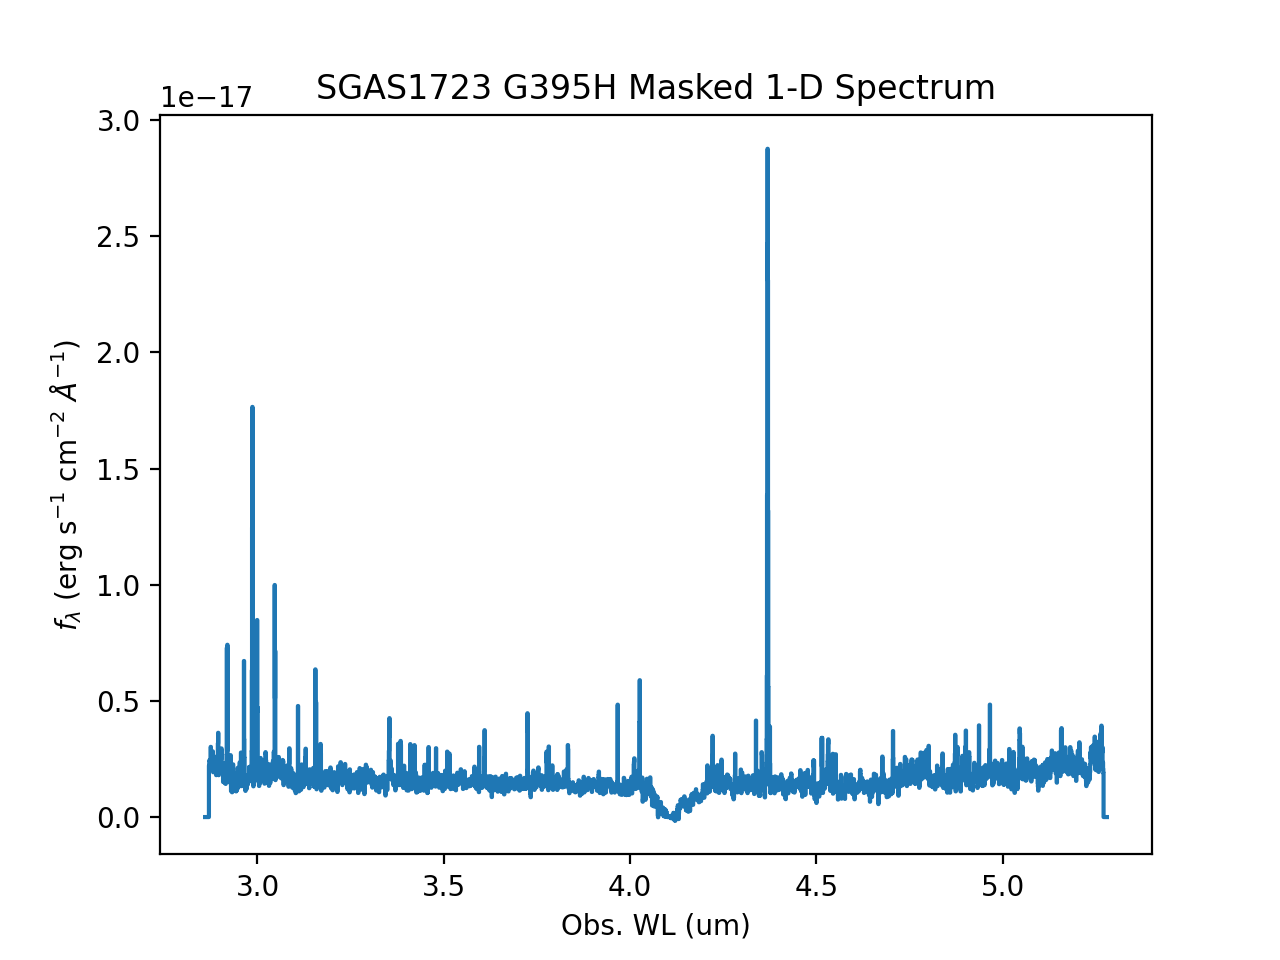

In [100]:
spec395 = Spectrum1D.read(os.path.join(datadir, cubefile_g395h), format="JWST s3d")

with fits.open(os.path.join(datadir, cubefile_g395h)) as cubehdu:
    header = cubehdu[1].header
    pixar_sr = header["PIXAR_SR"] * u.sr

spectrum_g395h = bws.extract1D_cube_mask(spec395, SNRmask, pixar_sr)#, zsource=1.3293)
wlarray395 = spectrum_g395h.spectral_axis # save in a new variable for ease later

# and plot it for funsies:
fig = plt.figure()
plt.step(spectrum_g395h.spectral_axis, spectrum_g395h.flux, where='mid')
plt.xlabel("Obs. WL (um)")
plt.ylabel("$f_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ $\AA ^{-1}$)")
plt.title('SGAS1723 G395H Masked 1-D Spectrum')
#plt.ylim(-5e-17, 5e-17)
plt.show()

In [82]:
# test is_line and upper_limit:
# first - is there a line at OIII 5008?? (there flippin better be)
cont5008 = SpectralRegion(0.494*u.um, 0.495*u.um) + SpectralRegion(0.502*u.um, 0.503*u.um)
line5008 = SpectralRegion(0.5*u.um, 0.502*u.um)
print("Is there OIII 5008?",bws.is_line(spectrum_g140h, line5008, cont5008), "- Great Success!!")
print()

#next, is there a line at NII 5755? 
cont5755 = SpectralRegion(0.5715*u.um, 0.574*u.um) + SpectralRegion(0.577*u.um, 0.585*u.um)
line5755 = SpectralRegion(0.574*u.um, 0.577*u.um)
print("Is there NII 5755?", bws.is_line(spectrum_g140h, line5755, cont5755))
# no line, so we take an upper limit:
uplim5755, sig5755, peak5755 = bws.flux_upper_limit(spectrum_g140h, line5755, cont5755, verbose=True)
print("NII5755 upper limit:", uplim5755)
print("noise sigma:", sig5755)
print("NII peak:", peak5755)
print()

# okay, now for a more interesting test - is there a line at SIII 6312?
cont6312 = SpectralRegion(0.626*u.um, 0.629*u.um) + SpectralRegion(0.6325*u.um, 0.634*u.um)
line6312 = SpectralRegion(0.6309*u.um, 0.6319*u.um)
isline6312 = bws.is_line(spectrum_g140h, line6312, cont6312, n=3)
print("Is there SIII 6312?", isline6312)
if not isline6312:
    uplim6312, sig6312, peak6312 = bws.flux_upper_limit(spectrum_g140h, line6312, cont6312, verbose=True)
    print("uplim:", uplim6312)
    print("sigma:", sig6312)
    print("SIII peak:", peak6312)
print()

Is there OIII 5008? True - Great Success!!

Is there NII 5755? False
NII5755 upper limit: 9.270277718683013e-18
noise sigma: 8.218457184546651e-19
NII peak: 3.495632090187529e-19

Is there SIII 6312? False
uplim: 7.45916794917593e-18
sigma: 6.612838825647831e-19
SIII peak: 7.40012277274057e-19

